## Imports

In [29]:
import torch
import torch.nn.parallel
import torch.utils
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import ToPILImage
import time
from PIL import Image
import DrawingWithTensors
import math
import os
import argparse
import sys

In [30]:
# initialize the parser
parser = argparse.ArgumentParser(description = "List of options to run application when training on custom datset")

parser = argparse.ArgumentParser()  
parser.add_argument("-V", "--version", help="show program version", action="store_true")
parser.add_argument("-b", "--batch", help="batch size in each epoch")
parser.add_argument("-e", "--epoch", help="number of epochs for training")
parser.add_argument("-i", "--iteration", help="which generation number we are using")
parser.add_argument("-t", "--training", help="true/false to start with new Unet weights")
parser.add_argument("-w", "--weights", help="full path to save weights")
parser.add_argument("-c", "--pickup", help="full path to resume training use weights")
parser.add_argument("-p", "--picture", help="picture dimensions")
parser.add_argument("-d", "--dataset", help="root directory of dataset folder")

_StoreAction(option_strings=['-d', '--dataset'], dest='dataset', nargs=None, const=None, default=None, type=None, choices=None, help='root directory of dataset folder', metavar=None)

In [31]:
# default values
NUM_CLASSES = 1
EPOCHS = 4
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batchSize = 1
iteration = "1"
newTraining = False
centerCrop = 224
imageSize = 224
SAVE_LOCATION = os.getcwd()
LOAD_LOCATION = os.getcwd()
data_dir = os.getcwd()

# hange values if user specifies non-default values
args = parser.parse_args(['-d','/media/peo5032/My Passport/input/gen11',
                          '-t','false',
                          '-i','11',
                          '-e','33333',
                          '-b','3',
                          '-c','/home/peo5032/Documents/COMP594/logged_weights/modelFullRotationsAndSmooth',
                          '-w', '/home/peo5032/Documents/COMP594/modelFullRotationsSmoothJumps2',                         
                          '-p','416'])

if args.version:  
    print("this is version 0.1")
    
if args.batch: 
    print("batch size is set to", args.batch)
    batchSize = int(args.batch)

if args.epoch: 
    print("number of epochs is set to", args.epoch)
    EPOCHS = int(args.epoch)
       
if args.iteration:
    print("iteration is set to", args.iteration)
    iteration = args.iteration

if args.weights:
    print("save location is set to", args.weights)
    SAVE_LOCATION = args.weights

if args.pickup:
    print("load location is set to", args.pickup)
    LOAD_LOCATION = args.pickup

if args.dataset:
    print("loading dataset from ", args.dataset)
    data_dir = args.dataset
    
if args.training:
    if args.training.lower() == "true":
        print("new training is set to true")
        newTraining = True
        
if args.picture:
    print("picture size to train on is", args.picture)
    imageSize = int(args.picture)

batch size is set to 3
number of epochs is set to 33333
iteration is set to 11
save location is set to /home/peo5032/Documents/COMP594/modelFullRotationsSmoothJumps2
load location is set to /home/peo5032/Documents/COMP594/logged_weights/modelFullRotationsAndSmooth
loading dataset from  /media/peo5032/My Passport/input/gen11
picture size to train on is 416


In [32]:
from torchvision import datasets

class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [33]:
class DICELossMultiClass(torch.nn.Module):
 
    def __init__(self):
        super(DICELossMultiClass, self).__init__()
    
    #https://gist.github.com/weiliu620/52d140b22685cf9552da4899e2160183#file-dice_coeff_loss-py-L3
    def forward(self, pred, target):
        """This definition generalize to real valued pred and target vector.
            This should be differentiable.
            pred: tensor with first dimension as batch
            target: tensor with first dimension as batch
        """
        pred = torch.sigmoid(pred)

        intersection = (pred*target).sum()
        
        A_sum = torch.sum(pred)
        B_sum = torch.sum(target)

        union = (A_sum + B_sum)
        
        return 1 - ((2. * intersection) / union.float())
    
    #https://becominghuman.ai/investigating-focal-and-dice-loss-for-the-kaggle-2018-data-science-bowl-65fb9af4f36c
    def dice_loss(input, target):
        input = torch.sigmoid(input)
        smooth = 1.

        iflat = input.view(-1)
        tflat = target.view(-1)
        intersection = (iflat * tflat).sum()

        return 1 - ((2. * intersection + smooth) /
                  (iflat.sum() + tflat.sum() + smooth))

In [34]:
class IOU_BCELoss(torch.nn.Module):
    
    def _init_(self):
        super(IOU_BCELoss,self)._init_()
    
    def forward(self, pred, target):
        """This definition is used from the TernausNet loss, using both IoU and BCE.
        This should be differentiable.
        pred: tensor with first dimension as batch, without sigmoid
        target: tensor with first dimension as batch
        """
        pred = torch.sigmoid(pred)
        
        H = torch.nn.BCELoss()(pred,target)
 
        Aflat = pred.contiguous().view(-1)
        Bflat = target.contiguous().view(-1)
        
        intersection = (Aflat * Bflat).sum()

        Asum = pred.sum()
        Bsum = target.sum()
        
        bottom = Asum + Bsum - intersection
        
        J = intersection/(bottom)
        logJ = torch.log(J)    
        
        return H - logJ

## Load Data

In [35]:
data_transforms = transforms.Compose([transforms.Resize([imageSize,imageSize]),
                                      transforms.ToTensor()
                                     ])

# instantiate the dataset and dataloader
dataset = ImageFolderWithPaths(data_dir, transform=data_transforms) # our custom dataset
dataloaders = torch.utils.data.DataLoader(dataset, batch_size = batchSize, shuffle=True)

new_road_factory = DrawingWithTensors.datasetFactory(IMAGE_SIZE=imageSize)

## Training Routine without Validation Steps

In [36]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=4):
    since = time.time()
    best_model = None
    best_loss = math.inf
    model.train()  
    for epoch in range(1,num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1), flush=True)
        epoch_loss = 0
   
        #BATCH TUPLE
        inputs, labels, paths = next(iter(dataloaders))
        inputs.to(device)
                
        #build ground-truth batch tensor
        for locations in paths:
            i = 0
            #dtype=torch.int64
            labels = torch.zeros(batchSize,NUM_CLASSES,imageSize,imageSize, dtype = torch.float32).to(device)
            labels[i] = torch.load(locations.replace(".png", ".pt").replace("roads", "tensor_values")) 
            i += 1
            
        # forward

        with torch.set_grad_enabled(True):
            #build input-truth batch tensor
            outputs = model(inputs.to(device)).to(device)
            loss = criterion(outputs, labels) #ground truth comparison

            # zero the parameter gradients
            optimizer.zero_grad()
            
            # backward + optimize 
            loss.backward()
            optimizer.step()
            
            # statistics
            epoch_loss += loss.item()

        print("loss: {}".format(epoch_loss), flush=True)
        print('---------------', flush=True)
        
        #save best copy of  model
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save(model, SAVE_LOCATION.replace("model", "model_best"))
        
    time_elapsed = time.time() - since
    
    print('Training complete in {:.1f}m {:.1f}s'.format(time_elapsed // 60, time_elapsed % 60), flush=True)

    #completed model
    torch.save(model,SAVE_LOCATION)
    return model

## Load Pretrained Model Weights

In [37]:
from unet_models import *

#imports related to UNet
if newTraining:
    model = UNet16(num_classes=1, num_filters=32,pretrained=True, is_deconv=True)
    
    print('initializing model with random weights', flush=True)
    torch.nn.init.xavier_uniform_(next(model.center.children())[1].weight)
    
    torch.nn.init.xavier_uniform_(next(model.dec5.children())[1].weight)
    
    torch.nn.init.xavier_uniform_(next(model.dec4.children())[1].weight)

    torch.nn.init.xavier_uniform_(next(model.dec3.children())[1].weight)

    torch.nn.init.xavier_uniform_(next(model.dec2.children())[1].weight)

    torch.nn.init.xavier_uniform_(next(model.dec1.children()).weight)

    torch.nn.init.xavier_uniform_(model.final.weight)
                           
else:
    print("loading weights from", LOAD_LOCATION, flush=True)
    model = torch.load(LOAD_LOCATION)

model = model.to(device)

loading weights from /home/peo5032/Documents/COMP594/logged_weights/modelFullRotationsAndSmooth


## Training and Results

In [11]:
criterion = torch.nn.BCEWithLogitsLoss()
#criterion = DICELossMultiClass()
#criterion = IOU_BCELoss()

#Observe adjustments in learning rate
optimizer_ft = optim.Adam(model.parameters(), lr=0.05,weight_decay=0, amsgrad=False, eps=0.1)

# Osscilate between high and low learning rates over time
exp_lr_scheduler = lr_scheduler.CosineAnnealingLR(optimizer_ft, T_max=EPOCHS,eta_min=0.001)

try:
    model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=EPOCHS)

except KeyboardInterrupt:
    torch.save(model, SAVE_LOCATION.replace("model",'INTERRUPTED'))
    print('Saved interrupt', flush=True)

Epoch 1/33332
loss: 0.34383851289749146
---------------
Epoch 2/33332
loss: 0.3786553144454956
---------------
Epoch 3/33332
loss: 0.2637292146682739
---------------
Epoch 4/33332
loss: 0.37827610969543457
---------------
Epoch 5/33332
loss: 0.27830442786216736
---------------
Epoch 6/33332
loss: 0.41965997219085693
---------------
Epoch 7/33332
loss: 0.42266830801963806
---------------
Epoch 8/33332
loss: 0.2583421766757965
---------------
Epoch 9/33332
loss: 0.42353272438049316
---------------
Epoch 10/33332
loss: 0.3394828736782074
---------------
Epoch 11/33332
loss: 0.3312687575817108
---------------
Epoch 12/33332
loss: 0.3905225098133087
---------------
Epoch 13/33332
loss: 0.30944129824638367
---------------
Epoch 14/33332
loss: 0.15092165768146515
---------------
Epoch 15/33332
loss: 0.40786370635032654
---------------
Epoch 16/33332
loss: 0.37700822949409485
---------------
Epoch 17/33332
loss: 0.32207566499710083
---------------
Epoch 18/33332
loss: 0.28192803263664246
-----

---------------
Epoch 146/33332
loss: 0.2562435269355774
---------------
Epoch 147/33332
loss: 0.3083990812301636
---------------
Epoch 148/33332
loss: 0.3213377892971039
---------------
Epoch 149/33332
loss: 0.44867169857025146
---------------
Epoch 150/33332
loss: 0.3336937427520752
---------------
Epoch 151/33332
loss: 0.3301623463630676
---------------
Epoch 152/33332
loss: 0.4035656452178955
---------------
Epoch 153/33332
loss: 0.1885368824005127
---------------
Epoch 154/33332
loss: 0.3829788863658905
---------------
Epoch 155/33332
loss: 0.4771898090839386
---------------
Epoch 156/33332
loss: 0.322258323431015
---------------
Epoch 157/33332
loss: 0.2752222716808319
---------------
Epoch 158/33332
loss: 0.4321485161781311
---------------
Epoch 159/33332
loss: 0.2610588073730469
---------------
Epoch 160/33332
loss: 0.2796418070793152
---------------
Epoch 161/33332
loss: 0.23389197885990143
---------------
Epoch 162/33332
loss: 0.2604788839817047
---------------
Epoch 163/3333

---------------
Epoch 289/33332
loss: 0.33164358139038086
---------------
Epoch 290/33332
loss: 0.44277724623680115
---------------
Epoch 291/33332
loss: 0.33324944972991943
---------------
Epoch 292/33332
loss: 0.3256457448005676
---------------
Epoch 293/33332
loss: 0.31785905361175537
---------------
Epoch 294/33332
loss: 0.28549695014953613
---------------
Epoch 295/33332
loss: 0.25168052315711975
---------------
Epoch 296/33332
loss: 0.268741250038147
---------------
Epoch 297/33332
loss: 0.3627493679523468
---------------
Epoch 298/33332
loss: 0.33666425943374634
---------------
Epoch 299/33332
loss: 0.28160184621810913
---------------
Epoch 300/33332
loss: 0.2761135995388031
---------------
Epoch 301/33332
loss: 0.4187529385089874
---------------
Epoch 302/33332
loss: 0.23423317074775696
---------------
Epoch 303/33332
loss: 0.3779529631137848
---------------
Epoch 304/33332
loss: 0.3819824457168579
---------------
Epoch 305/33332
loss: 0.367074191570282
---------------
Epoch 30

---------------
Epoch 432/33332
loss: 0.4456937611103058
---------------
Epoch 433/33332
loss: 0.2072199434041977
---------------
Epoch 434/33332
loss: 0.21978773176670074
---------------
Epoch 435/33332
loss: 0.2565390169620514
---------------
Epoch 436/33332
loss: 0.2773376703262329
---------------
Epoch 437/33332
loss: 0.2686976492404938
---------------
Epoch 438/33332
loss: 0.2582029700279236
---------------
Epoch 439/33332
loss: 0.22287751734256744
---------------
Epoch 440/33332
loss: 0.3032335937023163
---------------
Epoch 441/33332
loss: 0.23908290266990662
---------------
Epoch 442/33332
loss: 0.286945104598999
---------------
Epoch 443/33332
loss: 0.29977014660835266
---------------
Epoch 444/33332
loss: 0.2645170986652374
---------------
Epoch 445/33332
loss: 0.39518043398857117
---------------
Epoch 446/33332
loss: 0.3506574034690857
---------------
Epoch 447/33332
loss: 0.2977096140384674
---------------
Epoch 448/33332
loss: 0.1963626891374588
---------------
Epoch 449/3

---------------
Epoch 575/33332
loss: 0.3170366883277893
---------------
Epoch 576/33332
loss: 0.3374440371990204
---------------
Epoch 577/33332
loss: 0.4430132508277893
---------------
Epoch 578/33332
loss: 0.34337276220321655
---------------
Epoch 579/33332
loss: 0.2080887258052826
---------------
Epoch 580/33332
loss: 0.2318904995918274
---------------
Epoch 581/33332
loss: 0.2854944169521332
---------------
Epoch 582/33332
loss: 0.35957232117652893
---------------
Epoch 583/33332
loss: 0.28518012166023254
---------------
Epoch 584/33332
loss: 0.45895761251449585
---------------
Epoch 585/33332
loss: 0.24559223651885986
---------------
Epoch 586/33332
loss: 0.26497066020965576
---------------
Epoch 587/33332
loss: 0.3392184376716614
---------------
Epoch 588/33332
loss: 0.3962947428226471
---------------
Epoch 589/33332
loss: 0.2921443283557892
---------------
Epoch 590/33332
loss: 0.36698678135871887
---------------
Epoch 591/33332
loss: 0.2022436559200287
---------------
Epoch 59

---------------
Epoch 718/33332
loss: 0.3572829067707062
---------------
Epoch 719/33332
loss: 0.37201011180877686
---------------
Epoch 720/33332
loss: 0.2573508322238922
---------------
Epoch 721/33332
loss: 0.26268112659454346
---------------
Epoch 722/33332
loss: 0.29309260845184326
---------------
Epoch 723/33332
loss: 0.20617154240608215
---------------
Epoch 724/33332
loss: 0.2892032563686371
---------------
Epoch 725/33332
loss: 0.23300538957118988
---------------
Epoch 726/33332
loss: 0.28909382224082947
---------------
Epoch 727/33332
loss: 0.3666974902153015
---------------
Epoch 728/33332
loss: 0.3095007836818695
---------------
Epoch 729/33332
loss: 0.25152072310447693
---------------
Epoch 730/33332
loss: 0.35456371307373047
---------------
Epoch 731/33332
loss: 0.3236948847770691
---------------
Epoch 732/33332
loss: 0.22875607013702393
---------------
Epoch 733/33332
loss: 0.3468857705593109
---------------
Epoch 734/33332
loss: 0.180303156375885
---------------
Epoch 7

loss: 0.35100045800209045
---------------
Epoch 861/33332
loss: 0.4118155837059021
---------------
Epoch 862/33332
loss: 0.27278149127960205
---------------
Epoch 863/33332
loss: 0.3295714259147644
---------------
Epoch 864/33332
loss: 0.43009406328201294
---------------
Epoch 865/33332
loss: 0.3410438001155853
---------------
Epoch 866/33332
loss: 0.36717501282691956
---------------
Epoch 867/33332
loss: 0.27599307894706726
---------------
Epoch 868/33332
loss: 0.3866550326347351
---------------
Epoch 869/33332
loss: 0.4474767744541168
---------------
Epoch 870/33332
loss: 0.3137214183807373
---------------
Epoch 871/33332
loss: 0.32012689113616943
---------------
Epoch 872/33332
loss: 0.3120233416557312
---------------
Epoch 873/33332
loss: 0.25627371668815613
---------------
Epoch 874/33332
loss: 0.4606623351573944
---------------
Epoch 875/33332
loss: 0.3117389976978302
---------------
Epoch 876/33332
loss: 0.303770512342453
---------------
Epoch 877/33332
loss: 0.23267747461795807

Epoch 1003/33332
loss: 0.2894643247127533
---------------
Epoch 1004/33332
loss: 0.3261933922767639
---------------
Epoch 1005/33332
loss: 0.2963252663612366
---------------
Epoch 1006/33332
loss: 0.31831321120262146
---------------
Epoch 1007/33332
loss: 0.3161691725254059
---------------
Epoch 1008/33332
loss: 0.29636964201927185
---------------
Epoch 1009/33332
loss: 0.3683633804321289
---------------
Epoch 1010/33332
loss: 0.2667447626590729
---------------
Epoch 1011/33332
loss: 0.23320558667182922
---------------
Epoch 1012/33332
loss: 0.42425498366355896
---------------
Epoch 1013/33332
loss: 0.32614386081695557
---------------
Epoch 1014/33332
loss: 0.3109641373157501
---------------
Epoch 1015/33332
loss: 0.311820924282074
---------------
Epoch 1016/33332
loss: 0.3922356367111206
---------------
Epoch 1017/33332
loss: 0.40598422288894653
---------------
Epoch 1018/33332
loss: 0.2454456388950348
---------------
Epoch 1019/33332
loss: 0.29769983887672424
---------------
Epoch 10

loss: 0.2934100329875946
---------------
Epoch 1144/33332
loss: 0.32745498418807983
---------------
Epoch 1145/33332
loss: 0.3280642032623291
---------------
Epoch 1146/33332
loss: 0.1708434820175171
---------------
Epoch 1147/33332
loss: 0.3821375072002411
---------------
Epoch 1148/33332
loss: 0.2854068875312805
---------------
Epoch 1149/33332
loss: 0.2857227921485901
---------------
Epoch 1150/33332
loss: 0.3807014226913452
---------------
Epoch 1151/33332
loss: 0.3681846857070923
---------------
Epoch 1152/33332
loss: 0.28345802426338196
---------------
Epoch 1153/33332
loss: 0.43187129497528076
---------------
Epoch 1154/33332
loss: 0.38869065046310425
---------------
Epoch 1155/33332
loss: 0.3310529291629791
---------------
Epoch 1156/33332
loss: 0.30083298683166504
---------------
Epoch 1157/33332
loss: 0.33071884512901306
---------------
Epoch 1158/33332
loss: 0.43480435013771057
---------------
Epoch 1159/33332
loss: 0.27942609786987305
---------------
Epoch 1160/33332
loss: 

---------------
Epoch 1284/33332
loss: 0.2671574652194977
---------------
Epoch 1285/33332
loss: 0.3240712285041809
---------------
Epoch 1286/33332
loss: 0.28584665060043335
---------------
Epoch 1287/33332
loss: 0.2337677776813507
---------------
Epoch 1288/33332
loss: 0.26356109976768494
---------------
Epoch 1289/33332
loss: 0.2569490075111389
---------------
Epoch 1290/33332
loss: 0.2847432792186737
---------------
Epoch 1291/33332
loss: 0.33722519874572754
---------------
Epoch 1292/33332
loss: 0.22089268267154694
---------------
Epoch 1293/33332
loss: 0.3146228790283203
---------------
Epoch 1294/33332
loss: 0.38527393341064453
---------------
Epoch 1295/33332
loss: 0.3185935318470001
---------------
Epoch 1296/33332
loss: 0.3302205801010132
---------------
Epoch 1297/33332
loss: 0.3000197410583496
---------------
Epoch 1298/33332
loss: 0.2368791103363037
---------------
Epoch 1299/33332
loss: 0.2979135811328888
---------------
Epoch 1300/33332
loss: 0.31809747219085693
--------

Epoch 1424/33332
loss: 0.3504485785961151
---------------
Epoch 1425/33332
loss: 0.2807829678058624
---------------
Epoch 1426/33332
loss: 0.31870144605636597
---------------
Epoch 1427/33332
loss: 0.33231812715530396
---------------
Epoch 1428/33332
loss: 0.2898816764354706
---------------
Epoch 1429/33332
loss: 0.3135596811771393
---------------
Epoch 1430/33332
loss: 0.29225558042526245
---------------
Epoch 1431/33332
loss: 0.2942490577697754
---------------
Epoch 1432/33332
loss: 0.3572089672088623
---------------
Epoch 1433/33332
loss: 0.36344510316848755
---------------
Epoch 1434/33332
loss: 0.26798954606056213
---------------
Epoch 1435/33332
loss: 0.34465837478637695
---------------
Epoch 1436/33332
loss: 0.3377445340156555
---------------
Epoch 1437/33332
loss: 0.43441444635391235
---------------
Epoch 1438/33332
loss: 0.2291383147239685
---------------
Epoch 1439/33332
loss: 0.3033733665943146
---------------
Epoch 1440/33332
loss: 0.3458714783191681
---------------
Epoch 1

---------------
Epoch 1565/33332
loss: 0.20756229758262634
---------------
Epoch 1566/33332
loss: 0.3165549635887146
---------------
Epoch 1567/33332
loss: 0.30234837532043457
---------------
Epoch 1568/33332
loss: 0.2531746029853821
---------------
Epoch 1569/33332
loss: 0.35285747051239014
---------------
Epoch 1570/33332
loss: 0.29120227694511414
---------------
Epoch 1571/33332
loss: 0.2964968979358673
---------------
Epoch 1572/33332
loss: 0.4290252923965454
---------------
Epoch 1573/33332
loss: 0.30385622382164
---------------
Epoch 1574/33332
loss: 0.3735288679599762
---------------
Epoch 1575/33332
loss: 0.4024564325809479
---------------
Epoch 1576/33332
loss: 0.38082754611968994
---------------
Epoch 1577/33332
loss: 0.4977284371852875
---------------
Epoch 1578/33332
loss: 0.31584227085113525
---------------
Epoch 1579/33332
loss: 0.2181331366300583
---------------
Epoch 1580/33332
loss: 0.4164079427719116
---------------
Epoch 1581/33332
loss: 0.30730655789375305
---------

Epoch 1705/33332
loss: 0.3494299054145813
---------------
Epoch 1706/33332
loss: 0.3140859305858612
---------------
Epoch 1707/33332
loss: 0.3828190267086029
---------------
Epoch 1708/33332
loss: 0.3700868487358093
---------------
Epoch 1709/33332
loss: 0.2061874270439148
---------------
Epoch 1710/33332
loss: 0.4048500061035156
---------------
Epoch 1711/33332
loss: 0.32147425413131714
---------------
Epoch 1712/33332
loss: 0.3832470774650574
---------------
Epoch 1713/33332
loss: 0.2527957558631897
---------------
Epoch 1714/33332
loss: 0.3142510652542114
---------------
Epoch 1715/33332
loss: 0.29773202538490295
---------------
Epoch 1716/33332
loss: 0.34152641892433167
---------------
Epoch 1717/33332
loss: 0.31678634881973267
---------------
Epoch 1718/33332
loss: 0.23747308552265167
---------------
Epoch 1719/33332
loss: 0.25806137919425964
---------------
Epoch 1720/33332
loss: 0.3661594092845917
---------------
Epoch 1721/33332
loss: 0.35416820645332336
---------------
Epoch 1

---------------
Epoch 1846/33332
loss: 0.27383121848106384
---------------
Epoch 1847/33332
loss: 0.31876885890960693
---------------
Epoch 1848/33332
loss: 0.38654640316963196
---------------
Epoch 1849/33332
loss: 0.3526332974433899
---------------
Epoch 1850/33332
loss: 0.4017825424671173
---------------
Epoch 1851/33332
loss: 0.34715959429740906
---------------
Epoch 1852/33332
loss: 0.3787845969200134
---------------
Epoch 1853/33332
loss: 0.23218922317028046
---------------
Epoch 1854/33332
loss: 0.27631908655166626
---------------
Epoch 1855/33332
loss: 0.3873695731163025
---------------
Epoch 1856/33332
loss: 0.3040875494480133
---------------
Epoch 1857/33332
loss: 0.3284592628479004
---------------
Epoch 1858/33332
loss: 0.21093669533729553
---------------
Epoch 1859/33332
loss: 0.292131245136261
---------------
Epoch 1860/33332
loss: 0.36250361800193787
---------------
Epoch 1861/33332
loss: 0.3761059045791626
---------------
Epoch 1862/33332
loss: 0.451422780752182
--------

Epoch 1986/33332
loss: 0.3353521227836609
---------------
Epoch 1987/33332
loss: 0.27063530683517456
---------------
Epoch 1988/33332
loss: 0.23795165121555328
---------------
Epoch 1989/33332
loss: 0.2899077236652374
---------------
Epoch 1990/33332
loss: 0.3329571783542633
---------------
Epoch 1991/33332
loss: 0.3056832253932953
---------------
Epoch 1992/33332
loss: 0.2855565547943115
---------------
Epoch 1993/33332
loss: 0.4148000478744507
---------------
Epoch 1994/33332
loss: 0.41093775629997253
---------------
Epoch 1995/33332
loss: 0.2729073762893677
---------------
Epoch 1996/33332
loss: 0.33657118678092957
---------------
Epoch 1997/33332
loss: 0.35448938608169556
---------------
Epoch 1998/33332
loss: 0.2621527910232544
---------------
Epoch 1999/33332
loss: 0.19557885825634003
---------------
Epoch 2000/33332
loss: 0.3310021758079529
---------------
Epoch 2001/33332
loss: 0.3623937964439392
---------------
Epoch 2002/33332
loss: 0.32261160016059875
---------------
Epoch 2

Epoch 2126/33332
loss: 0.30005592107772827
---------------
Epoch 2127/33332
loss: 0.3454058766365051
---------------
Epoch 2128/33332
loss: 0.30910900235176086
---------------
Epoch 2129/33332
loss: 0.2520884871482849
---------------
Epoch 2130/33332
loss: 0.3438221216201782
---------------
Epoch 2131/33332
loss: 0.24087843298912048
---------------
Epoch 2132/33332
loss: 0.32860878109931946
---------------
Epoch 2133/33332
loss: 0.3180369436740875
---------------
Epoch 2134/33332
loss: 0.1898525059223175
---------------
Epoch 2135/33332
loss: 0.388530969619751
---------------
Epoch 2136/33332
loss: 0.34892797470092773
---------------
Epoch 2137/33332
loss: 0.1817369908094406
---------------
Epoch 2138/33332
loss: 0.2867916524410248
---------------
Epoch 2139/33332
loss: 0.2770698070526123
---------------
Epoch 2140/33332
loss: 0.4106866419315338
---------------
Epoch 2141/33332
loss: 0.3010655641555786
---------------
Epoch 2142/33332
loss: 0.42464932799339294
---------------
Epoch 214

loss: 0.33982136845588684
---------------
Epoch 2267/33332
loss: 0.30451157689094543
---------------
Epoch 2268/33332
loss: 0.32080143690109253
---------------
Epoch 2269/33332
loss: 0.28848737478256226
---------------
Epoch 2270/33332
loss: 0.3780323266983032
---------------
Epoch 2271/33332
loss: 0.3075830042362213
---------------
Epoch 2272/33332
loss: 0.33236101269721985
---------------
Epoch 2273/33332
loss: 0.26380079984664917
---------------
Epoch 2274/33332
loss: 0.3994390368461609
---------------
Epoch 2275/33332
loss: 0.25736746191978455
---------------
Epoch 2276/33332
loss: 0.3698218762874603
---------------
Epoch 2277/33332
loss: 0.338915079832077
---------------
Epoch 2278/33332
loss: 0.2931928038597107
---------------
Epoch 2279/33332
loss: 0.25638723373413086
---------------
Epoch 2280/33332
loss: 0.3504902422428131
---------------
Epoch 2281/33332
loss: 0.21555300056934357
---------------
Epoch 2282/33332
loss: 0.29693952202796936
---------------
Epoch 2283/33332
loss:

loss: 0.3740827143192291
---------------
Epoch 2407/33332
loss: 0.30629393458366394
---------------
Epoch 2408/33332
loss: 0.31069743633270264
---------------
Epoch 2409/33332
loss: 0.30698010325431824
---------------
Epoch 2410/33332
loss: 0.39682790637016296
---------------
Epoch 2411/33332
loss: 0.2945708632469177
---------------
Epoch 2412/33332
loss: 0.24284079670906067
---------------
Epoch 2413/33332
loss: 0.3707728683948517
---------------
Epoch 2414/33332
loss: 0.2745105028152466
---------------
Epoch 2415/33332
loss: 0.28335878252983093
---------------
Epoch 2416/33332
loss: 0.3671220541000366
---------------
Epoch 2417/33332
loss: 0.40165790915489197
---------------
Epoch 2418/33332
loss: 0.42351385951042175
---------------
Epoch 2419/33332
loss: 0.35724782943725586
---------------
Epoch 2420/33332
loss: 0.34707313776016235
---------------
Epoch 2421/33332
loss: 0.33345603942871094
---------------
Epoch 2422/33332
loss: 0.33783459663391113
---------------
Epoch 2423/33332
lo

---------------
Epoch 2547/33332
loss: 0.30700039863586426
---------------
Epoch 2548/33332
loss: 0.4102799594402313
---------------
Epoch 2549/33332
loss: 0.2723916172981262
---------------
Epoch 2550/33332
loss: 0.36730504035949707
---------------
Epoch 2551/33332
loss: 0.32306864857673645
---------------
Epoch 2552/33332
loss: 0.37869247794151306
---------------
Epoch 2553/33332
loss: 0.32520946860313416
---------------
Epoch 2554/33332
loss: 0.458849161863327
---------------
Epoch 2555/33332
loss: 0.31279024481773376
---------------
Epoch 2556/33332
loss: 0.4163476526737213
---------------
Epoch 2557/33332
loss: 0.31941527128219604
---------------
Epoch 2558/33332
loss: 0.3277433514595032
---------------
Epoch 2559/33332
loss: 0.3884861171245575
---------------
Epoch 2560/33332
loss: 0.3096879720687866
---------------
Epoch 2561/33332
loss: 0.26236453652381897
---------------
Epoch 2562/33332
loss: 0.24372822046279907
---------------
Epoch 2563/33332
loss: 0.32052746415138245
-----

loss: 0.2987844944000244
---------------
Epoch 2688/33332
loss: 0.4683316946029663
---------------
Epoch 2689/33332
loss: 0.38911688327789307
---------------
Epoch 2690/33332
loss: 0.33886995911598206
---------------
Epoch 2691/33332
loss: 0.25909411907196045
---------------
Epoch 2692/33332
loss: 0.3771425187587738
---------------
Epoch 2693/33332
loss: 0.35086193680763245
---------------
Epoch 2694/33332
loss: 0.3112826943397522
---------------
Epoch 2695/33332
loss: 0.43903231620788574
---------------
Epoch 2696/33332
loss: 0.2327764630317688
---------------
Epoch 2697/33332
loss: 0.3615785241127014
---------------
Epoch 2698/33332
loss: 0.3290272355079651
---------------
Epoch 2699/33332
loss: 0.29951414465904236
---------------
Epoch 2700/33332
loss: 0.40187084674835205
---------------
Epoch 2701/33332
loss: 0.3852882385253906
---------------
Epoch 2702/33332
loss: 0.4749069809913635
---------------
Epoch 2703/33332
loss: 0.3565250337123871
---------------
Epoch 2704/33332
loss: 0

---------------
Epoch 2828/33332
loss: 0.32243192195892334
---------------
Epoch 2829/33332
loss: 0.34850671887397766
---------------
Epoch 2830/33332
loss: 0.18501858413219452
---------------
Epoch 2831/33332
loss: 0.3458121716976166
---------------
Epoch 2832/33332
loss: 0.22889436781406403
---------------
Epoch 2833/33332
loss: 0.37811049818992615
---------------
Epoch 2834/33332
loss: 0.25593671202659607
---------------
Epoch 2835/33332
loss: 0.45814061164855957
---------------
Epoch 2836/33332
loss: 0.3306337594985962
---------------
Epoch 2837/33332
loss: 0.2599075436592102
---------------
Epoch 2838/33332
loss: 0.33751341700553894
---------------
Epoch 2839/33332
loss: 0.3368906080722809
---------------
Epoch 2840/33332
loss: 0.2955564856529236
---------------
Epoch 2841/33332
loss: 0.32481127977371216
---------------
Epoch 2842/33332
loss: 0.39524057507514954
---------------
Epoch 2843/33332
loss: 0.29302242398262024
---------------
Epoch 2844/33332
loss: 0.3805498778820038
---

---------------
Epoch 2968/33332
loss: 0.3729040324687958
---------------
Epoch 2969/33332
loss: 0.22426261007785797
---------------
Epoch 2970/33332
loss: 0.4150068163871765
---------------
Epoch 2971/33332
loss: 0.33951234817504883
---------------
Epoch 2972/33332
loss: 0.23816907405853271
---------------
Epoch 2973/33332
loss: 0.2961151599884033
---------------
Epoch 2974/33332
loss: 0.41114717721939087
---------------
Epoch 2975/33332
loss: 0.28334781527519226
---------------
Epoch 2976/33332
loss: 0.3211791217327118
---------------
Epoch 2977/33332
loss: 0.23888850212097168
---------------
Epoch 2978/33332
loss: 0.2790382504463196
---------------
Epoch 2979/33332
loss: 0.2765592336654663
---------------
Epoch 2980/33332
loss: 0.41725027561187744
---------------
Epoch 2981/33332
loss: 0.28836554288864136
---------------
Epoch 2982/33332
loss: 0.37000322341918945
---------------
Epoch 2983/33332
loss: 0.22725753486156464
---------------
Epoch 2984/33332
loss: 0.28863489627838135
---

loss: 0.3420925438404083
---------------
Epoch 3109/33332
loss: 0.3545573651790619
---------------
Epoch 3110/33332
loss: 0.409039705991745
---------------
Epoch 3111/33332
loss: 0.4579961597919464
---------------
Epoch 3112/33332
loss: 0.37628841400146484
---------------
Epoch 3113/33332
loss: 0.33695337176322937
---------------
Epoch 3114/33332
loss: 0.3279179334640503
---------------
Epoch 3115/33332
loss: 0.331743448972702
---------------
Epoch 3116/33332
loss: 0.29180559515953064
---------------
Epoch 3117/33332
loss: 0.3814663589000702
---------------
Epoch 3118/33332
loss: 0.44017061591148376
---------------
Epoch 3119/33332
loss: 0.3499756455421448
---------------
Epoch 3120/33332
loss: 0.4319664239883423
---------------
Epoch 3121/33332
loss: 0.3221821188926697
---------------
Epoch 3122/33332
loss: 0.41077035665512085
---------------
Epoch 3123/33332
loss: 0.3315941095352173
---------------
Epoch 3124/33332
loss: 0.3305850327014923
---------------
Epoch 3125/33332
loss: 0.406

---------------
Epoch 3249/33332
loss: 0.3089543282985687
---------------
Epoch 3250/33332
loss: 0.2285011112689972
---------------
Epoch 3251/33332
loss: 0.44734764099121094
---------------
Epoch 3252/33332
loss: 0.31621429324150085
---------------
Epoch 3253/33332
loss: 0.3190120756626129
---------------
Epoch 3254/33332
loss: 0.320895254611969
---------------
Epoch 3255/33332
loss: 0.29103466868400574
---------------
Epoch 3256/33332
loss: 0.27530959248542786
---------------
Epoch 3257/33332
loss: 0.3644232749938965
---------------
Epoch 3258/33332
loss: 0.38053232431411743
---------------
Epoch 3259/33332
loss: 0.2817305326461792
---------------
Epoch 3260/33332
loss: 0.29649874567985535
---------------
Epoch 3261/33332
loss: 0.3642774522304535
---------------
Epoch 3262/33332
loss: 0.26044267416000366
---------------
Epoch 3263/33332
loss: 0.35930293798446655
---------------
Epoch 3264/33332
loss: 0.28126260638237
---------------
Epoch 3265/33332
loss: 0.2804596424102783
---------

Epoch 3389/33332
loss: 0.3284090459346771
---------------
Epoch 3390/33332
loss: 0.28595057129859924
---------------
Epoch 3391/33332
loss: 0.2590543329715729
---------------
Epoch 3392/33332
loss: 0.3020573556423187
---------------
Epoch 3393/33332
loss: 0.47649309039115906
---------------
Epoch 3394/33332
loss: 0.2560959756374359
---------------
Epoch 3395/33332
loss: 0.36318424344062805
---------------
Epoch 3396/33332
loss: 0.42282387614250183
---------------
Epoch 3397/33332
loss: 0.32567185163497925
---------------
Epoch 3398/33332
loss: 0.30522701144218445
---------------
Epoch 3399/33332
loss: 0.41821184754371643
---------------
Epoch 3400/33332
loss: 0.251224160194397
---------------
Epoch 3401/33332
loss: 0.19350163638591766
---------------
Epoch 3402/33332
loss: 0.37069448828697205
---------------
Epoch 3403/33332
loss: 0.3680341839790344
---------------
Epoch 3404/33332
loss: 0.38515087962150574
---------------
Epoch 3405/33332
loss: 0.2674865424633026
---------------
Epoch

loss: 0.47770461440086365
---------------
Epoch 3530/33332
loss: 0.2494678646326065
---------------
Epoch 3531/33332
loss: 0.32927557826042175
---------------
Epoch 3532/33332
loss: 0.30636242032051086
---------------
Epoch 3533/33332
loss: 0.2564055323600769
---------------
Epoch 3534/33332
loss: 0.3541859984397888
---------------
Epoch 3535/33332
loss: 0.34118086099624634
---------------
Epoch 3536/33332
loss: 0.3042040765285492
---------------
Epoch 3537/33332
loss: 0.3669355511665344
---------------
Epoch 3538/33332
loss: 0.2557090222835541
---------------
Epoch 3539/33332
loss: 0.2778005003929138
---------------
Epoch 3540/33332
loss: 0.47186392545700073
---------------
Epoch 3541/33332
loss: 0.3670254647731781
---------------
Epoch 3542/33332
loss: 0.2595738172531128
---------------
Epoch 3543/33332
loss: 0.28296855092048645
---------------
Epoch 3544/33332
loss: 0.3497938811779022
---------------
Epoch 3545/33332
loss: 0.3430495262145996
---------------
Epoch 3546/33332
loss: 0.

---------------
Epoch 3670/33332
loss: 0.3408878445625305
---------------
Epoch 3671/33332
loss: 0.2548775374889374
---------------
Epoch 3672/33332
loss: 0.363830029964447
---------------
Epoch 3673/33332
loss: 0.3516610562801361
---------------
Epoch 3674/33332
loss: 0.33831602334976196
---------------
Epoch 3675/33332
loss: 0.2956681251525879
---------------
Epoch 3676/33332
loss: 0.3804575204849243
---------------
Epoch 3677/33332
loss: 0.24849745631217957
---------------
Epoch 3678/33332
loss: 0.23162953555583954
---------------
Epoch 3679/33332
loss: 0.34613537788391113
---------------
Epoch 3680/33332
loss: 0.4153224527835846
---------------
Epoch 3681/33332
loss: 0.4075232148170471
---------------
Epoch 3682/33332
loss: 0.22349192202091217
---------------
Epoch 3683/33332
loss: 0.3510672450065613
---------------
Epoch 3684/33332
loss: 0.3617148995399475
---------------
Epoch 3685/33332
loss: 0.2214190661907196
---------------
Epoch 3686/33332
loss: 0.2879888415336609
----------

Epoch 3810/33332
loss: 0.36570578813552856
---------------
Epoch 3811/33332
loss: 0.2799220085144043
---------------
Epoch 3812/33332
loss: 0.30950289964675903
---------------
Epoch 3813/33332
loss: 0.40109938383102417
---------------
Epoch 3814/33332
loss: 0.22953149676322937
---------------
Epoch 3815/33332
loss: 0.3328644335269928
---------------
Epoch 3816/33332
loss: 0.35561081767082214
---------------
Epoch 3817/33332
loss: 0.36144325137138367
---------------
Epoch 3818/33332
loss: 0.3236923813819885
---------------
Epoch 3819/33332
loss: 0.23537223041057587
---------------
Epoch 3820/33332
loss: 0.3934744894504547
---------------
Epoch 3821/33332
loss: 0.28170549869537354
---------------
Epoch 3822/33332
loss: 0.36662065982818604
---------------
Epoch 3823/33332
loss: 0.30411797761917114
---------------
Epoch 3824/33332
loss: 0.4079129099845886
---------------
Epoch 3825/33332
loss: 0.41462644934654236
---------------
Epoch 3826/33332
loss: 0.22664012014865875
---------------
Ep

loss: 0.38990500569343567
---------------
Epoch 3951/33332
loss: 0.3825661242008209
---------------
Epoch 3952/33332
loss: 0.22490385174751282
---------------
Epoch 3953/33332
loss: 0.3106549382209778
---------------
Epoch 3954/33332
loss: 0.18007077276706696
---------------
Epoch 3955/33332
loss: 0.3844704329967499
---------------
Epoch 3956/33332
loss: 0.33891597390174866
---------------
Epoch 3957/33332
loss: 0.2968767583370209
---------------
Epoch 3958/33332
loss: 0.22128303349018097
---------------
Epoch 3959/33332
loss: 0.16867884993553162
---------------
Epoch 3960/33332
loss: 0.2938011586666107
---------------
Epoch 3961/33332
loss: 0.19748035073280334
---------------
Epoch 3962/33332
loss: 0.24790334701538086
---------------
Epoch 3963/33332
loss: 0.369357168674469
---------------
Epoch 3964/33332
loss: 0.3295254111289978
---------------
Epoch 3965/33332
loss: 0.299696683883667
---------------
Epoch 3966/33332
loss: 0.2531319260597229
---------------
Epoch 3967/33332
loss: 0.

---------------
Epoch 4091/33332
loss: 0.24638336896896362
---------------
Epoch 4092/33332
loss: 0.27063795924186707
---------------
Epoch 4093/33332
loss: 0.3497694134712219
---------------
Epoch 4094/33332
loss: 0.3025031089782715
---------------
Epoch 4095/33332
loss: 0.3243943452835083
---------------
Epoch 4096/33332
loss: 0.2716369330883026
---------------
Epoch 4097/33332
loss: 0.2813532054424286
---------------
Epoch 4098/33332
loss: 0.31217023730278015
---------------
Epoch 4099/33332
loss: 0.39885276556015015
---------------
Epoch 4100/33332
loss: 0.4151354134082794
---------------
Epoch 4101/33332
loss: 0.33939215540885925
---------------
Epoch 4102/33332
loss: 0.2693028450012207
---------------
Epoch 4103/33332
loss: 0.30263328552246094
---------------
Epoch 4104/33332
loss: 0.32630765438079834
---------------
Epoch 4105/33332
loss: 0.281289279460907
---------------
Epoch 4106/33332
loss: 0.43225187063217163
---------------
Epoch 4107/33332
loss: 0.31994137167930603
------

loss: 0.2861258089542389
---------------
Epoch 4232/33332
loss: 0.4502817988395691
---------------
Epoch 4233/33332
loss: 0.4309081733226776
---------------
Epoch 4234/33332
loss: 0.3431481719017029
---------------
Epoch 4235/33332
loss: 0.3140714764595032
---------------
Epoch 4236/33332
loss: 0.27927249670028687
---------------
Epoch 4237/33332
loss: 0.3649241030216217
---------------
Epoch 4238/33332
loss: 0.4019300043582916
---------------
Epoch 4239/33332
loss: 0.4008016884326935
---------------
Epoch 4240/33332
loss: 0.4034207761287689
---------------
Epoch 4241/33332
loss: 0.38655799627304077
---------------
Epoch 4242/33332
loss: 0.2552924156188965
---------------
Epoch 4243/33332
loss: 0.2895500659942627
---------------
Epoch 4244/33332
loss: 0.2084137499332428
---------------
Epoch 4245/33332
loss: 0.3508317172527313
---------------
Epoch 4246/33332
loss: 0.3698418438434601
---------------
Epoch 4247/33332
loss: 0.4043301045894623
---------------
Epoch 4248/33332
loss: 0.2473

---------------
Epoch 4372/33332
loss: 0.3342134952545166
---------------
Epoch 4373/33332
loss: 0.3587561845779419
---------------
Epoch 4374/33332
loss: 0.21228154003620148
---------------
Epoch 4375/33332
loss: 0.35551756620407104
---------------
Epoch 4376/33332
loss: 0.34469160437583923
---------------
Epoch 4377/33332
loss: 0.2939984202384949
---------------
Epoch 4378/33332
loss: 0.30303439497947693
---------------
Epoch 4379/33332
loss: 0.15619519352912903
---------------
Epoch 4380/33332
loss: 0.290357381105423
---------------
Epoch 4381/33332
loss: 0.381994366645813
---------------
Epoch 4382/33332
loss: 0.36536577343940735
---------------
Epoch 4383/33332
loss: 0.3895012438297272
---------------
Epoch 4384/33332
loss: 0.22980469465255737
---------------
Epoch 4385/33332
loss: 0.3516915738582611
---------------
Epoch 4386/33332
loss: 0.28259170055389404
---------------
Epoch 4387/33332
loss: 0.2838738262653351
---------------
Epoch 4388/33332
loss: 0.3448268473148346
--------

Epoch 4512/33332
loss: 0.35508856177330017
---------------
Epoch 4513/33332
loss: 0.3553623557090759
---------------
Epoch 4514/33332
loss: 0.3876642882823944
---------------
Epoch 4515/33332
loss: 0.33486634492874146
---------------
Epoch 4516/33332
loss: 0.35603564977645874
---------------
Epoch 4517/33332
loss: 0.3468039035797119
---------------
Epoch 4518/33332
loss: 0.36989346146583557
---------------
Epoch 4519/33332
loss: 0.3354969918727875
---------------
Epoch 4520/33332
loss: 0.20730279386043549
---------------
Epoch 4521/33332
loss: 0.3421185314655304
---------------
Epoch 4522/33332
loss: 0.22834382951259613
---------------
Epoch 4523/33332
loss: 0.31368038058280945
---------------
Epoch 4524/33332
loss: 0.3275657594203949
---------------
Epoch 4525/33332
loss: 0.43936392664909363
---------------
Epoch 4526/33332
loss: 0.22108592092990875
---------------
Epoch 4527/33332
loss: 0.27861037850379944
---------------
Epoch 4528/33332
loss: 0.41388681530952454
---------------
Epo

loss: 0.3191382884979248
---------------
Epoch 4653/33332
loss: 0.27136343717575073
---------------
Epoch 4654/33332
loss: 0.21236978471279144
---------------
Epoch 4655/33332
loss: 0.35089197754859924
---------------
Epoch 4656/33332
loss: 0.20740564167499542
---------------
Epoch 4657/33332
loss: 0.25145646929740906
---------------
Epoch 4658/33332
loss: 0.30672264099121094
---------------
Epoch 4659/33332
loss: 0.2981042265892029
---------------
Epoch 4660/33332
loss: 0.39464497566223145
---------------
Epoch 4661/33332
loss: 0.3180204927921295
---------------
Epoch 4662/33332
loss: 0.4032993018627167
---------------
Epoch 4663/33332
loss: 0.22749017179012299
---------------
Epoch 4664/33332
loss: 0.27125978469848633
---------------
Epoch 4665/33332
loss: 0.28437891602516174
---------------
Epoch 4666/33332
loss: 0.3977861702442169
---------------
Epoch 4667/33332
loss: 0.2834329307079315
---------------
Epoch 4668/33332
loss: 0.3472863435745239
---------------
Epoch 4669/33332
loss

loss: 0.25638121366500854
---------------
Epoch 4793/33332
loss: 0.3797858953475952
---------------
Epoch 4794/33332
loss: 0.3068563938140869
---------------
Epoch 4795/33332
loss: 0.2840684950351715
---------------
Epoch 4796/33332
loss: 0.27646881341934204
---------------
Epoch 4797/33332
loss: 0.41014882922172546
---------------
Epoch 4798/33332
loss: 0.37941062450408936
---------------
Epoch 4799/33332
loss: 0.28617721796035767
---------------
Epoch 4800/33332
loss: 0.3991638123989105
---------------
Epoch 4801/33332
loss: 0.2345830351114273
---------------
Epoch 4802/33332
loss: 0.37373116612434387
---------------
Epoch 4803/33332
loss: 0.38975033164024353
---------------
Epoch 4804/33332
loss: 0.37463611364364624
---------------
Epoch 4805/33332
loss: 0.255087673664093
---------------
Epoch 4806/33332
loss: 0.30289751291275024
---------------
Epoch 4807/33332
loss: 0.3657723069190979
---------------
Epoch 4808/33332
loss: 0.2805514931678772
---------------
Epoch 4809/33332
loss: 

---------------
Epoch 4933/33332
loss: 0.2744337320327759
---------------
Epoch 4934/33332
loss: 0.2506229877471924
---------------
Epoch 4935/33332
loss: 0.35033005475997925
---------------
Epoch 4936/33332
loss: 0.39438414573669434
---------------
Epoch 4937/33332
loss: 0.3280545771121979
---------------
Epoch 4938/33332
loss: 0.4002711772918701
---------------
Epoch 4939/33332
loss: 0.23161841928958893
---------------
Epoch 4940/33332
loss: 0.42121222615242004
---------------
Epoch 4941/33332
loss: 0.37258514761924744
---------------
Epoch 4942/33332
loss: 0.33016592264175415
---------------
Epoch 4943/33332
loss: 0.3187316358089447
---------------
Epoch 4944/33332
loss: 0.3291287124156952
---------------
Epoch 4945/33332
loss: 0.28399911522865295
---------------
Epoch 4946/33332
loss: 0.3748480975627899
---------------
Epoch 4947/33332
loss: 0.3786408305168152
---------------
Epoch 4948/33332
loss: 0.2840113043785095
---------------
Epoch 4949/33332
loss: 0.2194032222032547
-------

Epoch 5073/33332
loss: 0.29291975498199463
---------------
Epoch 5074/33332
loss: 0.22464720904827118
---------------
Epoch 5075/33332
loss: 0.190919429063797
---------------
Epoch 5076/33332
loss: 0.2350800633430481
---------------
Epoch 5077/33332
loss: 0.3435252904891968
---------------
Epoch 5078/33332
loss: 0.4459991157054901
---------------
Epoch 5079/33332
loss: 0.350093811750412
---------------
Epoch 5080/33332
loss: 0.18527916073799133
---------------
Epoch 5081/33332
loss: 0.3166183531284332
---------------
Epoch 5082/33332
loss: 0.38752803206443787
---------------
Epoch 5083/33332
loss: 0.3927147090435028
---------------
Epoch 5084/33332
loss: 0.29954683780670166
---------------
Epoch 5085/33332
loss: 0.35735297203063965
---------------
Epoch 5086/33332
loss: 0.2821415066719055
---------------
Epoch 5087/33332
loss: 0.32412123680114746
---------------
Epoch 5088/33332
loss: 0.22636745870113373
---------------
Epoch 5089/33332
loss: 0.24790255725383759
---------------
Epoch 5

loss: 0.190348818898201
---------------
Epoch 5214/33332
loss: 0.3051946461200714
---------------
Epoch 5215/33332
loss: 0.3581058084964752
---------------
Epoch 5216/33332
loss: 0.3662835955619812
---------------
Epoch 5217/33332
loss: 0.2471936047077179
---------------
Epoch 5218/33332
loss: 0.22220653295516968
---------------
Epoch 5219/33332
loss: 0.3343929350376129
---------------
Epoch 5220/33332
loss: 0.473469614982605
---------------
Epoch 5221/33332
loss: 0.3523353040218353
---------------
Epoch 5222/33332
loss: 0.2966799736022949
---------------
Epoch 5223/33332
loss: 0.29172375798225403
---------------
Epoch 5224/33332
loss: 0.45766767859458923
---------------
Epoch 5225/33332
loss: 0.22672884166240692
---------------
Epoch 5226/33332
loss: 0.3498651385307312
---------------
Epoch 5227/33332
loss: 0.2132248729467392
---------------
Epoch 5228/33332
loss: 0.40151965618133545
---------------
Epoch 5229/33332
loss: 0.3884742558002472
---------------
Epoch 5230/33332
loss: 0.217

Epoch 5354/33332
loss: 0.27971529960632324
---------------
Epoch 5355/33332
loss: 0.33044570684432983
---------------
Epoch 5356/33332
loss: 0.2624976336956024
---------------
Epoch 5357/33332
loss: 0.3462350368499756
---------------
Epoch 5358/33332
loss: 0.40858983993530273
---------------
Epoch 5359/33332
loss: 0.3613503873348236
---------------
Epoch 5360/33332
loss: 0.2451716512441635
---------------
Epoch 5361/33332
loss: 0.21309201419353485
---------------
Epoch 5362/33332
loss: 0.295491486787796
---------------
Epoch 5363/33332
loss: 0.2585069537162781
---------------
Epoch 5364/33332
loss: 0.42456093430519104
---------------
Epoch 5365/33332
loss: 0.32435259222984314
---------------
Epoch 5366/33332
loss: 0.28988128900527954
---------------
Epoch 5367/33332
loss: 0.26036372780799866
---------------
Epoch 5368/33332
loss: 0.32760384678840637
---------------
Epoch 5369/33332
loss: 0.38155612349510193
---------------
Epoch 5370/33332
loss: 0.36416032910346985
---------------
Epoc

loss: 0.3516998887062073
---------------
Epoch 5495/33332
loss: 0.2631263732910156
---------------
Epoch 5496/33332
loss: 0.3231362998485565
---------------
Epoch 5497/33332
loss: 0.35695940256118774
---------------
Epoch 5498/33332
loss: 0.33124086260795593
---------------
Epoch 5499/33332
loss: 0.33904555439949036
---------------
Epoch 5500/33332
loss: 0.40092751383781433
---------------
Epoch 5501/33332
loss: 0.3549095392227173
---------------
Epoch 5502/33332
loss: 0.27273544669151306
---------------
Epoch 5503/33332
loss: 0.31617093086242676
---------------
Epoch 5504/33332
loss: 0.2893499433994293
---------------
Epoch 5505/33332
loss: 0.4137387275695801
---------------
Epoch 5506/33332
loss: 0.30984240770339966
---------------
Epoch 5507/33332
loss: 0.3273831903934479
---------------
Epoch 5508/33332
loss: 0.3526325225830078
---------------
Epoch 5509/33332
loss: 0.30568957328796387
---------------
Epoch 5510/33332
loss: 0.39813604950904846
---------------
Epoch 5511/33332
loss:

---------------
Epoch 5635/33332
loss: 0.3079628646373749
---------------
Epoch 5636/33332
loss: 0.2524683475494385
---------------
Epoch 5637/33332
loss: 0.3702133893966675
---------------
Epoch 5638/33332
loss: 0.46102777123451233
---------------
Epoch 5639/33332
loss: 0.3128367066383362
---------------
Epoch 5640/33332
loss: 0.3687617778778076
---------------
Epoch 5641/33332
loss: 0.38783735036849976
---------------
Epoch 5642/33332
loss: 0.2596733868122101
---------------
Epoch 5643/33332
loss: 0.23824849724769592
---------------
Epoch 5644/33332
loss: 0.2626640796661377
---------------
Epoch 5645/33332
loss: 0.1997649222612381
---------------
Epoch 5646/33332
loss: 0.292069673538208
---------------
Epoch 5647/33332
loss: 0.5428910255432129
---------------
Epoch 5648/33332
loss: 0.28851786255836487
---------------
Epoch 5649/33332
loss: 0.3120128810405731
---------------
Epoch 5650/33332
loss: 0.40292197465896606
---------------
Epoch 5651/33332
loss: 0.27319538593292236
---------

loss: 0.4701583683490753
---------------
Epoch 5776/33332
loss: 0.29041290283203125
---------------
Epoch 5777/33332
loss: 0.3727904260158539
---------------
Epoch 5778/33332
loss: 0.36812904477119446
---------------
Epoch 5779/33332
loss: 0.2905842065811157
---------------
Epoch 5780/33332
loss: 0.3919908404350281
---------------
Epoch 5781/33332
loss: 0.3214186728000641
---------------
Epoch 5782/33332
loss: 0.2523520290851593
---------------
Epoch 5783/33332
loss: 0.3559083044528961
---------------
Epoch 5784/33332
loss: 0.2015027552843094
---------------
Epoch 5785/33332
loss: 0.42462024092674255
---------------
Epoch 5786/33332
loss: 0.32451555132865906
---------------
Epoch 5787/33332
loss: 0.345075398683548
---------------
Epoch 5788/33332
loss: 0.37298980355262756
---------------
Epoch 5789/33332
loss: 0.25557494163513184
---------------
Epoch 5790/33332
loss: 0.339638888835907
---------------
Epoch 5791/33332
loss: 0.27111387252807617
---------------
Epoch 5792/33332
loss: 0.3

---------------
Epoch 5916/33332
loss: 0.36770182847976685
---------------
Epoch 5917/33332
loss: 0.343275249004364
---------------
Epoch 5918/33332
loss: 0.38123366236686707
---------------
Epoch 5919/33332
loss: 0.2923230528831482
---------------
Epoch 5920/33332
loss: 0.3257496654987335
---------------
Epoch 5921/33332
loss: 0.3611784279346466
---------------
Epoch 5922/33332
loss: 0.31071433424949646
---------------
Epoch 5923/33332
loss: 0.2939194142818451
---------------
Epoch 5924/33332
loss: 0.40871691703796387
---------------
Epoch 5925/33332
loss: 0.29846420884132385
---------------
Epoch 5926/33332
loss: 0.24517035484313965
---------------
Epoch 5927/33332
loss: 0.34652820229530334
---------------
Epoch 5928/33332
loss: 0.2564252018928528
---------------
Epoch 5929/33332
loss: 0.26058295369148254
---------------
Epoch 5930/33332
loss: 0.33480173349380493
---------------
Epoch 5931/33332
loss: 0.33611857891082764
---------------
Epoch 5932/33332
loss: 0.251028448343277
------

Epoch 6056/33332
loss: 0.3081057667732239
---------------
Epoch 6057/33332
loss: 0.22192436456680298
---------------
Epoch 6058/33332
loss: 0.3180694580078125
---------------
Epoch 6059/33332
loss: 0.2255043238401413
---------------
Epoch 6060/33332
loss: 0.32711005210876465
---------------
Epoch 6061/33332
loss: 0.32828447222709656
---------------
Epoch 6062/33332
loss: 0.4689215123653412
---------------
Epoch 6063/33332
loss: 0.2797340750694275
---------------
Epoch 6064/33332
loss: 0.30286577343940735
---------------
Epoch 6065/33332
loss: 0.2808765172958374
---------------
Epoch 6066/33332
loss: 0.2853173017501831
---------------
Epoch 6067/33332
loss: 0.23543775081634521
---------------
Epoch 6068/33332
loss: 0.3120098412036896
---------------
Epoch 6069/33332
loss: 0.21443311870098114
---------------
Epoch 6070/33332
loss: 0.33131498098373413
---------------
Epoch 6071/33332
loss: 0.4267866909503937
---------------
Epoch 6072/33332
loss: 0.2954114079475403
---------------
Epoch 6

---------------
Epoch 6197/33332
loss: 0.306742787361145
---------------
Epoch 6198/33332
loss: 0.2610074579715729
---------------
Epoch 6199/33332
loss: 0.4251967966556549
---------------
Epoch 6200/33332
loss: 0.3409252464771271
---------------
Epoch 6201/33332
loss: 0.2675555944442749
---------------
Epoch 6202/33332
loss: 0.3580082058906555
---------------
Epoch 6203/33332
loss: 0.2225555032491684
---------------
Epoch 6204/33332
loss: 0.2830175757408142
---------------
Epoch 6205/33332
loss: 0.338357150554657
---------------
Epoch 6206/33332
loss: 0.2900412678718567
---------------
Epoch 6207/33332
loss: 0.3504444658756256
---------------
Epoch 6208/33332
loss: 0.3788175880908966
---------------
Epoch 6209/33332
loss: 0.3312411904335022
---------------
Epoch 6210/33332
loss: 0.28964903950691223
---------------
Epoch 6211/33332
loss: 0.3033503592014313
---------------
Epoch 6212/33332
loss: 0.3011018931865692
---------------
Epoch 6213/33332
loss: 0.37876686453819275
--------------

Epoch 6337/33332
loss: 0.2878648638725281
---------------
Epoch 6338/33332
loss: 0.20647332072257996
---------------
Epoch 6339/33332
loss: 0.3271577060222626
---------------
Epoch 6340/33332
loss: 0.16636037826538086
---------------
Epoch 6341/33332
loss: 0.33281031250953674
---------------
Epoch 6342/33332
loss: 0.44239553809165955
---------------
Epoch 6343/33332
loss: 0.3019900918006897
---------------
Epoch 6344/33332
loss: 0.24209609627723694
---------------
Epoch 6345/33332
loss: 0.31635695695877075
---------------
Epoch 6346/33332
loss: 0.2464239001274109
---------------
Epoch 6347/33332
loss: 0.20527273416519165
---------------
Epoch 6348/33332
loss: 0.4061738848686218
---------------
Epoch 6349/33332
loss: 0.4135258197784424
---------------
Epoch 6350/33332
loss: 0.3245793581008911
---------------
Epoch 6351/33332
loss: 0.25596222281455994
---------------
Epoch 6352/33332
loss: 0.5096238851547241
---------------
Epoch 6353/33332
loss: 0.33374643325805664
---------------
Epoch

loss: 0.3520236015319824
---------------
Epoch 6478/33332
loss: 0.42459091544151306
---------------
Epoch 6479/33332
loss: 0.3429827392101288
---------------
Epoch 6480/33332
loss: 0.3117409944534302
---------------
Epoch 6481/33332
loss: 0.42098161578178406
---------------
Epoch 6482/33332
loss: 0.3264542818069458
---------------
Epoch 6483/33332
loss: 0.28317466378211975
---------------
Epoch 6484/33332
loss: 0.29768162965774536
---------------
Epoch 6485/33332
loss: 0.302592933177948
---------------
Epoch 6486/33332
loss: 0.30032336711883545
---------------
Epoch 6487/33332
loss: 0.20423439145088196
---------------
Epoch 6488/33332
loss: 0.2139914482831955
---------------
Epoch 6489/33332
loss: 0.3842562437057495
---------------
Epoch 6490/33332
loss: 0.3003280460834503
---------------
Epoch 6491/33332
loss: 0.3176962733268738
---------------
Epoch 6492/33332
loss: 0.4213578999042511
---------------
Epoch 6493/33332
loss: 0.48405176401138306
---------------
Epoch 6494/33332
loss: 0.

---------------
Epoch 6618/33332
loss: 0.3795475959777832
---------------
Epoch 6619/33332
loss: 0.32857924699783325
---------------
Epoch 6620/33332
loss: 0.30637112259864807
---------------
Epoch 6621/33332
loss: 0.4102958142757416
---------------
Epoch 6622/33332
loss: 0.4244687259197235
---------------
Epoch 6623/33332
loss: 0.2934115529060364
---------------
Epoch 6624/33332
loss: 0.2877497971057892
---------------
Epoch 6625/33332
loss: 0.2766658365726471
---------------
Epoch 6626/33332
loss: 0.33221736550331116
---------------
Epoch 6627/33332
loss: 0.38020747900009155
---------------
Epoch 6628/33332
loss: 0.35873061418533325
---------------
Epoch 6629/33332
loss: 0.32678699493408203
---------------
Epoch 6630/33332
loss: 0.35933855175971985
---------------
Epoch 6631/33332
loss: 0.2838466465473175
---------------
Epoch 6632/33332
loss: 0.2844798266887665
---------------
Epoch 6633/33332
loss: 0.2843392789363861
---------------
Epoch 6634/33332
loss: 0.33664554357528687
------

Epoch 6758/33332
loss: 0.334045946598053
---------------
Epoch 6759/33332
loss: 0.3518674373626709
---------------
Epoch 6760/33332
loss: 0.4030172526836395
---------------
Epoch 6761/33332
loss: 0.19114144146442413
---------------
Epoch 6762/33332
loss: 0.5025488138198853
---------------
Epoch 6763/33332
loss: 0.3867725133895874
---------------
Epoch 6764/33332
loss: 0.3178822100162506
---------------
Epoch 6765/33332
loss: 0.27538177371025085
---------------
Epoch 6766/33332
loss: 0.2844921350479126
---------------
Epoch 6767/33332
loss: 0.28587496280670166
---------------
Epoch 6768/33332
loss: 0.35456383228302
---------------
Epoch 6769/33332
loss: 0.2567668557167053
---------------
Epoch 6770/33332
loss: 0.315647691488266
---------------
Epoch 6771/33332
loss: 0.3367742896080017
---------------
Epoch 6772/33332
loss: 0.36043304204940796
---------------
Epoch 6773/33332
loss: 0.2702542841434479
---------------
Epoch 6774/33332
loss: 0.22091366350650787
---------------
Epoch 6775/33

loss: 0.23339425027370453
---------------
Epoch 6899/33332
loss: 0.3578759431838989
---------------
Epoch 6900/33332
loss: 0.37384605407714844
---------------
Epoch 6901/33332
loss: 0.3460826873779297
---------------
Epoch 6902/33332
loss: 0.20406004786491394
---------------
Epoch 6903/33332
loss: 0.34293851256370544
---------------
Epoch 6904/33332
loss: 0.2846887707710266
---------------
Epoch 6905/33332
loss: 0.2559855282306671
---------------
Epoch 6906/33332
loss: 0.4124355614185333
---------------
Epoch 6907/33332
loss: 0.45989641547203064
---------------
Epoch 6908/33332
loss: 0.2708975374698639
---------------
Epoch 6909/33332
loss: 0.22355693578720093
---------------
Epoch 6910/33332
loss: 0.4574599862098694
---------------
Epoch 6911/33332
loss: 0.2967003285884857
---------------
Epoch 6912/33332
loss: 0.2670588493347168
---------------
Epoch 6913/33332
loss: 0.35885122418403625
---------------
Epoch 6914/33332
loss: 0.2670592963695526
---------------
Epoch 6915/33332
loss: 0

---------------
Epoch 7039/33332
loss: 0.34625163674354553
---------------
Epoch 7040/33332
loss: 0.29777297377586365
---------------
Epoch 7041/33332
loss: 0.3511984944343567
---------------
Epoch 7042/33332
loss: 0.33323636651039124
---------------
Epoch 7043/33332
loss: 0.36424151062965393
---------------
Epoch 7044/33332
loss: 0.2616432309150696
---------------
Epoch 7045/33332
loss: 0.3799147605895996
---------------
Epoch 7046/33332
loss: 0.2592430114746094
---------------
Epoch 7047/33332
loss: 0.20548930764198303
---------------
Epoch 7048/33332
loss: 0.4622577428817749
---------------
Epoch 7049/33332
loss: 0.39654186367988586
---------------
Epoch 7050/33332
loss: 0.37979745864868164
---------------
Epoch 7051/33332
loss: 0.4061526954174042
---------------
Epoch 7052/33332
loss: 0.30031347274780273
---------------
Epoch 7053/33332
loss: 0.2869938015937805
---------------
Epoch 7054/33332
loss: 0.29245665669441223
---------------
Epoch 7055/33332
loss: 0.3380048871040344
-----

Epoch 7179/33332
loss: 0.3990163505077362
---------------
Epoch 7180/33332
loss: 0.3682757318019867
---------------
Epoch 7181/33332
loss: 0.29369932413101196
---------------
Epoch 7182/33332
loss: 0.39790380001068115
---------------
Epoch 7183/33332
loss: 0.33866941928863525
---------------
Epoch 7184/33332
loss: 0.3630894124507904
---------------
Epoch 7185/33332
loss: 0.31724387407302856
---------------
Epoch 7186/33332
loss: 0.4391081631183624
---------------
Epoch 7187/33332
loss: 0.3269512355327606
---------------
Epoch 7188/33332
loss: 0.3422126770019531
---------------
Epoch 7189/33332
loss: 0.39425280690193176
---------------
Epoch 7190/33332
loss: 0.2602710425853729
---------------
Epoch 7191/33332
loss: 0.31398990750312805
---------------
Epoch 7192/33332
loss: 0.28621906042099
---------------
Epoch 7193/33332
loss: 0.326118528842926
---------------
Epoch 7194/33332
loss: 0.46627888083457947
---------------
Epoch 7195/33332
loss: 0.43738022446632385
---------------
Epoch 719

---------------
Epoch 7320/33332
loss: 0.2854556143283844
---------------
Epoch 7321/33332
loss: 0.24608846008777618
---------------
Epoch 7322/33332
loss: 0.3052556812763214
---------------
Epoch 7323/33332
loss: 0.3526333272457123
---------------
Epoch 7324/33332
loss: 0.3525029718875885
---------------
Epoch 7325/33332
loss: 0.43260031938552856
---------------
Epoch 7326/33332
loss: 0.3273427486419678
---------------
Epoch 7327/33332
loss: 0.27011609077453613
---------------
Epoch 7328/33332
loss: 0.31989729404449463
---------------
Epoch 7329/33332
loss: 0.28146225214004517
---------------
Epoch 7330/33332
loss: 0.23892980813980103
---------------
Epoch 7331/33332
loss: 0.28843188285827637
---------------
Epoch 7332/33332
loss: 0.3070700466632843
---------------
Epoch 7333/33332
loss: 0.3551371991634369
---------------
Epoch 7334/33332
loss: 0.21276338398456573
---------------
Epoch 7335/33332
loss: 0.23376408219337463
---------------
Epoch 7336/33332
loss: 0.3988828957080841
-----

Epoch 7460/33332
loss: 0.2886311709880829
---------------
Epoch 7461/33332
loss: 0.3993011713027954
---------------
Epoch 7462/33332
loss: 0.3247656524181366
---------------
Epoch 7463/33332
loss: 0.23876866698265076
---------------
Epoch 7464/33332
loss: 0.33867380023002625
---------------
Epoch 7465/33332
loss: 0.4458857476711273
---------------
Epoch 7466/33332
loss: 0.29641830921173096
---------------
Epoch 7467/33332
loss: 0.3268450200557709
---------------
Epoch 7468/33332
loss: 0.4207768440246582
---------------
Epoch 7469/33332
loss: 0.2869190573692322
---------------
Epoch 7470/33332
loss: 0.24546822905540466
---------------
Epoch 7471/33332
loss: 0.34426307678222656
---------------
Epoch 7472/33332
loss: 0.2988832890987396
---------------
Epoch 7473/33332
loss: 0.2946036458015442
---------------
Epoch 7474/33332
loss: 0.3496008515357971
---------------
Epoch 7475/33332
loss: 0.2833017408847809
---------------
Epoch 7476/33332
loss: 0.27915453910827637
---------------
Epoch 74

loss: 0.35785919427871704
---------------
Epoch 7601/33332
loss: 0.3766464293003082
---------------
Epoch 7602/33332
loss: 0.26006609201431274
---------------
Epoch 7603/33332
loss: 0.2533257007598877
---------------
Epoch 7604/33332
loss: 0.3579128682613373
---------------
Epoch 7605/33332
loss: 0.30163809657096863
---------------
Epoch 7606/33332
loss: 0.31751328706741333
---------------
Epoch 7607/33332
loss: 0.3804311752319336
---------------
Epoch 7608/33332
loss: 0.31762200593948364
---------------
Epoch 7609/33332
loss: 0.3303651809692383
---------------
Epoch 7610/33332
loss: 0.38502034544944763
---------------
Epoch 7611/33332
loss: 0.3345538377761841
---------------
Epoch 7612/33332
loss: 0.2543562352657318
---------------
Epoch 7613/33332
loss: 0.2626505494117737
---------------
Epoch 7614/33332
loss: 0.3835095465183258
---------------
Epoch 7615/33332
loss: 0.4496172070503235
---------------
Epoch 7616/33332
loss: 0.36803820729255676
---------------
Epoch 7617/33332
loss: 0

---------------
Epoch 7741/33332
loss: 0.30294492840766907
---------------
Epoch 7742/33332
loss: 0.2314338982105255
---------------
Epoch 7743/33332
loss: 0.36217886209487915
---------------
Epoch 7744/33332
loss: 0.2566729187965393
---------------
Epoch 7745/33332
loss: 0.32950735092163086
---------------
Epoch 7746/33332
loss: 0.31997352838516235
---------------
Epoch 7747/33332
loss: 0.2894698977470398
---------------
Epoch 7748/33332
loss: 0.1969226747751236
---------------
Epoch 7749/33332
loss: 0.33115875720977783
---------------
Epoch 7750/33332
loss: 0.3615943491458893
---------------
Epoch 7751/33332
loss: 0.22440822422504425
---------------
Epoch 7752/33332
loss: 0.2827538549900055
---------------
Epoch 7753/33332
loss: 0.39433950185775757
---------------
Epoch 7754/33332
loss: 0.33030104637145996
---------------
Epoch 7755/33332
loss: 0.3979441523551941
---------------
Epoch 7756/33332
loss: 0.2760089039802551
---------------
Epoch 7757/33332
loss: 0.2603674530982971
------

Epoch 7881/33332
loss: 0.31205639243125916
---------------
Epoch 7882/33332
loss: 0.271080881357193
---------------
Epoch 7883/33332
loss: 0.3780568838119507
---------------
Epoch 7884/33332
loss: 0.23935873806476593
---------------
Epoch 7885/33332
loss: 0.318099707365036
---------------
Epoch 7886/33332
loss: 0.3471921980381012
---------------
Epoch 7887/33332
loss: 0.31689974665641785
---------------
Epoch 7888/33332
loss: 0.33707767724990845
---------------
Epoch 7889/33332
loss: 0.41261330246925354
---------------
Epoch 7890/33332
loss: 0.32096588611602783
---------------
Epoch 7891/33332
loss: 0.33569762110710144
---------------
Epoch 7892/33332
loss: 0.25867778062820435
---------------
Epoch 7893/33332
loss: 0.3654603064060211
---------------
Epoch 7894/33332
loss: 0.3565542697906494
---------------
Epoch 7895/33332
loss: 0.30577149987220764
---------------
Epoch 7896/33332
loss: 0.32421934604644775
---------------
Epoch 7897/33332
loss: 0.4313696622848511
---------------
Epoch 

loss: 0.19465431571006775
---------------
Epoch 8022/33332
loss: 0.383551687002182
---------------
Epoch 8023/33332
loss: 0.3868321478366852
---------------
Epoch 8024/33332
loss: 0.3298996388912201
---------------
Epoch 8025/33332
loss: 0.29427090287208557
---------------
Epoch 8026/33332
loss: 0.2817903459072113
---------------
Epoch 8027/33332
loss: 0.27073168754577637
---------------
Epoch 8028/33332
loss: 0.37779945135116577
---------------
Epoch 8029/33332
loss: 0.3434920608997345
---------------
Epoch 8030/33332
loss: 0.35611671209335327
---------------
Epoch 8031/33332
loss: 0.20499123632907867
---------------
Epoch 8032/33332
loss: 0.3824576139450073
---------------
Epoch 8033/33332
loss: 0.49606651067733765
---------------
Epoch 8034/33332
loss: 0.32585182785987854
---------------
Epoch 8035/33332
loss: 0.42448973655700684
---------------
Epoch 8036/33332
loss: 0.4283025860786438
---------------
Epoch 8037/33332
loss: 0.3636297583580017
---------------
Epoch 8038/33332
loss: 

---------------
Epoch 8162/33332
loss: 0.39636993408203125
---------------
Epoch 8163/33332
loss: 0.4021310806274414
---------------
Epoch 8164/33332
loss: 0.3401353359222412
---------------
Epoch 8165/33332
loss: 0.41301122307777405
---------------
Epoch 8166/33332
loss: 0.33798837661743164
---------------
Epoch 8167/33332
loss: 0.27627357840538025
---------------
Epoch 8168/33332
loss: 0.2771313190460205
---------------
Epoch 8169/33332
loss: 0.29966652393341064
---------------
Epoch 8170/33332
loss: 0.3407098352909088
---------------
Epoch 8171/33332
loss: 0.3880639672279358
---------------
Epoch 8172/33332
loss: 0.4104926586151123
---------------
Epoch 8173/33332
loss: 0.2684258222579956
---------------
Epoch 8174/33332
loss: 0.3067319095134735
---------------
Epoch 8175/33332
loss: 0.40898749232292175
---------------
Epoch 8176/33332
loss: 0.24619479477405548
---------------
Epoch 8177/33332
loss: 0.26764756441116333
---------------
Epoch 8178/33332
loss: 0.2736688554286957
------

Epoch 8302/33332
loss: 0.3496353030204773
---------------
Epoch 8303/33332
loss: 0.26829075813293457
---------------
Epoch 8304/33332
loss: 0.29954686760902405
---------------
Epoch 8305/33332
loss: 0.17838110029697418
---------------
Epoch 8306/33332
loss: 0.31634342670440674
---------------
Epoch 8307/33332
loss: 0.3991171717643738
---------------
Epoch 8308/33332
loss: 0.2582518756389618
---------------
Epoch 8309/33332
loss: 0.3831114172935486
---------------
Epoch 8310/33332
loss: 0.5053753852844238
---------------
Epoch 8311/33332
loss: 0.21624283492565155
---------------
Epoch 8312/33332
loss: 0.2750864326953888
---------------
Epoch 8313/33332
loss: 0.2772670090198517
---------------
Epoch 8314/33332
loss: 0.28876325488090515
---------------
Epoch 8315/33332
loss: 0.44968634843826294
---------------
Epoch 8316/33332
loss: 0.3234320282936096
---------------
Epoch 8317/33332
loss: 0.33045369386672974
---------------
Epoch 8318/33332
loss: 0.2471168488264084
---------------
Epoch 

loss: 0.2071806937456131
---------------
Epoch 8443/33332
loss: 0.3700101673603058
---------------
Epoch 8444/33332
loss: 0.32700294256210327
---------------
Epoch 8445/33332
loss: 0.40906253457069397
---------------
Epoch 8446/33332
loss: 0.26845261454582214
---------------
Epoch 8447/33332
loss: 0.20977503061294556
---------------
Epoch 8448/33332
loss: 0.35700806975364685
---------------
Epoch 8449/33332
loss: 0.39875200390815735
---------------
Epoch 8450/33332
loss: 0.3326222598552704
---------------
Epoch 8451/33332
loss: 0.3640879988670349
---------------
Epoch 8452/33332
loss: 0.330107718706131
---------------
Epoch 8453/33332
loss: 0.3518356382846832
---------------
Epoch 8454/33332
loss: 0.32375189661979675
---------------
Epoch 8455/33332
loss: 0.3934362232685089
---------------
Epoch 8456/33332
loss: 0.2670094966888428
---------------
Epoch 8457/33332
loss: 0.2566172778606415
---------------
Epoch 8458/33332
loss: 0.2855468690395355
---------------
Epoch 8459/33332
loss: 0.

---------------
Epoch 8583/33332
loss: 0.2931908071041107
---------------
Epoch 8584/33332
loss: 0.2525716722011566
---------------
Epoch 8585/33332
loss: 0.3505629897117615
---------------
Epoch 8586/33332
loss: 0.39695069193840027
---------------
Epoch 8587/33332
loss: 0.29669228196144104
---------------
Epoch 8588/33332
loss: 0.39782652258872986
---------------
Epoch 8589/33332
loss: 0.2971034348011017
---------------
Epoch 8590/33332
loss: 0.2957281470298767
---------------
Epoch 8591/33332
loss: 0.3819698393344879
---------------
Epoch 8592/33332
loss: 0.3646078407764435
---------------
Epoch 8593/33332
loss: 0.21480698883533478
---------------
Epoch 8594/33332
loss: 0.29667580127716064
---------------
Epoch 8595/33332
loss: 0.3652033805847168
---------------
Epoch 8596/33332
loss: 0.3243813216686249
---------------
Epoch 8597/33332
loss: 0.41969653964042664
---------------
Epoch 8598/33332
loss: 0.28935062885284424
---------------
Epoch 8599/33332
loss: 0.3650999665260315
-------

Epoch 8723/33332
loss: 0.3764094412326813
---------------
Epoch 8724/33332
loss: 0.339592307806015
---------------
Epoch 8725/33332
loss: 0.33445852994918823
---------------
Epoch 8726/33332
loss: 0.48076850175857544
---------------
Epoch 8727/33332
loss: 0.2722235321998596
---------------
Epoch 8728/33332
loss: 0.3291093111038208
---------------
Epoch 8729/33332
loss: 0.3459790349006653
---------------
Epoch 8730/33332
loss: 0.330654114484787
---------------
Epoch 8731/33332
loss: 0.43418723344802856
---------------
Epoch 8732/33332
loss: 0.32734668254852295
---------------
Epoch 8733/33332
loss: 0.30153584480285645
---------------
Epoch 8734/33332
loss: 0.3445664644241333
---------------
Epoch 8735/33332
loss: 0.28848356008529663
---------------
Epoch 8736/33332
loss: 0.32171332836151123
---------------
Epoch 8737/33332
loss: 0.32046064734458923
---------------
Epoch 8738/33332
loss: 0.4367176294326782
---------------
Epoch 8739/33332
loss: 0.4299391806125641
---------------
Epoch 87

Epoch 8863/33332
loss: 0.3336230516433716
---------------
Epoch 8864/33332
loss: 0.23317384719848633
---------------
Epoch 8865/33332
loss: 0.3187713027000427
---------------
Epoch 8866/33332
loss: 0.466179758310318
---------------
Epoch 8867/33332
loss: 0.3539072573184967
---------------
Epoch 8868/33332
loss: 0.38005053997039795
---------------
Epoch 8869/33332
loss: 0.2598560154438019
---------------
Epoch 8870/33332
loss: 0.38453468680381775
---------------
Epoch 8871/33332
loss: 0.3594191372394562
---------------
Epoch 8872/33332
loss: 0.3568184971809387
---------------
Epoch 8873/33332
loss: 0.36111822724342346
---------------
Epoch 8874/33332
loss: 0.29128149151802063
---------------
Epoch 8875/33332
loss: 0.4264810383319855
---------------
Epoch 8876/33332
loss: 0.20306065678596497
---------------
Epoch 8877/33332
loss: 0.2987487018108368
---------------
Epoch 8878/33332
loss: 0.3312300145626068
---------------
Epoch 8879/33332
loss: 0.37566161155700684
---------------
Epoch 88

---------------
Epoch 9004/33332
loss: 0.3595741093158722
---------------
Epoch 9005/33332
loss: 0.30332836508750916
---------------
Epoch 9006/33332
loss: 0.4155648648738861
---------------
Epoch 9007/33332
loss: 0.25485047698020935
---------------
Epoch 9008/33332
loss: 0.33606505393981934
---------------
Epoch 9009/33332
loss: 0.3192034363746643
---------------
Epoch 9010/33332
loss: 0.2299858033657074
---------------
Epoch 9011/33332
loss: 0.4070378839969635
---------------
Epoch 9012/33332
loss: 0.2701857089996338
---------------
Epoch 9013/33332
loss: 0.20818954706192017
---------------
Epoch 9014/33332
loss: 0.4152272939682007
---------------
Epoch 9015/33332
loss: 0.35002103447914124
---------------
Epoch 9016/33332
loss: 0.28513243794441223
---------------
Epoch 9017/33332
loss: 0.3021661043167114
---------------
Epoch 9018/33332
loss: 0.21812233328819275
---------------
Epoch 9019/33332
loss: 0.31165844202041626
---------------
Epoch 9020/33332
loss: 0.22421027719974518
-----

loss: 0.2963295578956604
---------------
Epoch 9145/33332
loss: 0.39714986085891724
---------------
Epoch 9146/33332
loss: 0.30060434341430664
---------------
Epoch 9147/33332
loss: 0.2714395523071289
---------------
Epoch 9148/33332
loss: 0.3818511664867401
---------------
Epoch 9149/33332
loss: 0.43138155341148376
---------------
Epoch 9150/33332
loss: 0.22954438626766205
---------------
Epoch 9151/33332
loss: 0.3145582675933838
---------------
Epoch 9152/33332
loss: 0.28804922103881836
---------------
Epoch 9153/33332
loss: 0.2973794639110565
---------------
Epoch 9154/33332
loss: 0.2573830187320709
---------------
Epoch 9155/33332
loss: 0.4015565812587738
---------------
Epoch 9156/33332
loss: 0.3612730801105499
---------------
Epoch 9157/33332
loss: 0.2650895416736603
---------------
Epoch 9158/33332
loss: 0.31817150115966797
---------------
Epoch 9159/33332
loss: 0.3612571358680725
---------------
Epoch 9160/33332
loss: 0.27060163021087646
---------------
Epoch 9161/33332
loss: 0

---------------
Epoch 9285/33332
loss: 0.2319689393043518
---------------
Epoch 9286/33332
loss: 0.25759971141815186
---------------
Epoch 9287/33332
loss: 0.3582850396633148
---------------
Epoch 9288/33332
loss: 0.323077529668808
---------------
Epoch 9289/33332
loss: 0.3787767291069031
---------------
Epoch 9290/33332
loss: 0.40113407373428345
---------------
Epoch 9291/33332
loss: 0.21016475558280945
---------------
Epoch 9292/33332
loss: 0.43769896030426025
---------------
Epoch 9293/33332
loss: 0.4390223026275635
---------------
Epoch 9294/33332
loss: 0.29483845829963684
---------------
Epoch 9295/33332
loss: 0.2681918442249298
---------------
Epoch 9296/33332
loss: 0.25298845767974854
---------------
Epoch 9297/33332
loss: 0.2643965184688568
---------------
Epoch 9298/33332
loss: 0.42944055795669556
---------------
Epoch 9299/33332
loss: 0.2868187129497528
---------------
Epoch 9300/33332
loss: 0.2489321082830429
---------------
Epoch 9301/33332
loss: 0.4416349530220032
--------

Epoch 9425/33332
loss: 0.4185854494571686
---------------
Epoch 9426/33332
loss: 0.40174272656440735
---------------
Epoch 9427/33332
loss: 0.1981423944234848
---------------
Epoch 9428/33332
loss: 0.3030635714530945
---------------
Epoch 9429/33332
loss: 0.40546852350234985
---------------
Epoch 9430/33332
loss: 0.34707579016685486
---------------
Epoch 9431/33332
loss: 0.42137742042541504
---------------
Epoch 9432/33332
loss: 0.4358363747596741
---------------
Epoch 9433/33332
loss: 0.5189533829689026
---------------
Epoch 9434/33332
loss: 0.23864169418811798
---------------
Epoch 9435/33332
loss: 0.33961331844329834
---------------
Epoch 9436/33332
loss: 0.2142419070005417
---------------
Epoch 9437/33332
loss: 0.30897900462150574
---------------
Epoch 9438/33332
loss: 0.36208266019821167
---------------
Epoch 9439/33332
loss: 0.25508785247802734
---------------
Epoch 9440/33332
loss: 0.3358668386936188
---------------
Epoch 9441/33332
loss: 0.2774992287158966
---------------
Epoch

loss: 0.38376349210739136
---------------
Epoch 9566/33332
loss: 0.36880841851234436
---------------
Epoch 9567/33332
loss: 0.3107878267765045
---------------
Epoch 9568/33332
loss: 0.3043171465396881
---------------
Epoch 9569/33332
loss: 0.3457782566547394
---------------
Epoch 9570/33332
loss: 0.2925419211387634
---------------
Epoch 9571/33332
loss: 0.39556920528411865
---------------
Epoch 9572/33332
loss: 0.24493679404258728
---------------
Epoch 9573/33332
loss: 0.30546244978904724
---------------
Epoch 9574/33332
loss: 0.25313475728034973
---------------
Epoch 9575/33332
loss: 0.27231740951538086
---------------
Epoch 9576/33332
loss: 0.22451616823673248
---------------
Epoch 9577/33332
loss: 0.31761476397514343
---------------
Epoch 9578/33332
loss: 0.17664936184883118
---------------
Epoch 9579/33332
loss: 0.3381628692150116
---------------
Epoch 9580/33332
loss: 0.2745296061038971
---------------
Epoch 9581/33332
loss: 0.40161266922950745
---------------
Epoch 9582/33332
los

---------------
Epoch 9706/33332
loss: 0.3638184070587158
---------------
Epoch 9707/33332
loss: 0.4728377163410187
---------------
Epoch 9708/33332
loss: 0.2825396955013275
---------------
Epoch 9709/33332
loss: 0.3955865800380707
---------------
Epoch 9710/33332
loss: 0.3293493986129761
---------------
Epoch 9711/33332
loss: 0.34339383244514465
---------------
Epoch 9712/33332
loss: 0.373588502407074
---------------
Epoch 9713/33332
loss: 0.2855887711048126
---------------
Epoch 9714/33332
loss: 0.30289116501808167
---------------
Epoch 9715/33332
loss: 0.32636868953704834
---------------
Epoch 9716/33332
loss: 0.2320794314146042
---------------
Epoch 9717/33332
loss: 0.32567161321640015
---------------
Epoch 9718/33332
loss: 0.37348079681396484
---------------
Epoch 9719/33332
loss: 0.41529542207717896
---------------
Epoch 9720/33332
loss: 0.3323133587837219
---------------
Epoch 9721/33332
loss: 0.3443204462528229
---------------
Epoch 9722/33332
loss: 0.3425065577030182
---------

loss: 0.2367502748966217
---------------
Epoch 9847/33332
loss: 0.3285451829433441
---------------
Epoch 9848/33332
loss: 0.21427518129348755
---------------
Epoch 9849/33332
loss: 0.3215259909629822
---------------
Epoch 9850/33332
loss: 0.4256468117237091
---------------
Epoch 9851/33332
loss: 0.34099653363227844
---------------
Epoch 9852/33332
loss: 0.3975607454776764
---------------
Epoch 9853/33332
loss: 0.31896668672561646
---------------
Epoch 9854/33332
loss: 0.32248449325561523
---------------
Epoch 9855/33332
loss: 0.2732304036617279
---------------
Epoch 9856/33332
loss: 0.2725982069969177
---------------
Epoch 9857/33332
loss: 0.3618263900279999
---------------
Epoch 9858/33332
loss: 0.2632747292518616
---------------
Epoch 9859/33332
loss: 0.2581864297389984
---------------
Epoch 9860/33332
loss: 0.2928867042064667
---------------
Epoch 9861/33332
loss: 0.22943425178527832
---------------
Epoch 9862/33332
loss: 0.30931299924850464
---------------
Epoch 9863/33332
loss: 0.

---------------
Epoch 9987/33332
loss: 0.30095988512039185
---------------
Epoch 9988/33332
loss: 0.22553203999996185
---------------
Epoch 9989/33332
loss: 0.41003793478012085
---------------
Epoch 9990/33332
loss: 0.29766160249710083
---------------
Epoch 9991/33332
loss: 0.28286802768707275
---------------
Epoch 9992/33332
loss: 0.27003753185272217
---------------
Epoch 9993/33332
loss: 0.41476568579673767
---------------
Epoch 9994/33332
loss: 0.43696528673171997
---------------
Epoch 9995/33332
loss: 0.2818428874015808
---------------
Epoch 9996/33332
loss: 0.44674572348594666
---------------
Epoch 9997/33332
loss: 0.34576305747032166
---------------
Epoch 9998/33332
loss: 0.34195950627326965
---------------
Epoch 9999/33332
loss: 0.33838745951652527
---------------
Epoch 10000/33332
loss: 0.32055333256721497
---------------
Epoch 10001/33332
loss: 0.2994135916233063
---------------
Epoch 10002/33332
loss: 0.23901773989200592
---------------
Epoch 10003/33332
loss: 0.3380599617958

Epoch 10125/33332
loss: 0.276073157787323
---------------
Epoch 10126/33332
loss: 0.2382444590330124
---------------
Epoch 10127/33332
loss: 0.3906433880329132
---------------
Epoch 10128/33332
loss: 0.42031168937683105
---------------
Epoch 10129/33332
loss: 0.33614084124565125
---------------
Epoch 10130/33332
loss: 0.270140141248703
---------------
Epoch 10131/33332
loss: 0.23538702726364136
---------------
Epoch 10132/33332
loss: 0.2440938800573349
---------------
Epoch 10133/33332
loss: 0.29416075348854065
---------------
Epoch 10134/33332
loss: 0.3945305347442627
---------------
Epoch 10135/33332
loss: 0.31909579038619995
---------------
Epoch 10136/33332
loss: 0.29928189516067505
---------------
Epoch 10137/33332
loss: 0.34449538588523865
---------------
Epoch 10138/33332
loss: 0.257466584444046
---------------
Epoch 10139/33332
loss: 0.33490249514579773
---------------
Epoch 10140/33332
loss: 0.240213081240654
---------------
Epoch 10141/33332
loss: 0.33086293935775757
--------

Epoch 10263/33332
loss: 0.23297227919101715
---------------
Epoch 10264/33332
loss: 0.21718065440654755
---------------
Epoch 10265/33332
loss: 0.3072768747806549
---------------
Epoch 10266/33332
loss: 0.2570737898349762
---------------
Epoch 10267/33332
loss: 0.4113065302371979
---------------
Epoch 10268/33332
loss: 0.3016187846660614
---------------
Epoch 10269/33332
loss: 0.3161700367927551
---------------
Epoch 10270/33332
loss: 0.3812713921070099
---------------
Epoch 10271/33332
loss: 0.35958167910575867
---------------
Epoch 10272/33332
loss: 0.3805297315120697
---------------
Epoch 10273/33332
loss: 0.2557007372379303
---------------
Epoch 10274/33332
loss: 0.3564092218875885
---------------
Epoch 10275/33332
loss: 0.3617411255836487
---------------
Epoch 10276/33332
loss: 0.4164106249809265
---------------
Epoch 10277/33332
loss: 0.30927321314811707
---------------
Epoch 10278/33332
loss: 0.3513154983520508
---------------
Epoch 10279/33332
loss: 0.4870430529117584
---------

Epoch 10401/33332
loss: 0.26742589473724365
---------------
Epoch 10402/33332
loss: 0.3578006327152252
---------------
Epoch 10403/33332
loss: 0.3880758583545685
---------------
Epoch 10404/33332
loss: 0.3295145034790039
---------------
Epoch 10405/33332
loss: 0.4098286032676697
---------------
Epoch 10406/33332
loss: 0.3507861793041229
---------------
Epoch 10407/33332
loss: 0.3367549777030945
---------------
Epoch 10408/33332
loss: 0.37639617919921875
---------------
Epoch 10409/33332
loss: 0.4116155803203583
---------------
Epoch 10410/33332
loss: 0.42701566219329834
---------------
Epoch 10411/33332
loss: 0.3430141806602478
---------------
Epoch 10412/33332
loss: 0.33466869592666626
---------------
Epoch 10413/33332
loss: 0.36889299750328064
---------------
Epoch 10414/33332
loss: 0.35093018412590027
---------------
Epoch 10415/33332
loss: 0.2678488790988922
---------------
Epoch 10416/33332
loss: 0.3532918095588684
---------------
Epoch 10417/33332
loss: 0.2819221019744873
-------

Epoch 10539/33332
loss: 0.27378132939338684
---------------
Epoch 10540/33332
loss: 0.22169452905654907
---------------
Epoch 10541/33332
loss: 0.36108747124671936
---------------
Epoch 10542/33332
loss: 0.29670634865760803
---------------
Epoch 10543/33332
loss: 0.2322642207145691
---------------
Epoch 10544/33332
loss: 0.33788272738456726
---------------
Epoch 10545/33332
loss: 0.2876313626766205
---------------
Epoch 10546/33332
loss: 0.3362089991569519
---------------
Epoch 10547/33332
loss: 0.39532458782196045
---------------
Epoch 10548/33332
loss: 0.4657319486141205
---------------
Epoch 10549/33332
loss: 0.3617778718471527
---------------
Epoch 10550/33332
loss: 0.28699439764022827
---------------
Epoch 10551/33332
loss: 0.34569767117500305
---------------
Epoch 10552/33332
loss: 0.36871305108070374
---------------
Epoch 10553/33332
loss: 0.36331382393836975
---------------
Epoch 10554/33332
loss: 0.40431952476501465
---------------
Epoch 10555/33332
loss: 0.35987386107444763
-

---------------
Epoch 10677/33332
loss: 0.37327462434768677
---------------
Epoch 10678/33332
loss: 0.25402429699897766
---------------
Epoch 10679/33332
loss: 0.4250527024269104
---------------
Epoch 10680/33332
loss: 0.29641854763031006
---------------
Epoch 10681/33332
loss: 0.33445584774017334
---------------
Epoch 10682/33332
loss: 0.246064230799675
---------------
Epoch 10683/33332
loss: 0.27879443764686584
---------------
Epoch 10684/33332
loss: 0.3463493585586548
---------------
Epoch 10685/33332
loss: 0.261633038520813
---------------
Epoch 10686/33332
loss: 0.31280869245529175
---------------
Epoch 10687/33332
loss: 0.37874549627304077
---------------
Epoch 10688/33332
loss: 0.2702946960926056
---------------
Epoch 10689/33332
loss: 0.3236134648323059
---------------
Epoch 10690/33332
loss: 0.2400921881198883
---------------
Epoch 10691/33332
loss: 0.3619602918624878
---------------
Epoch 10692/33332
loss: 0.326410174369812
---------------
Epoch 10693/33332
loss: 0.3430226445

Epoch 10815/33332
loss: 0.2959534525871277
---------------
Epoch 10816/33332
loss: 0.2889486849308014
---------------
Epoch 10817/33332
loss: 0.3527134358882904
---------------
Epoch 10818/33332
loss: 0.34632107615470886
---------------
Epoch 10819/33332
loss: 0.2680555582046509
---------------
Epoch 10820/33332
loss: 0.34379926323890686
---------------
Epoch 10821/33332
loss: 0.2869010865688324
---------------
Epoch 10822/33332
loss: 0.39304059743881226
---------------
Epoch 10823/33332
loss: 0.2436511218547821
---------------
Epoch 10824/33332
loss: 0.283977746963501
---------------
Epoch 10825/33332
loss: 0.2588370144367218
---------------
Epoch 10826/33332
loss: 0.15888236463069916
---------------
Epoch 10827/33332
loss: 0.3156416714191437
---------------
Epoch 10828/33332
loss: 0.24749158322811127
---------------
Epoch 10829/33332
loss: 0.3908933997154236
---------------
Epoch 10830/33332
loss: 0.216521218419075
---------------
Epoch 10831/33332
loss: 0.25819164514541626
---------

loss: 0.20645222067832947
---------------
Epoch 10954/33332
loss: 0.28672951459884644
---------------
Epoch 10955/33332
loss: 0.30290427803993225
---------------
Epoch 10956/33332
loss: 0.24924366176128387
---------------
Epoch 10957/33332
loss: 0.4573218524456024
---------------
Epoch 10958/33332
loss: 0.46334823966026306
---------------
Epoch 10959/33332
loss: 0.3377089202404022
---------------
Epoch 10960/33332
loss: 0.33258071541786194
---------------
Epoch 10961/33332
loss: 0.2098364233970642
---------------
Epoch 10962/33332
loss: 0.36247265338897705
---------------
Epoch 10963/33332
loss: 0.2717285752296448
---------------
Epoch 10964/33332
loss: 0.3706771731376648
---------------
Epoch 10965/33332
loss: 0.19497060775756836
---------------
Epoch 10966/33332
loss: 0.4317375719547272
---------------
Epoch 10967/33332
loss: 0.23778994381427765
---------------
Epoch 10968/33332
loss: 0.32784703373908997
---------------
Epoch 10969/33332
loss: 0.27723053097724915
---------------
Epoc

loss: 0.34083908796310425
---------------
Epoch 11092/33332
loss: 0.22637246549129486
---------------
Epoch 11093/33332
loss: 0.3937983214855194
---------------
Epoch 11094/33332
loss: 0.31216052174568176
---------------
Epoch 11095/33332
loss: 0.4241275489330292
---------------
Epoch 11096/33332
loss: 0.3185822665691376
---------------
Epoch 11097/33332
loss: 0.2111247032880783
---------------
Epoch 11098/33332
loss: 0.22878354787826538
---------------
Epoch 11099/33332
loss: 0.3896462023258209
---------------
Epoch 11100/33332
loss: 0.24417978525161743
---------------
Epoch 11101/33332
loss: 0.29886171221733093
---------------
Epoch 11102/33332
loss: 0.4007664918899536
---------------
Epoch 11103/33332
loss: 0.39448052644729614
---------------
Epoch 11104/33332
loss: 0.38058778643608093
---------------
Epoch 11105/33332
loss: 0.24276621639728546
---------------
Epoch 11106/33332
loss: 0.3712719678878784
---------------
Epoch 11107/33332
loss: 0.34430113434791565
---------------
Epoch

loss: 0.3915138244628906
---------------
Epoch 11230/33332
loss: 0.3806244134902954
---------------
Epoch 11231/33332
loss: 0.3051936626434326
---------------
Epoch 11232/33332
loss: 0.20954646170139313
---------------
Epoch 11233/33332
loss: 0.2520621716976166
---------------
Epoch 11234/33332
loss: 0.23606935143470764
---------------
Epoch 11235/33332
loss: 0.3558702766895294
---------------
Epoch 11236/33332
loss: 0.22036141157150269
---------------
Epoch 11237/33332
loss: 0.3426770865917206
---------------
Epoch 11238/33332
loss: 0.23369702696800232
---------------
Epoch 11239/33332
loss: 0.19958080351352692
---------------
Epoch 11240/33332
loss: 0.37725186347961426
---------------
Epoch 11241/33332
loss: 0.3098565638065338
---------------
Epoch 11242/33332
loss: 0.14840064942836761
---------------
Epoch 11243/33332
loss: 0.3813037574291229
---------------
Epoch 11244/33332
loss: 0.3468599319458008
---------------
Epoch 11245/33332
loss: 0.3570379316806793
---------------
Epoch 11

loss: 0.36833566427230835
---------------
Epoch 11368/33332
loss: 0.22648219764232635
---------------
Epoch 11369/33332
loss: 0.35294559597969055
---------------
Epoch 11370/33332
loss: 0.3675379455089569
---------------
Epoch 11371/33332
loss: 0.36211106181144714
---------------
Epoch 11372/33332
loss: 0.31206604838371277
---------------
Epoch 11373/33332
loss: 0.3127891421318054
---------------
Epoch 11374/33332
loss: 0.2668313682079315
---------------
Epoch 11375/33332
loss: 0.3473989963531494
---------------
Epoch 11376/33332
loss: 0.2693895697593689
---------------
Epoch 11377/33332
loss: 0.3210533857345581
---------------
Epoch 11378/33332
loss: 0.363719642162323
---------------
Epoch 11379/33332
loss: 0.22890308499336243
---------------
Epoch 11380/33332
loss: 0.38843849301338196
---------------
Epoch 11381/33332
loss: 0.39255964756011963
---------------
Epoch 11382/33332
loss: 0.34324193000793457
---------------
Epoch 11383/33332
loss: 0.3126349151134491
---------------
Epoch 1

loss: 0.3147616386413574
---------------
Epoch 11506/33332
loss: 0.19410261511802673
---------------
Epoch 11507/33332
loss: 0.4089612364768982
---------------
Epoch 11508/33332
loss: 0.4342740774154663
---------------
Epoch 11509/33332
loss: 0.3412667512893677
---------------
Epoch 11510/33332
loss: 0.3664170205593109
---------------
Epoch 11511/33332
loss: 0.2815272808074951
---------------
Epoch 11512/33332
loss: 0.35924458503723145
---------------
Epoch 11513/33332
loss: 0.2823409140110016
---------------
Epoch 11514/33332
loss: 0.32608070969581604
---------------
Epoch 11515/33332
loss: 0.3544682264328003
---------------
Epoch 11516/33332
loss: 0.25729188323020935
---------------
Epoch 11517/33332
loss: 0.2925414443016052
---------------
Epoch 11518/33332
loss: 0.35381653904914856
---------------
Epoch 11519/33332
loss: 0.3861597776412964
---------------
Epoch 11520/33332
loss: 0.31167668104171753
---------------
Epoch 11521/33332
loss: 0.2574503719806671
---------------
Epoch 115

loss: 0.21051180362701416
---------------
Epoch 11644/33332
loss: 0.16590721905231476
---------------
Epoch 11645/33332
loss: 0.3422766327857971
---------------
Epoch 11646/33332
loss: 0.3096851408481598
---------------
Epoch 11647/33332
loss: 0.29231759905815125
---------------
Epoch 11648/33332
loss: 0.22412434220314026
---------------
Epoch 11649/33332
loss: 0.19727250933647156
---------------
Epoch 11650/33332
loss: 0.32078778743743896
---------------
Epoch 11651/33332
loss: 0.4459630846977234
---------------
Epoch 11652/33332
loss: 0.3031769096851349
---------------
Epoch 11653/33332
loss: 0.3247844874858856
---------------
Epoch 11654/33332
loss: 0.27668341994285583
---------------
Epoch 11655/33332
loss: 0.2801467478275299
---------------
Epoch 11656/33332
loss: 0.36517617106437683
---------------
Epoch 11657/33332
loss: 0.32094255089759827
---------------
Epoch 11658/33332
loss: 0.3798626661300659
---------------
Epoch 11659/33332
loss: 0.45933133363723755
---------------
Epoch

loss: 0.2559932768344879
---------------
Epoch 11782/33332
loss: 0.2970201373100281
---------------
Epoch 11783/33332
loss: 0.33729827404022217
---------------
Epoch 11784/33332
loss: 0.28491878509521484
---------------
Epoch 11785/33332
loss: 0.2780706584453583
---------------
Epoch 11786/33332
loss: 0.3508531153202057
---------------
Epoch 11787/33332
loss: 0.3457548916339874
---------------
Epoch 11788/33332
loss: 0.1608870029449463
---------------
Epoch 11789/33332
loss: 0.28198909759521484
---------------
Epoch 11790/33332
loss: 0.21126505732536316
---------------
Epoch 11791/33332
loss: 0.3146604299545288
---------------
Epoch 11792/33332
loss: 0.4678788483142853
---------------
Epoch 11793/33332
loss: 0.3814389109611511
---------------
Epoch 11794/33332
loss: 0.19256678223609924
---------------
Epoch 11795/33332
loss: 0.4115658700466156
---------------
Epoch 11796/33332
loss: 0.36410990357398987
---------------
Epoch 11797/33332
loss: 0.31375017762184143
---------------
Epoch 11

loss: 0.2797452211380005
---------------
Epoch 11920/33332
loss: 0.3687608540058136
---------------
Epoch 11921/33332
loss: 0.32917967438697815
---------------
Epoch 11922/33332
loss: 0.4532565176486969
---------------
Epoch 11923/33332
loss: 0.33306801319122314
---------------
Epoch 11924/33332
loss: 0.3808029294013977
---------------
Epoch 11925/33332
loss: 0.27118372917175293
---------------
Epoch 11926/33332
loss: 0.39276695251464844
---------------
Epoch 11927/33332
loss: 0.40122804045677185
---------------
Epoch 11928/33332
loss: 0.2451660931110382
---------------
Epoch 11929/33332
loss: 0.3562121093273163
---------------
Epoch 11930/33332
loss: 0.3196195363998413
---------------
Epoch 11931/33332
loss: 0.2920675575733185
---------------
Epoch 11932/33332
loss: 0.36311793327331543
---------------
Epoch 11933/33332
loss: 0.44767650961875916
---------------
Epoch 11934/33332
loss: 0.3371121287345886
---------------
Epoch 11935/33332
loss: 0.2641552686691284
---------------
Epoch 11

loss: 0.2211286425590515
---------------
Epoch 12058/33332
loss: 0.26947450637817383
---------------
Epoch 12059/33332
loss: 0.3799566328525543
---------------
Epoch 12060/33332
loss: 0.29362350702285767
---------------
Epoch 12061/33332
loss: 0.24781616032123566
---------------
Epoch 12062/33332
loss: 0.3976837694644928
---------------
Epoch 12063/33332
loss: 0.32201746106147766
---------------
Epoch 12064/33332
loss: 0.3126879930496216
---------------
Epoch 12065/33332
loss: 0.3717832565307617
---------------
Epoch 12066/33332
loss: 0.34145063161849976
---------------
Epoch 12067/33332
loss: 0.3103521168231964
---------------
Epoch 12068/33332
loss: 0.27025148272514343
---------------
Epoch 12069/33332
loss: 0.3498619794845581
---------------
Epoch 12070/33332
loss: 0.23534002900123596
---------------
Epoch 12071/33332
loss: 0.3246297836303711
---------------
Epoch 12072/33332
loss: 0.2629558742046356
---------------
Epoch 12073/33332
loss: 0.3230484127998352
---------------
Epoch 12

loss: 0.3212886452674866
---------------
Epoch 12196/33332
loss: 0.4251391291618347
---------------
Epoch 12197/33332
loss: 0.2762807011604309
---------------
Epoch 12198/33332
loss: 0.2379835695028305
---------------
Epoch 12199/33332
loss: 0.30391135811805725
---------------
Epoch 12200/33332
loss: 0.37210017442703247
---------------
Epoch 12201/33332
loss: 0.2506992220878601
---------------
Epoch 12202/33332
loss: 0.31771528720855713
---------------
Epoch 12203/33332
loss: 0.21529461443424225
---------------
Epoch 12204/33332
loss: 0.36458683013916016
---------------
Epoch 12205/33332
loss: 0.352851927280426
---------------
Epoch 12206/33332
loss: 0.27719658613204956
---------------
Epoch 12207/33332
loss: 0.30970171093940735
---------------
Epoch 12208/33332
loss: 0.2879244387149811
---------------
Epoch 12209/33332
loss: 0.46881699562072754
---------------
Epoch 12210/33332
loss: 0.28973209857940674
---------------
Epoch 12211/33332
loss: 0.2223091721534729
---------------
Epoch 1

loss: 0.3784116804599762
---------------
Epoch 12334/33332
loss: 0.2554834187030792
---------------
Epoch 12335/33332
loss: 0.3486589193344116
---------------
Epoch 12336/33332
loss: 0.39604106545448303
---------------
Epoch 12337/33332
loss: 0.24510911107063293
---------------
Epoch 12338/33332
loss: 0.2410508692264557
---------------
Epoch 12339/33332
loss: 0.470821350812912
---------------
Epoch 12340/33332
loss: 0.322820782661438
---------------
Epoch 12341/33332
loss: 0.3729765713214874
---------------
Epoch 12342/33332
loss: 0.26412221789360046
---------------
Epoch 12343/33332
loss: 0.37012961506843567
---------------
Epoch 12344/33332
loss: 0.28749769926071167
---------------
Epoch 12345/33332
loss: 0.44260936975479126
---------------
Epoch 12346/33332
loss: 0.2672848403453827
---------------
Epoch 12347/33332
loss: 0.28714480996131897
---------------
Epoch 12348/33332
loss: 0.2694704830646515
---------------
Epoch 12349/33332
loss: 0.36920517683029175
---------------
Epoch 123

loss: 0.34436100721359253
---------------
Epoch 12472/33332
loss: 0.31831562519073486
---------------
Epoch 12473/33332
loss: 0.2549574077129364
---------------
Epoch 12474/33332
loss: 0.3991895318031311
---------------
Epoch 12475/33332
loss: 0.3417053520679474
---------------
Epoch 12476/33332
loss: 0.3997300863265991
---------------
Epoch 12477/33332
loss: 0.2383795529603958
---------------
Epoch 12478/33332
loss: 0.19083145260810852
---------------
Epoch 12479/33332
loss: 0.1918623000383377
---------------
Epoch 12480/33332
loss: 0.3566429018974304
---------------
Epoch 12481/33332
loss: 0.26603958010673523
---------------
Epoch 12482/33332
loss: 0.33249515295028687
---------------
Epoch 12483/33332
loss: 0.2049964815378189
---------------
Epoch 12484/33332
loss: 0.31684568524360657
---------------
Epoch 12485/33332
loss: 0.2837423086166382
---------------
Epoch 12486/33332
loss: 0.29502663016319275
---------------
Epoch 12487/33332
loss: 0.36084219813346863
---------------
Epoch 1

Epoch 12609/33332
loss: 0.27029865980148315
---------------
Epoch 12610/33332
loss: 0.3257947266101837
---------------
Epoch 12611/33332
loss: 0.24083569645881653
---------------
Epoch 12612/33332
loss: 0.2649206519126892
---------------
Epoch 12613/33332
loss: 0.36348506808280945
---------------
Epoch 12614/33332
loss: 0.3045105040073395
---------------
Epoch 12615/33332
loss: 0.2643750011920929
---------------
Epoch 12616/33332
loss: 0.3159501254558563
---------------
Epoch 12617/33332
loss: 0.4189261198043823
---------------
Epoch 12618/33332
loss: 0.31095820665359497
---------------
Epoch 12619/33332
loss: 0.21569475531578064
---------------
Epoch 12620/33332
loss: 0.2798594832420349
---------------
Epoch 12621/33332
loss: 0.28482726216316223
---------------
Epoch 12622/33332
loss: 0.3769398629665375
---------------
Epoch 12623/33332
loss: 0.21103452146053314
---------------
Epoch 12624/33332
loss: 0.3763965666294098
---------------
Epoch 12625/33332
loss: 0.26881885528564453
-----

loss: 0.2905200719833374
---------------
Epoch 12748/33332
loss: 0.4232710301876068
---------------
Epoch 12749/33332
loss: 0.3863113224506378
---------------
Epoch 12750/33332
loss: 0.2484177201986313
---------------
Epoch 12751/33332
loss: 0.4352128505706787
---------------
Epoch 12752/33332
loss: 0.2832942306995392
---------------
Epoch 12753/33332
loss: 0.3044753074645996
---------------
Epoch 12754/33332
loss: 0.323808878660202
---------------
Epoch 12755/33332
loss: 0.3031371533870697
---------------
Epoch 12756/33332
loss: 0.29707998037338257
---------------
Epoch 12757/33332
loss: 0.2579803466796875
---------------
Epoch 12758/33332
loss: 0.42638882994651794
---------------
Epoch 12759/33332
loss: 0.3235183358192444
---------------
Epoch 12760/33332
loss: 0.33602043986320496
---------------
Epoch 12761/33332
loss: 0.2952052056789398
---------------
Epoch 12762/33332
loss: 0.2887391448020935
---------------
Epoch 12763/33332
loss: 0.3070395886898041
---------------
Epoch 12764/3

loss: 0.3370719254016876
---------------
Epoch 12886/33332
loss: 0.3302921950817108
---------------
Epoch 12887/33332
loss: 0.28377193212509155
---------------
Epoch 12888/33332
loss: 0.2951809763908386
---------------
Epoch 12889/33332
loss: 0.1884055733680725
---------------
Epoch 12890/33332
loss: 0.4137120842933655
---------------
Epoch 12891/33332
loss: 0.2586146891117096
---------------
Epoch 12892/33332
loss: 0.4595043957233429
---------------
Epoch 12893/33332
loss: 0.4384717047214508
---------------
Epoch 12894/33332
loss: 0.25598448514938354
---------------
Epoch 12895/33332
loss: 0.38314661383628845
---------------
Epoch 12896/33332
loss: 0.36354002356529236
---------------
Epoch 12897/33332
loss: 0.37383532524108887
---------------
Epoch 12898/33332
loss: 0.348548948764801
---------------
Epoch 12899/33332
loss: 0.2744891941547394
---------------
Epoch 12900/33332
loss: 0.2745523750782013
---------------
Epoch 12901/33332
loss: 0.2211359590291977
---------------
Epoch 12902

loss: 0.35822397470474243
---------------
Epoch 13024/33332
loss: 0.43561169505119324
---------------
Epoch 13025/33332
loss: 0.30946090817451477
---------------
Epoch 13026/33332
loss: 0.3820025622844696
---------------
Epoch 13027/33332
loss: 0.2113964855670929
---------------
Epoch 13028/33332
loss: 0.27421101927757263
---------------
Epoch 13029/33332
loss: 0.2460436373949051
---------------
Epoch 13030/33332
loss: 0.3878031075000763
---------------
Epoch 13031/33332
loss: 0.4984012842178345
---------------
Epoch 13032/33332
loss: 0.314635694026947
---------------
Epoch 13033/33332
loss: 0.3447648882865906
---------------
Epoch 13034/33332
loss: 0.339995414018631
---------------
Epoch 13035/33332
loss: 0.2643602788448334
---------------
Epoch 13036/33332
loss: 0.24511116743087769
---------------
Epoch 13037/33332
loss: 0.2798731029033661
---------------
Epoch 13038/33332
loss: 0.22591933608055115
---------------
Epoch 13039/33332
loss: 0.40933898091316223
---------------
Epoch 1304

loss: 0.3114866614341736
---------------
Epoch 13162/33332
loss: 0.2546537518501282
---------------
Epoch 13163/33332
loss: 0.22833257913589478
---------------
Epoch 13164/33332
loss: 0.33507537841796875
---------------
Epoch 13165/33332
loss: 0.33077123761177063
---------------
Epoch 13166/33332
loss: 0.20679302513599396
---------------
Epoch 13167/33332
loss: 0.3450568616390228
---------------
Epoch 13168/33332
loss: 0.33161482214927673
---------------
Epoch 13169/33332
loss: 0.34203702211380005
---------------
Epoch 13170/33332
loss: 0.3786877989768982
---------------
Epoch 13171/33332
loss: 0.25821778178215027
---------------
Epoch 13172/33332
loss: 0.37583431601524353
---------------
Epoch 13173/33332
loss: 0.2877098619937897
---------------
Epoch 13174/33332
loss: 0.353275328874588
---------------
Epoch 13175/33332
loss: 0.49315354228019714
---------------
Epoch 13176/33332
loss: 0.24939192831516266
---------------
Epoch 13177/33332
loss: 0.3148384094238281
---------------
Epoch 

loss: 0.2655702233314514
---------------
Epoch 13300/33332
loss: 0.31324759125709534
---------------
Epoch 13301/33332
loss: 0.21712537109851837
---------------
Epoch 13302/33332
loss: 0.3296593427658081
---------------
Epoch 13303/33332
loss: 0.30915567278862
---------------
Epoch 13304/33332
loss: 0.2576727569103241
---------------
Epoch 13305/33332
loss: 0.3830883800983429
---------------
Epoch 13306/33332
loss: 0.3192605674266815
---------------
Epoch 13307/33332
loss: 0.3581036329269409
---------------
Epoch 13308/33332
loss: 0.23433130979537964
---------------
Epoch 13309/33332
loss: 0.36033526062965393
---------------
Epoch 13310/33332
loss: 0.2125597447156906
---------------
Epoch 13311/33332
loss: 0.3289494812488556
---------------
Epoch 13312/33332
loss: 0.35740551352500916
---------------
Epoch 13313/33332
loss: 0.3293400704860687
---------------
Epoch 13314/33332
loss: 0.3648660182952881
---------------
Epoch 13315/33332
loss: 0.3027300238609314
---------------
Epoch 13316/

---------------
Epoch 13438/33332
loss: 0.33987662196159363
---------------
Epoch 13439/33332
loss: 0.3090314567089081
---------------
Epoch 13440/33332
loss: 0.43621042370796204
---------------
Epoch 13441/33332
loss: 0.30066636204719543
---------------
Epoch 13442/33332
loss: 0.22236758470535278
---------------
Epoch 13443/33332
loss: 0.38883376121520996
---------------
Epoch 13444/33332
loss: 0.4872771203517914
---------------
Epoch 13445/33332
loss: 0.4173247516155243
---------------
Epoch 13446/33332
loss: 0.4387889802455902
---------------
Epoch 13447/33332
loss: 0.25883451104164124
---------------
Epoch 13448/33332
loss: 0.36446452140808105
---------------
Epoch 13449/33332
loss: 0.33024847507476807
---------------
Epoch 13450/33332
loss: 0.28962090611457825
---------------
Epoch 13451/33332
loss: 0.3208083212375641
---------------
Epoch 13452/33332
loss: 0.23858582973480225
---------------
Epoch 13453/33332
loss: 0.2844635546207428
---------------
Epoch 13454/33332
loss: 0.3091

---------------
Epoch 13576/33332
loss: 0.3592450022697449
---------------
Epoch 13577/33332
loss: 0.3089090883731842
---------------
Epoch 13578/33332
loss: 0.42722389101982117
---------------
Epoch 13579/33332
loss: 0.2667020261287689
---------------
Epoch 13580/33332
loss: 0.3440251648426056
---------------
Epoch 13581/33332
loss: 0.37566572427749634
---------------
Epoch 13582/33332
loss: 0.29924336075782776
---------------
Epoch 13583/33332
loss: 0.31136929988861084
---------------
Epoch 13584/33332
loss: 0.33676624298095703
---------------
Epoch 13585/33332
loss: 0.3514347970485687
---------------
Epoch 13586/33332
loss: 0.31390321254730225
---------------
Epoch 13587/33332
loss: 0.3437318205833435
---------------
Epoch 13588/33332
loss: 0.30763494968414307
---------------
Epoch 13589/33332
loss: 0.27855184674263
---------------
Epoch 13590/33332
loss: 0.2876937687397003
---------------
Epoch 13591/33332
loss: 0.30436474084854126
---------------
Epoch 13592/33332
loss: 0.46277195

---------------
Epoch 13714/33332
loss: 0.34646928310394287
---------------
Epoch 13715/33332
loss: 0.3495034873485565
---------------
Epoch 13716/33332
loss: 0.3990533649921417
---------------
Epoch 13717/33332
loss: 0.30775731801986694
---------------
Epoch 13718/33332
loss: 0.28376391530036926
---------------
Epoch 13719/33332
loss: 0.3616223633289337
---------------
Epoch 13720/33332
loss: 0.3500811755657196
---------------
Epoch 13721/33332
loss: 0.2978319525718689
---------------
Epoch 13722/33332
loss: 0.2994691729545593
---------------
Epoch 13723/33332
loss: 0.3451821804046631
---------------
Epoch 13724/33332
loss: 0.26529255509376526
---------------
Epoch 13725/33332
loss: 0.3455926775932312
---------------
Epoch 13726/33332
loss: 0.2638621926307678
---------------
Epoch 13727/33332
loss: 0.4694281220436096
---------------
Epoch 13728/33332
loss: 0.37261083722114563
---------------
Epoch 13729/33332
loss: 0.4143475294113159
---------------
Epoch 13730/33332
loss: 0.405480861

---------------
Epoch 13852/33332
loss: 0.448053240776062
---------------
Epoch 13853/33332
loss: 0.3245077431201935
---------------
Epoch 13854/33332
loss: 0.4167408049106598
---------------
Epoch 13855/33332
loss: 0.25897833704948425
---------------
Epoch 13856/33332
loss: 0.20904305577278137
---------------
Epoch 13857/33332
loss: 0.25374409556388855
---------------
Epoch 13858/33332
loss: 0.27402347326278687
---------------
Epoch 13859/33332
loss: 0.3131214678287506
---------------
Epoch 13860/33332
loss: 0.3061998784542084
---------------
Epoch 13861/33332
loss: 0.27604907751083374
---------------
Epoch 13862/33332
loss: 0.22099177539348602
---------------
Epoch 13863/33332
loss: 0.29839015007019043
---------------
Epoch 13864/33332
loss: 0.411415159702301
---------------
Epoch 13865/33332
loss: 0.3143211007118225
---------------
Epoch 13866/33332
loss: 0.3000815212726593
---------------
Epoch 13867/33332
loss: 0.40521252155303955
---------------
Epoch 13868/33332
loss: 0.26657170

---------------
Epoch 13990/33332
loss: 0.33064281940460205
---------------
Epoch 13991/33332
loss: 0.21718958020210266
---------------
Epoch 13992/33332
loss: 0.35707950592041016
---------------
Epoch 13993/33332
loss: 0.3380587100982666
---------------
Epoch 13994/33332
loss: 0.24706251919269562
---------------
Epoch 13995/33332
loss: 0.3227599561214447
---------------
Epoch 13996/33332
loss: 0.1820075362920761
---------------
Epoch 13997/33332
loss: 0.19926735758781433
---------------
Epoch 13998/33332
loss: 0.33431220054626465
---------------
Epoch 13999/33332
loss: 0.325954794883728
---------------
Epoch 14000/33332
loss: 0.3667636215686798
---------------
Epoch 14001/33332
loss: 0.33043402433395386
---------------
Epoch 14002/33332
loss: 0.38398921489715576
---------------
Epoch 14003/33332
loss: 0.36496850848197937
---------------
Epoch 14004/33332
loss: 0.3747902512550354
---------------
Epoch 14005/33332
loss: 0.26859018206596375
---------------
Epoch 14006/33332
loss: 0.31340

---------------
Epoch 14128/33332
loss: 0.29616695642471313
---------------
Epoch 14129/33332
loss: 0.3929607570171356
---------------
Epoch 14130/33332
loss: 0.34710443019866943
---------------
Epoch 14131/33332
loss: 0.41594985127449036
---------------
Epoch 14132/33332
loss: 0.24659329652786255
---------------
Epoch 14133/33332
loss: 0.21612659096717834
---------------
Epoch 14134/33332
loss: 0.3255895972251892
---------------
Epoch 14135/33332
loss: 0.3733536899089813
---------------
Epoch 14136/33332
loss: 0.3252658247947693
---------------
Epoch 14137/33332
loss: 0.4078510105609894
---------------
Epoch 14138/33332
loss: 0.39029836654663086
---------------
Epoch 14139/33332
loss: 0.32969561219215393
---------------
Epoch 14140/33332
loss: 0.33599385619163513
---------------
Epoch 14141/33332
loss: 0.32185885310173035
---------------
Epoch 14142/33332
loss: 0.37922564148902893
---------------
Epoch 14143/33332
loss: 0.31000325083732605
---------------
Epoch 14144/33332
loss: 0.341

---------------
Epoch 14266/33332
loss: 0.3531695604324341
---------------
Epoch 14267/33332
loss: 0.32739031314849854
---------------
Epoch 14268/33332
loss: 0.30611371994018555
---------------
Epoch 14269/33332
loss: 0.32138267159461975
---------------
Epoch 14270/33332
loss: 0.4205907881259918
---------------
Epoch 14271/33332
loss: 0.32606297731399536
---------------
Epoch 14272/33332
loss: 0.26019880175590515
---------------
Epoch 14273/33332
loss: 0.40073367953300476
---------------
Epoch 14274/33332
loss: 0.35862860083580017
---------------
Epoch 14275/33332
loss: 0.3600831627845764
---------------
Epoch 14276/33332
loss: 0.433437705039978
---------------
Epoch 14277/33332
loss: 0.305315226316452
---------------
Epoch 14278/33332
loss: 0.33455032110214233
---------------
Epoch 14279/33332
loss: 0.34676405787467957
---------------
Epoch 14280/33332
loss: 0.34582772850990295
---------------
Epoch 14281/33332
loss: 0.250093013048172
---------------
Epoch 14282/33332
loss: 0.3219063

Epoch 14404/33332
loss: 0.29689815640449524
---------------
Epoch 14405/33332
loss: 0.3090350925922394
---------------
Epoch 14406/33332
loss: 0.31024932861328125
---------------
Epoch 14407/33332
loss: 0.4237287938594818
---------------
Epoch 14408/33332
loss: 0.19120149314403534
---------------
Epoch 14409/33332
loss: 0.47020384669303894
---------------
Epoch 14410/33332
loss: 0.36620235443115234
---------------
Epoch 14411/33332
loss: 0.43322470784187317
---------------
Epoch 14412/33332
loss: 0.33991551399230957
---------------
Epoch 14413/33332
loss: 0.3283584713935852
---------------
Epoch 14414/33332
loss: 0.2794460952281952
---------------
Epoch 14415/33332
loss: 0.38174429535865784
---------------
Epoch 14416/33332
loss: 0.32699471712112427
---------------
Epoch 14417/33332
loss: 0.42444413900375366
---------------
Epoch 14418/33332
loss: 0.37460780143737793
---------------
Epoch 14419/33332
loss: 0.351605087518692
---------------
Epoch 14420/33332
loss: 0.33247363567352295
--

Epoch 14542/33332
loss: 0.17788377404212952
---------------
Epoch 14543/33332
loss: 0.3348506689071655
---------------
Epoch 14544/33332
loss: 0.3360472321510315
---------------
Epoch 14545/33332
loss: 0.3473202884197235
---------------
Epoch 14546/33332
loss: 0.3327188491821289
---------------
Epoch 14547/33332
loss: 0.30151650309562683
---------------
Epoch 14548/33332
loss: 0.35897502303123474
---------------
Epoch 14549/33332
loss: 0.2718522250652313
---------------
Epoch 14550/33332
loss: 0.3256291449069977
---------------
Epoch 14551/33332
loss: 0.388227254152298
---------------
Epoch 14552/33332
loss: 0.40002670884132385
---------------
Epoch 14553/33332
loss: 0.20200364291667938
---------------
Epoch 14554/33332
loss: 0.3409850597381592
---------------
Epoch 14555/33332
loss: 0.37411239743232727
---------------
Epoch 14556/33332
loss: 0.30780744552612305
---------------
Epoch 14557/33332
loss: 0.2504672408103943
---------------
Epoch 14558/33332
loss: 0.2647911608219147
-------

Epoch 14680/33332
loss: 0.4130556285381317
---------------
Epoch 14681/33332
loss: 0.3862401843070984
---------------
Epoch 14682/33332
loss: 0.3256816864013672
---------------
Epoch 14683/33332
loss: 0.2576764225959778
---------------
Epoch 14684/33332
loss: 0.2973323464393616
---------------
Epoch 14685/33332
loss: 0.2994000315666199
---------------
Epoch 14686/33332
loss: 0.23157817125320435
---------------
Epoch 14687/33332
loss: 0.4002627432346344
---------------
Epoch 14688/33332
loss: 0.36091986298561096
---------------
Epoch 14689/33332
loss: 0.35538655519485474
---------------
Epoch 14690/33332
loss: 0.35409918427467346
---------------
Epoch 14691/33332
loss: 0.4756413996219635
---------------
Epoch 14692/33332
loss: 0.3097371757030487
---------------
Epoch 14693/33332
loss: 0.4066311717033386
---------------
Epoch 14694/33332
loss: 0.4689757227897644
---------------
Epoch 14695/33332
loss: 0.26870813965797424
---------------
Epoch 14696/33332
loss: 0.3130064606666565
--------

Epoch 14818/33332
loss: 0.26514026522636414
---------------
Epoch 14819/33332
loss: 0.23246243596076965
---------------
Epoch 14820/33332
loss: 0.3185300827026367
---------------
Epoch 14821/33332
loss: 0.35207971930503845
---------------
Epoch 14822/33332
loss: 0.3052300214767456
---------------
Epoch 14823/33332
loss: 0.2782600522041321
---------------
Epoch 14824/33332
loss: 0.33897045254707336
---------------
Epoch 14825/33332
loss: 0.37972843647003174
---------------
Epoch 14826/33332
loss: 0.28258711099624634
---------------
Epoch 14827/33332
loss: 0.23390166461467743
---------------
Epoch 14828/33332
loss: 0.3533507287502289
---------------
Epoch 14829/33332
loss: 0.3002796471118927
---------------
Epoch 14830/33332
loss: 0.28887060284614563
---------------
Epoch 14831/33332
loss: 0.27758944034576416
---------------
Epoch 14832/33332
loss: 0.33769485354423523
---------------
Epoch 14833/33332
loss: 0.28217118978500366
---------------
Epoch 14834/33332
loss: 0.16221603751182556
-

---------------
Epoch 14956/33332
loss: 0.22012299299240112
---------------
Epoch 14957/33332
loss: 0.32703858613967896
---------------
Epoch 14958/33332
loss: 0.25790753960609436
---------------
Epoch 14959/33332
loss: 0.42936745285987854
---------------
Epoch 14960/33332
loss: 0.19761551916599274
---------------
Epoch 14961/33332
loss: 0.3500661551952362
---------------
Epoch 14962/33332
loss: 0.31194671988487244
---------------
Epoch 14963/33332
loss: 0.2993462085723877
---------------
Epoch 14964/33332
loss: 0.43191075325012207
---------------
Epoch 14965/33332
loss: 0.3172624707221985
---------------
Epoch 14966/33332
loss: 0.24712632596492767
---------------
Epoch 14967/33332
loss: 0.4611463248729706
---------------
Epoch 14968/33332
loss: 0.31230297684669495
---------------
Epoch 14969/33332
loss: 0.3245195746421814
---------------
Epoch 14970/33332
loss: 0.3167361319065094
---------------
Epoch 14971/33332
loss: 0.3559524714946747
---------------
Epoch 14972/33332
loss: 0.25181

---------------
Epoch 15094/33332
loss: 0.3387914299964905
---------------
Epoch 15095/33332
loss: 0.3358548879623413
---------------
Epoch 15096/33332
loss: 0.29163363575935364
---------------
Epoch 15097/33332
loss: 0.3513006865978241
---------------
Epoch 15098/33332
loss: 0.2836948037147522
---------------
Epoch 15099/33332
loss: 0.28145262598991394
---------------
Epoch 15100/33332
loss: 0.27267447113990784
---------------
Epoch 15101/33332
loss: 0.25176191329956055
---------------
Epoch 15102/33332
loss: 0.3112502098083496
---------------
Epoch 15103/33332
loss: 0.23993146419525146
---------------
Epoch 15104/33332
loss: 0.29706552624702454
---------------
Epoch 15105/33332
loss: 0.22979922592639923
---------------
Epoch 15106/33332
loss: 0.24472126364707947
---------------
Epoch 15107/33332
loss: 0.37182754278182983
---------------
Epoch 15108/33332
loss: 0.38458847999572754
---------------
Epoch 15109/33332
loss: 0.2941525876522064
---------------
Epoch 15110/33332
loss: 0.3656

---------------
Epoch 15232/33332
loss: 0.2158617526292801
---------------
Epoch 15233/33332
loss: 0.33880287408828735
---------------
Epoch 15234/33332
loss: 0.2954367697238922
---------------
Epoch 15235/33332
loss: 0.24403373897075653
---------------
Epoch 15236/33332
loss: 0.35077163577079773
---------------
Epoch 15237/33332
loss: 0.1998099386692047
---------------
Epoch 15238/33332
loss: 0.291145920753479
---------------
Epoch 15239/33332
loss: 0.31225287914276123
---------------
Epoch 15240/33332
loss: 0.3558335602283478
---------------
Epoch 15241/33332
loss: 0.24376896023750305
---------------
Epoch 15242/33332
loss: 0.3907717168331146
---------------
Epoch 15243/33332
loss: 0.3228139579296112
---------------
Epoch 15244/33332
loss: 0.3285199999809265
---------------
Epoch 15245/33332
loss: 0.3629717230796814
---------------
Epoch 15246/33332
loss: 0.21063566207885742
---------------
Epoch 15247/33332
loss: 0.33610910177230835
---------------
Epoch 15248/33332
loss: 0.40024673

Epoch 15370/33332
loss: 0.4765437841415405
---------------
Epoch 15371/33332
loss: 0.33660760521888733
---------------
Epoch 15372/33332
loss: 0.26123368740081787
---------------
Epoch 15373/33332
loss: 0.3480721414089203
---------------
Epoch 15374/33332
loss: 0.3615190386772156
---------------
Epoch 15375/33332
loss: 0.340701699256897
---------------
Epoch 15376/33332
loss: 0.3708464503288269
---------------
Epoch 15377/33332
loss: 0.29738983511924744
---------------
Epoch 15378/33332
loss: 0.32791006565093994
---------------
Epoch 15379/33332
loss: 0.4429774880409241
---------------
Epoch 15380/33332
loss: 0.35351070761680603
---------------
Epoch 15381/33332
loss: 0.2747716009616852
---------------
Epoch 15382/33332
loss: 0.31496530771255493
---------------
Epoch 15383/33332
loss: 0.37772321701049805
---------------
Epoch 15384/33332
loss: 0.37487906217575073
---------------
Epoch 15385/33332
loss: 0.41610780358314514
---------------
Epoch 15386/33332
loss: 0.27353635430336
-------

loss: 0.27346083521842957
---------------
Epoch 15509/33332
loss: 0.3575320541858673
---------------
Epoch 15510/33332
loss: 0.2653861343860626
---------------
Epoch 15511/33332
loss: 0.3051459491252899
---------------
Epoch 15512/33332
loss: 0.21596139669418335
---------------
Epoch 15513/33332
loss: 0.18248030543327332
---------------
Epoch 15514/33332
loss: 0.34428077936172485
---------------
Epoch 15515/33332
loss: 0.3138953149318695
---------------
Epoch 15516/33332
loss: 0.4150572121143341
---------------
Epoch 15517/33332
loss: 0.3290398120880127
---------------
Epoch 15518/33332
loss: 0.26810815930366516
---------------
Epoch 15519/33332
loss: 0.3469306528568268
---------------
Epoch 15520/33332
loss: 0.17314699292182922
---------------
Epoch 15521/33332
loss: 0.3431996703147888
---------------
Epoch 15522/33332
loss: 0.2657584547996521
---------------
Epoch 15523/33332
loss: 0.5244608521461487
---------------
Epoch 15524/33332
loss: 0.3459528088569641
---------------
Epoch 155

---------------
Epoch 15647/33332
loss: 0.2689017951488495
---------------
Epoch 15648/33332
loss: 0.3286978304386139
---------------
Epoch 15649/33332
loss: 0.2551453113555908
---------------
Epoch 15650/33332
loss: 0.3923434019088745
---------------
Epoch 15651/33332
loss: 0.3081183433532715
---------------
Epoch 15652/33332
loss: 0.47991031408309937
---------------
Epoch 15653/33332
loss: 0.3301352858543396
---------------
Epoch 15654/33332
loss: 0.2606433629989624
---------------
Epoch 15655/33332
loss: 0.3240412771701813
---------------
Epoch 15656/33332
loss: 0.41512107849121094
---------------
Epoch 15657/33332
loss: 0.26628512144088745
---------------
Epoch 15658/33332
loss: 0.3546096384525299
---------------
Epoch 15659/33332
loss: 0.24848704040050507
---------------
Epoch 15660/33332
loss: 0.30976709723472595
---------------
Epoch 15661/33332
loss: 0.28739088773727417
---------------
Epoch 15662/33332
loss: 0.2786705493927002
---------------
Epoch 15663/33332
loss: 0.27759310

---------------
Epoch 15785/33332
loss: 0.3837943375110626
---------------
Epoch 15786/33332
loss: 0.3036665916442871
---------------
Epoch 15787/33332
loss: 0.40928390622138977
---------------
Epoch 15788/33332
loss: 0.4363281726837158
---------------
Epoch 15789/33332
loss: 0.3649313449859619
---------------
Epoch 15790/33332
loss: 0.34426698088645935
---------------
Epoch 15791/33332
loss: 0.2795585095882416
---------------
Epoch 15792/33332
loss: 0.31036844849586487
---------------
Epoch 15793/33332
loss: 0.35482776165008545
---------------
Epoch 15794/33332
loss: 0.47055861353874207
---------------
Epoch 15795/33332
loss: 0.3124975860118866
---------------
Epoch 15796/33332
loss: 0.35919737815856934
---------------
Epoch 15797/33332
loss: 0.2391694337129593
---------------
Epoch 15798/33332
loss: 0.4991416931152344
---------------
Epoch 15799/33332
loss: 0.3243233263492584
---------------
Epoch 15800/33332
loss: 0.3979811370372772
---------------
Epoch 15801/33332
loss: 0.33460837

Epoch 15923/33332
loss: 0.42016130685806274
---------------
Epoch 15924/33332
loss: 0.25620847940444946
---------------
Epoch 15925/33332
loss: 0.2918696105480194
---------------
Epoch 15926/33332
loss: 0.3534744381904602
---------------
Epoch 15927/33332
loss: 0.1947229653596878
---------------
Epoch 15928/33332
loss: 0.21713894605636597
---------------
Epoch 15929/33332
loss: 0.31942442059516907
---------------
Epoch 15930/33332
loss: 0.4544733464717865
---------------
Epoch 15931/33332
loss: 0.295528769493103
---------------
Epoch 15932/33332
loss: 0.31564462184906006
---------------
Epoch 15933/33332
loss: 0.258053183555603
---------------
Epoch 15934/33332
loss: 0.39453592896461487
---------------
Epoch 15935/33332
loss: 0.34999600052833557
---------------
Epoch 15936/33332
loss: 0.3173520267009735
---------------
Epoch 15937/33332
loss: 0.32550472021102905
---------------
Epoch 15938/33332
loss: 0.39155441522598267
---------------
Epoch 15939/33332
loss: 0.266490638256073
-------

Epoch 16061/33332
loss: 0.2930212616920471
---------------
Epoch 16062/33332
loss: 0.4117845296859741
---------------
Epoch 16063/33332
loss: 0.26570770144462585
---------------
Epoch 16064/33332
loss: 0.30918529629707336
---------------
Epoch 16065/33332
loss: 0.27917617559432983
---------------
Epoch 16066/33332
loss: 0.2902560234069824
---------------
Epoch 16067/33332
loss: 0.3058539628982544
---------------
Epoch 16068/33332
loss: 0.3135664165019989
---------------
Epoch 16069/33332
loss: 0.3270888328552246
---------------
Epoch 16070/33332
loss: 0.38575059175491333
---------------
Epoch 16071/33332
loss: 0.3428899049758911
---------------
Epoch 16072/33332
loss: 0.34256410598754883
---------------
Epoch 16073/33332
loss: 0.39338886737823486
---------------
Epoch 16074/33332
loss: 0.32237088680267334
---------------
Epoch 16075/33332
loss: 0.3479927182197571
---------------
Epoch 16076/33332
loss: 0.344170480966568
---------------
Epoch 16077/33332
loss: 0.23827362060546875
------

loss: 0.18292157351970673
---------------
Epoch 16200/33332
loss: 0.28590500354766846
---------------
Epoch 16201/33332
loss: 0.43079501390457153
---------------
Epoch 16202/33332
loss: 0.29560449719429016
---------------
Epoch 16203/33332
loss: 0.4541037678718567
---------------
Epoch 16204/33332
loss: 0.19991575181484222
---------------
Epoch 16205/33332
loss: 0.26411154866218567
---------------
Epoch 16206/33332
loss: 0.2301248162984848
---------------
Epoch 16207/33332
loss: 0.41537269949913025
---------------
Epoch 16208/33332
loss: 0.3049110770225525
---------------
Epoch 16209/33332
loss: 0.3109223544597626
---------------
Epoch 16210/33332
loss: 0.3175811767578125
---------------
Epoch 16211/33332
loss: 0.29972678422927856
---------------
Epoch 16212/33332
loss: 0.19515052437782288
---------------
Epoch 16213/33332
loss: 0.22371338307857513
---------------
Epoch 16214/33332
loss: 0.353229284286499
---------------
Epoch 16215/33332
loss: 0.27358320355415344
---------------
Epoch

loss: 0.18486158549785614
---------------
Epoch 16338/33332
loss: 0.43927934765815735
---------------
Epoch 16339/33332
loss: 0.36450493335723877
---------------
Epoch 16340/33332
loss: 0.40409114956855774
---------------
Epoch 16341/33332
loss: 0.3500344157218933
---------------
Epoch 16342/33332
loss: 0.24818965792655945
---------------
Epoch 16343/33332
loss: 0.329683393239975
---------------
Epoch 16344/33332
loss: 0.2812386751174927
---------------
Epoch 16345/33332
loss: 0.16598521173000336
---------------
Epoch 16346/33332
loss: 0.27413880825042725
---------------
Epoch 16347/33332
loss: 0.2734670341014862
---------------
Epoch 16348/33332
loss: 0.26862844824790955
---------------
Epoch 16349/33332
loss: 0.37154558300971985
---------------
Epoch 16350/33332
loss: 0.3775486946105957
---------------
Epoch 16351/33332
loss: 0.40944039821624756
---------------
Epoch 16352/33332
loss: 0.37500807642936707
---------------
Epoch 16353/33332
loss: 0.33814263343811035
---------------
Epoc

Epoch 16475/33332
loss: 0.24700431525707245
---------------
Epoch 16476/33332
loss: 0.25104638934135437
---------------
Epoch 16477/33332
loss: 0.35091057419776917
---------------
Epoch 16478/33332
loss: 0.36153334379196167
---------------
Epoch 16479/33332
loss: 0.44727495312690735
---------------
Epoch 16480/33332
loss: 0.2119673639535904
---------------
Epoch 16481/33332
loss: 0.397623747587204
---------------
Epoch 16482/33332
loss: 0.35850849747657776
---------------
Epoch 16483/33332
loss: 0.4724511206150055
---------------
Epoch 16484/33332
loss: 0.2723642885684967
---------------
Epoch 16485/33332
loss: 0.2718071937561035
---------------
Epoch 16486/33332
loss: 0.42802050709724426
---------------
Epoch 16487/33332
loss: 0.2700490951538086
---------------
Epoch 16488/33332
loss: 0.27988138794898987
---------------
Epoch 16489/33332
loss: 0.41678139567375183
---------------
Epoch 16490/33332
loss: 0.21110959351062775
---------------
Epoch 16491/33332
loss: 0.24928314983844757
---

Epoch 16613/33332
loss: 0.4881271421909332
---------------
Epoch 16614/33332
loss: 0.383524090051651
---------------
Epoch 16615/33332
loss: 0.1973557323217392
---------------
Epoch 16616/33332
loss: 0.2720029354095459
---------------
Epoch 16617/33332
loss: 0.352403461933136
---------------
Epoch 16618/33332
loss: 0.3158855438232422
---------------
Epoch 16619/33332
loss: 0.3515746593475342
---------------
Epoch 16620/33332
loss: 0.37764230370521545
---------------
Epoch 16621/33332
loss: 0.4246304929256439
---------------
Epoch 16622/33332
loss: 0.2720831632614136
---------------
Epoch 16623/33332
loss: 0.3297271132469177
---------------
Epoch 16624/33332
loss: 0.42066624760627747
---------------
Epoch 16625/33332
loss: 0.22341860830783844
---------------
Epoch 16626/33332
loss: 0.24071019887924194
---------------
Epoch 16627/33332
loss: 0.27896323800086975
---------------
Epoch 16628/33332
loss: 0.2763153612613678
---------------
Epoch 16629/33332
loss: 0.32776787877082825
---------

Epoch 16751/33332
loss: 0.4008936285972595
---------------
Epoch 16752/33332
loss: 0.29298946261405945
---------------
Epoch 16753/33332
loss: 0.22224971652030945
---------------
Epoch 16754/33332
loss: 0.32582876086235046
---------------
Epoch 16755/33332
loss: 0.22419260442256927
---------------
Epoch 16756/33332
loss: 0.23168601095676422
---------------
Epoch 16757/33332
loss: 0.23103661835193634
---------------
Epoch 16758/33332
loss: 0.30857616662979126
---------------
Epoch 16759/33332
loss: 0.2591624855995178
---------------
Epoch 16760/33332
loss: 0.3511354327201843
---------------
Epoch 16761/33332
loss: 0.28127023577690125
---------------
Epoch 16762/33332
loss: 0.3645678460597992
---------------
Epoch 16763/33332
loss: 0.18125610053539276
---------------
Epoch 16764/33332
loss: 0.30716368556022644
---------------
Epoch 16765/33332
loss: 0.30011579394340515
---------------
Epoch 16766/33332
loss: 0.23958852887153625
---------------
Epoch 16767/33332
loss: 0.35340335965156555


Epoch 16889/33332
loss: 0.3901134133338928
---------------
Epoch 16890/33332
loss: 0.22017833590507507
---------------
Epoch 16891/33332
loss: 0.2081543654203415
---------------
Epoch 16892/33332
loss: 0.2430184930562973
---------------
Epoch 16893/33332
loss: 0.3855930268764496
---------------
Epoch 16894/33332
loss: 0.2863655686378479
---------------
Epoch 16895/33332
loss: 0.4478994309902191
---------------
Epoch 16896/33332
loss: 0.471146821975708
---------------
Epoch 16897/33332
loss: 0.3749367892742157
---------------
Epoch 16898/33332
loss: 0.26421913504600525
---------------
Epoch 16899/33332
loss: 0.4161608815193176
---------------
Epoch 16900/33332
loss: 0.35506558418273926
---------------
Epoch 16901/33332
loss: 0.4158867597579956
---------------
Epoch 16902/33332
loss: 0.4395636022090912
---------------
Epoch 16903/33332
loss: 0.33247894048690796
---------------
Epoch 16904/33332
loss: 0.32853299379348755
---------------
Epoch 16905/33332
loss: 0.4368422329425812
---------

loss: 0.23988912999629974
---------------
Epoch 17028/33332
loss: 0.3440698981285095
---------------
Epoch 17029/33332
loss: 0.2607322037220001
---------------
Epoch 17030/33332
loss: 0.3879263401031494
---------------
Epoch 17031/33332
loss: 0.4065808951854706
---------------
Epoch 17032/33332
loss: 0.3095076084136963
---------------
Epoch 17033/33332
loss: 0.2515484690666199
---------------
Epoch 17034/33332
loss: 0.45391419529914856
---------------
Epoch 17035/33332
loss: 0.41579681634902954
---------------
Epoch 17036/33332
loss: 0.40358254313468933
---------------
Epoch 17037/33332
loss: 0.3257216215133667
---------------
Epoch 17038/33332
loss: 0.32573091983795166
---------------
Epoch 17039/33332
loss: 0.38918790221214294
---------------
Epoch 17040/33332
loss: 0.3372403681278229
---------------
Epoch 17041/33332
loss: 0.2117510437965393
---------------
Epoch 17042/33332
loss: 0.3798486292362213
---------------
Epoch 17043/33332
loss: 0.36441272497177124
---------------
Epoch 17

---------------
Epoch 17166/33332
loss: 0.3328556418418884
---------------
Epoch 17167/33332
loss: 0.2862839698791504
---------------
Epoch 17168/33332
loss: 0.4311482608318329
---------------
Epoch 17169/33332
loss: 0.2733028829097748
---------------
Epoch 17170/33332
loss: 0.31521934270858765
---------------
Epoch 17171/33332
loss: 0.2870304584503174
---------------
Epoch 17172/33332
loss: 0.24033622443675995
---------------
Epoch 17173/33332
loss: 0.21786630153656006
---------------
Epoch 17174/33332
loss: 0.3205746114253998
---------------
Epoch 17175/33332
loss: 0.20384211838245392
---------------
Epoch 17176/33332
loss: 0.4270245134830475
---------------
Epoch 17177/33332
loss: 0.23678749799728394
---------------
Epoch 17178/33332
loss: 0.24757106602191925
---------------
Epoch 17179/33332
loss: 0.22500008344650269
---------------
Epoch 17180/33332
loss: 0.4358707368373871
---------------
Epoch 17181/33332
loss: 0.43680334091186523
---------------
Epoch 17182/33332
loss: 0.361025

---------------
Epoch 17304/33332
loss: 0.1921481192111969
---------------
Epoch 17305/33332
loss: 0.4033535122871399
---------------
Epoch 17306/33332
loss: 0.2431172877550125
---------------
Epoch 17307/33332
loss: 0.25604337453842163
---------------
Epoch 17308/33332
loss: 0.398798406124115
---------------
Epoch 17309/33332
loss: 0.4648548662662506
---------------
Epoch 17310/33332
loss: 0.3138907849788666
---------------
Epoch 17311/33332
loss: 0.2061222642660141
---------------
Epoch 17312/33332
loss: 0.36026108264923096
---------------
Epoch 17313/33332
loss: 0.39674240350723267
---------------
Epoch 17314/33332
loss: 0.27820998430252075
---------------
Epoch 17315/33332
loss: 0.32168278098106384
---------------
Epoch 17316/33332
loss: 0.3184662461280823
---------------
Epoch 17317/33332
loss: 0.2972157597541809
---------------
Epoch 17318/33332
loss: 0.2144346535205841
---------------
Epoch 17319/33332
loss: 0.3973349928855896
---------------
Epoch 17320/33332
loss: 0.3974628150

---------------
Epoch 17442/33332
loss: 0.3251037299633026
---------------
Epoch 17443/33332
loss: 0.23206870257854462
---------------
Epoch 17444/33332
loss: 0.23647770285606384
---------------
Epoch 17445/33332
loss: 0.2635999023914337
---------------
Epoch 17446/33332
loss: 0.2761276066303253
---------------
Epoch 17447/33332
loss: 0.23226991295814514
---------------
Epoch 17448/33332
loss: 0.2560838758945465
---------------
Epoch 17449/33332
loss: 0.40469518303871155
---------------
Epoch 17450/33332
loss: 0.38105309009552
---------------
Epoch 17451/33332
loss: 0.26860442757606506
---------------
Epoch 17452/33332
loss: 0.3843275308609009
---------------
Epoch 17453/33332
loss: 0.24507994949817657
---------------
Epoch 17454/33332
loss: 0.36508679389953613
---------------
Epoch 17455/33332
loss: 0.23224399983882904
---------------
Epoch 17456/33332
loss: 0.3206833600997925
---------------
Epoch 17457/33332
loss: 0.2303246408700943
---------------
Epoch 17458/33332
loss: 0.25312361

---------------
Epoch 17580/33332
loss: 0.2894224524497986
---------------
Epoch 17581/33332
loss: 0.3386044204235077
---------------
Epoch 17582/33332
loss: 0.46984073519706726
---------------
Epoch 17583/33332
loss: 0.31154730916023254
---------------
Epoch 17584/33332
loss: 0.29996606707572937
---------------
Epoch 17585/33332
loss: 0.2247707098722458
---------------
Epoch 17586/33332
loss: 0.2454545795917511
---------------
Epoch 17587/33332
loss: 0.3563186228275299
---------------
Epoch 17588/33332
loss: 0.22486597299575806
---------------
Epoch 17589/33332
loss: 0.23287394642829895
---------------
Epoch 17590/33332
loss: 0.2278948724269867
---------------
Epoch 17591/33332
loss: 0.3019072115421295
---------------
Epoch 17592/33332
loss: 0.23794256150722504
---------------
Epoch 17593/33332
loss: 0.20799778401851654
---------------
Epoch 17594/33332
loss: 0.20227603614330292
---------------
Epoch 17595/33332
loss: 0.38457006216049194
---------------
Epoch 17596/33332
loss: 0.38019

---------------
Epoch 17718/33332
loss: 0.2843466103076935
---------------
Epoch 17719/33332
loss: 0.3226745128631592
---------------
Epoch 17720/33332
loss: 0.34884917736053467
---------------
Epoch 17721/33332
loss: 0.37449097633361816
---------------
Epoch 17722/33332
loss: 0.3505439758300781
---------------
Epoch 17723/33332
loss: 0.4226531684398651
---------------
Epoch 17724/33332
loss: 0.35166850686073303
---------------
Epoch 17725/33332
loss: 0.35585111379623413
---------------
Epoch 17726/33332
loss: 0.4010012149810791
---------------
Epoch 17727/33332
loss: 0.2984464466571808
---------------
Epoch 17728/33332
loss: 0.2575693428516388
---------------
Epoch 17729/33332
loss: 0.36055484414100647
---------------
Epoch 17730/33332
loss: 0.254284143447876
---------------
Epoch 17731/33332
loss: 0.3347698450088501
---------------
Epoch 17732/33332
loss: 0.31687790155410767
---------------
Epoch 17733/33332
loss: 0.5144156813621521
---------------
Epoch 17734/33332
loss: 0.225010529

---------------
Epoch 17856/33332
loss: 0.3049415946006775
---------------
Epoch 17857/33332
loss: 0.3530074954032898
---------------
Epoch 17858/33332
loss: 0.21394029259681702
---------------
Epoch 17859/33332
loss: 0.49733445048332214
---------------
Epoch 17860/33332
loss: 0.4340308904647827
---------------
Epoch 17861/33332
loss: 0.26824280619621277
---------------
Epoch 17862/33332
loss: 0.34744200110435486
---------------
Epoch 17863/33332
loss: 0.3874746859073639
---------------
Epoch 17864/33332
loss: 0.44761502742767334
---------------
Epoch 17865/33332
loss: 0.3125222623348236
---------------
Epoch 17866/33332
loss: 0.2957203686237335
---------------
Epoch 17867/33332
loss: 0.28673937916755676
---------------
Epoch 17868/33332
loss: 0.34180697798728943
---------------
Epoch 17869/33332
loss: 0.3584156334400177
---------------
Epoch 17870/33332
loss: 0.3916366398334503
---------------
Epoch 17871/33332
loss: 0.2662663459777832
---------------
Epoch 17872/33332
loss: 0.3920231

---------------
Epoch 17994/33332
loss: 0.2205645591020584
---------------
Epoch 17995/33332
loss: 0.3547671139240265
---------------
Epoch 17996/33332
loss: 0.39196404814720154
---------------
Epoch 17997/33332
loss: 0.38214316964149475
---------------
Epoch 17998/33332
loss: 0.24883583188056946
---------------
Epoch 17999/33332
loss: 0.281569242477417
---------------
Epoch 18000/33332
loss: 0.34344741702079773
---------------
Epoch 18001/33332
loss: 0.40394601225852966
---------------
Epoch 18002/33332
loss: 0.30310237407684326
---------------
Epoch 18003/33332
loss: 0.4173147678375244
---------------
Epoch 18004/33332
loss: 0.3203372359275818
---------------
Epoch 18005/33332
loss: 0.4220913350582123
---------------
Epoch 18006/33332
loss: 0.3844130337238312
---------------
Epoch 18007/33332
loss: 0.29512885212898254
---------------
Epoch 18008/33332
loss: 0.3279026746749878
---------------
Epoch 18009/33332
loss: 0.3605741262435913
---------------
Epoch 18010/33332
loss: 0.27739387

---------------
Epoch 18132/33332
loss: 0.393973708152771
---------------
Epoch 18133/33332
loss: 0.2716353237628937
---------------
Epoch 18134/33332
loss: 0.32758092880249023
---------------
Epoch 18135/33332
loss: 0.24906061589717865
---------------
Epoch 18136/33332
loss: 0.3676240146160126
---------------
Epoch 18137/33332
loss: 0.3824467957019806
---------------
Epoch 18138/33332
loss: 0.38035503029823303
---------------
Epoch 18139/33332
loss: 0.37882235646247864
---------------
Epoch 18140/33332
loss: 0.3569650650024414
---------------
Epoch 18141/33332
loss: 0.4461398124694824
---------------
Epoch 18142/33332
loss: 0.2781650424003601
---------------
Epoch 18143/33332
loss: 0.3067716956138611
---------------
Epoch 18144/33332
loss: 0.3843437731266022
---------------
Epoch 18145/33332
loss: 0.3141499161720276
---------------
Epoch 18146/33332
loss: 0.2799498736858368
---------------
Epoch 18147/33332
loss: 0.2976399064064026
---------------
Epoch 18148/33332
loss: 0.25788089632

---------------
Epoch 18270/33332
loss: 0.43709221482276917
---------------
Epoch 18271/33332
loss: 0.32444074749946594
---------------
Epoch 18272/33332
loss: 0.33475086092948914
---------------
Epoch 18273/33332
loss: 0.258588582277298
---------------
Epoch 18274/33332
loss: 0.21632330119609833
---------------
Epoch 18275/33332
loss: 0.39805713295936584
---------------
Epoch 18276/33332
loss: 0.2523559033870697
---------------
Epoch 18277/33332
loss: 0.4547419846057892
---------------
Epoch 18278/33332
loss: 0.2797251045703888
---------------
Epoch 18279/33332
loss: 0.22621241211891174
---------------
Epoch 18280/33332
loss: 0.21747314929962158
---------------
Epoch 18281/33332
loss: 0.3918311595916748
---------------
Epoch 18282/33332
loss: 0.41756489872932434
---------------
Epoch 18283/33332
loss: 0.3623732626438141
---------------
Epoch 18284/33332
loss: 0.24465374648571014
---------------
Epoch 18285/33332
loss: 0.2937408983707428
---------------
Epoch 18286/33332
loss: 0.257002

---------------
Epoch 18408/33332
loss: 0.24710440635681152
---------------
Epoch 18409/33332
loss: 0.3150781989097595
---------------
Epoch 18410/33332
loss: 0.26130273938179016
---------------
Epoch 18411/33332
loss: 0.308830201625824
---------------
Epoch 18412/33332
loss: 0.5055446028709412
---------------
Epoch 18413/33332
loss: 0.3180178701877594
---------------
Epoch 18414/33332
loss: 0.30255916714668274
---------------
Epoch 18415/33332
loss: 0.24768126010894775
---------------
Epoch 18416/33332
loss: 0.2064279168844223
---------------
Epoch 18417/33332
loss: 0.2718067765235901
---------------
Epoch 18418/33332
loss: 0.4739809036254883
---------------
Epoch 18419/33332
loss: 0.253572016954422
---------------
Epoch 18420/33332
loss: 0.379834920167923
---------------
Epoch 18421/33332
loss: 0.2991351783275604
---------------
Epoch 18422/33332
loss: 0.30722853541374207
---------------
Epoch 18423/33332
loss: 0.3571372926235199
---------------
Epoch 18424/33332
loss: 0.280685961246

Epoch 18546/33332
loss: 0.2478104680776596
---------------
Epoch 18547/33332
loss: 0.3441825807094574
---------------
Epoch 18548/33332
loss: 0.37167471647262573
---------------
Epoch 18549/33332
loss: 0.33042800426483154
---------------
Epoch 18550/33332
loss: 0.40520045161247253
---------------
Epoch 18551/33332
loss: 0.2711814343929291
---------------
Epoch 18552/33332
loss: 0.3703637719154358
---------------
Epoch 18553/33332
loss: 0.35008829832077026
---------------
Epoch 18554/33332
loss: 0.3126108646392822
---------------
Epoch 18555/33332
loss: 0.34673091769218445
---------------
Epoch 18556/33332
loss: 0.3507857918739319
---------------
Epoch 18557/33332
loss: 0.33735203742980957
---------------
Epoch 18558/33332
loss: 0.2656131982803345
---------------
Epoch 18559/33332
loss: 0.3541903793811798
---------------
Epoch 18560/33332
loss: 0.3367283344268799
---------------
Epoch 18561/33332
loss: 0.3520231246948242
---------------
Epoch 18562/33332
loss: 0.2679515480995178
-------

Epoch 18684/33332
loss: 0.34114599227905273
---------------
Epoch 18685/33332
loss: 0.28400978446006775
---------------
Epoch 18686/33332
loss: 0.4295738637447357
---------------
Epoch 18687/33332
loss: 0.27230754494667053
---------------
Epoch 18688/33332
loss: 0.19537968933582306
---------------
Epoch 18689/33332
loss: 0.34979549050331116
---------------
Epoch 18690/33332
loss: 0.3242892324924469
---------------
Epoch 18691/33332
loss: 0.25849613547325134
---------------
Epoch 18692/33332
loss: 0.2957092523574829
---------------
Epoch 18693/33332
loss: 0.25944745540618896
---------------
Epoch 18694/33332
loss: 0.35393771529197693
---------------
Epoch 18695/33332
loss: 0.42994314432144165
---------------
Epoch 18696/33332
loss: 0.22643542289733887
---------------
Epoch 18697/33332
loss: 0.36740005016326904
---------------
Epoch 18698/33332
loss: 0.2912609875202179
---------------
Epoch 18699/33332
loss: 0.2416849583387375
---------------
Epoch 18700/33332
loss: 0.41815271973609924
-

---------------
Epoch 18822/33332
loss: 0.296505331993103
---------------
Epoch 18823/33332
loss: 0.16209687292575836
---------------
Epoch 18824/33332
loss: 0.2591785192489624
---------------
Epoch 18825/33332
loss: 0.3748416602611542
---------------
Epoch 18826/33332
loss: 0.3576810657978058
---------------
Epoch 18827/33332
loss: 0.3477427065372467
---------------
Epoch 18828/33332
loss: 0.37971770763397217
---------------
Epoch 18829/33332
loss: 0.3010511100292206
---------------
Epoch 18830/33332
loss: 0.2786858379840851
---------------
Epoch 18831/33332
loss: 0.48341017961502075
---------------
Epoch 18832/33332
loss: 0.4147952198982239
---------------
Epoch 18833/33332
loss: 0.3013012111186981
---------------
Epoch 18834/33332
loss: 0.2945091426372528
---------------
Epoch 18835/33332
loss: 0.4804484248161316
---------------
Epoch 18836/33332
loss: 0.31790000200271606
---------------
Epoch 18837/33332
loss: 0.3927076458930969
---------------
Epoch 18838/33332
loss: 0.31866836547

Epoch 18960/33332
loss: 0.26545950770378113
---------------
Epoch 18961/33332
loss: 0.39017432928085327
---------------
Epoch 18962/33332
loss: 0.3829774260520935
---------------
Epoch 18963/33332
loss: 0.29594576358795166
---------------
Epoch 18964/33332
loss: 0.20487919449806213
---------------
Epoch 18965/33332
loss: 0.5076659917831421
---------------
Epoch 18966/33332
loss: 0.3340838849544525
---------------
Epoch 18967/33332
loss: 0.41083893179893494
---------------
Epoch 18968/33332
loss: 0.33658933639526367
---------------
Epoch 18969/33332
loss: 0.3827275335788727
---------------
Epoch 18970/33332
loss: 0.369704931974411
---------------
Epoch 18971/33332
loss: 0.4016265273094177
---------------
Epoch 18972/33332
loss: 0.34516891837120056
---------------
Epoch 18973/33332
loss: 0.30057570338249207
---------------
Epoch 18974/33332
loss: 0.280117928981781
---------------
Epoch 18975/33332
loss: 0.3560256063938141
---------------
Epoch 18976/33332
loss: 0.2632555067539215
-------

Epoch 19098/33332
loss: 0.2858721911907196
---------------
Epoch 19099/33332
loss: 0.23330628871917725
---------------
Epoch 19100/33332
loss: 0.2619040310382843
---------------
Epoch 19101/33332
loss: 0.23731674253940582
---------------
Epoch 19102/33332
loss: 0.35837531089782715
---------------
Epoch 19103/33332
loss: 0.3805588185787201
---------------
Epoch 19104/33332
loss: 0.34978610277175903
---------------
Epoch 19105/33332
loss: 0.3280651569366455
---------------
Epoch 19106/33332
loss: 0.36710062623023987
---------------
Epoch 19107/33332
loss: 0.2688186764717102
---------------
Epoch 19108/33332
loss: 0.3487468659877777
---------------
Epoch 19109/33332
loss: 0.4344249367713928
---------------
Epoch 19110/33332
loss: 0.3895987570285797
---------------
Epoch 19111/33332
loss: 0.2387310415506363
---------------
Epoch 19112/33332
loss: 0.3796221613883972
---------------
Epoch 19113/33332
loss: 0.30752822756767273
---------------
Epoch 19114/33332
loss: 0.2731983959674835
-------

Epoch 19236/33332
loss: 0.3166273832321167
---------------
Epoch 19237/33332
loss: 0.27518823742866516
---------------
Epoch 19238/33332
loss: 0.36669814586639404
---------------
Epoch 19239/33332
loss: 0.41136434674263
---------------
Epoch 19240/33332
loss: 0.33152467012405396
---------------
Epoch 19241/33332
loss: 0.2975943386554718
---------------
Epoch 19242/33332
loss: 0.2750268280506134
---------------
Epoch 19243/33332
loss: 0.30478912591934204
---------------
Epoch 19244/33332
loss: 0.30144357681274414
---------------
Epoch 19245/33332
loss: 0.3771361708641052
---------------
Epoch 19246/33332
loss: 0.32438015937805176
---------------
Epoch 19247/33332
loss: 0.3103938698768616
---------------
Epoch 19248/33332
loss: 0.5158371329307556
---------------
Epoch 19249/33332
loss: 0.4252541661262512
---------------
Epoch 19250/33332
loss: 0.31881770491600037
---------------
Epoch 19251/33332
loss: 0.2454024851322174
---------------
Epoch 19252/33332
loss: 0.3626216650009155
--------

Epoch 19374/33332
loss: 0.305687814950943
---------------
Epoch 19375/33332
loss: 0.41157612204551697
---------------
Epoch 19376/33332
loss: 0.3936600387096405
---------------
Epoch 19377/33332
loss: 0.3121746778488159
---------------
Epoch 19378/33332
loss: 0.30453217029571533
---------------
Epoch 19379/33332
loss: 0.366241455078125
---------------
Epoch 19380/33332
loss: 0.277478963136673
---------------
Epoch 19381/33332
loss: 0.3519686460494995
---------------
Epoch 19382/33332
loss: 0.20771977305412292
---------------
Epoch 19383/33332
loss: 0.35270562767982483
---------------
Epoch 19384/33332
loss: 0.28933995962142944
---------------
Epoch 19385/33332
loss: 0.24059076607227325
---------------
Epoch 19386/33332
loss: 0.3962775766849518
---------------
Epoch 19387/33332
loss: 0.2549172043800354
---------------
Epoch 19388/33332
loss: 0.3650854229927063
---------------
Epoch 19389/33332
loss: 0.32712334394454956
---------------
Epoch 19390/33332
loss: 0.38368695974349976
--------

Epoch 19512/33332
loss: 0.20523829758167267
---------------
Epoch 19513/33332
loss: 0.23372003436088562
---------------
Epoch 19514/33332
loss: 0.25344929099082947
---------------
Epoch 19515/33332
loss: 0.24649398028850555
---------------
Epoch 19516/33332
loss: 0.33820751309394836
---------------
Epoch 19517/33332
loss: 0.2666202485561371
---------------
Epoch 19518/33332
loss: 0.2517488896846771
---------------
Epoch 19519/33332
loss: 0.34733203053474426
---------------
Epoch 19520/33332
loss: 0.42974853515625
---------------
Epoch 19521/33332
loss: 0.2068542242050171
---------------
Epoch 19522/33332
loss: 0.46419236063957214
---------------
Epoch 19523/33332
loss: 0.503779947757721
---------------
Epoch 19524/33332
loss: 0.3681705594062805
---------------
Epoch 19525/33332
loss: 0.36817994713783264
---------------
Epoch 19526/33332
loss: 0.2818489670753479
---------------
Epoch 19527/33332
loss: 0.2159057855606079
---------------
Epoch 19528/33332
loss: 0.37031009793281555
-------

Epoch 19650/33332
loss: 0.36859628558158875
---------------
Epoch 19651/33332
loss: 0.32398489117622375
---------------
Epoch 19652/33332
loss: 0.4267646372318268
---------------
Epoch 19653/33332
loss: 0.4360904395580292
---------------
Epoch 19654/33332
loss: 0.261981725692749
---------------
Epoch 19655/33332
loss: 0.2826395332813263
---------------
Epoch 19656/33332
loss: 0.38562795519828796
---------------
Epoch 19657/33332
loss: 0.3127603232860565
---------------
Epoch 19658/33332
loss: 0.3777332901954651
---------------
Epoch 19659/33332
loss: 0.4357367157936096
---------------
Epoch 19660/33332
loss: 0.33608853816986084
---------------
Epoch 19661/33332
loss: 0.2881333827972412
---------------
Epoch 19662/33332
loss: 0.3131393790245056
---------------
Epoch 19663/33332
loss: 0.267743319272995
---------------
Epoch 19664/33332
loss: 0.42443305253982544
---------------
Epoch 19665/33332
loss: 0.33610209822654724
---------------
Epoch 19666/33332
loss: 0.3212769627571106
---------

Epoch 19788/33332
loss: 0.35690465569496155
---------------
Epoch 19789/33332
loss: 0.36032164096832275
---------------
Epoch 19790/33332
loss: 0.30340781807899475
---------------
Epoch 19791/33332
loss: 0.23284092545509338
---------------
Epoch 19792/33332
loss: 0.33245909214019775
---------------
Epoch 19793/33332
loss: 0.196593776345253
---------------
Epoch 19794/33332
loss: 0.34383729100227356
---------------
Epoch 19795/33332
loss: 0.20227915048599243
---------------
Epoch 19796/33332
loss: 0.3878626823425293
---------------
Epoch 19797/33332
loss: 0.32977744936943054
---------------
Epoch 19798/33332
loss: 0.46357664465904236
---------------
Epoch 19799/33332
loss: 0.28753912448883057
---------------
Epoch 19800/33332
loss: 0.31147757172584534
---------------
Epoch 19801/33332
loss: 0.34776538610458374
---------------
Epoch 19802/33332
loss: 0.27042266726493835
---------------
Epoch 19803/33332
loss: 0.2911313474178314
---------------
Epoch 19804/33332
loss: 0.29780319333076477


Epoch 19926/33332
loss: 0.2731047570705414
---------------
Epoch 19927/33332
loss: 0.39099758863449097
---------------
Epoch 19928/33332
loss: 0.24006007611751556
---------------
Epoch 19929/33332
loss: 0.24140408635139465
---------------
Epoch 19930/33332
loss: 0.24519841372966766
---------------
Epoch 19931/33332
loss: 0.28827860951423645
---------------
Epoch 19932/33332
loss: 0.41413959860801697
---------------
Epoch 19933/33332
loss: 0.3919389545917511
---------------
Epoch 19934/33332
loss: 0.38441574573516846
---------------
Epoch 19935/33332
loss: 0.28040969371795654
---------------
Epoch 19936/33332
loss: 0.2970426380634308
---------------
Epoch 19937/33332
loss: 0.34751787781715393
---------------
Epoch 19938/33332
loss: 0.4156081974506378
---------------
Epoch 19939/33332
loss: 0.26617005467414856
---------------
Epoch 19940/33332
loss: 0.3784329891204834
---------------
Epoch 19941/33332
loss: 0.2742936313152313
---------------
Epoch 19942/33332
loss: 0.29268255829811096
--

Epoch 20064/33332
loss: 0.2993340492248535
---------------
Epoch 20065/33332
loss: 0.39807888865470886
---------------
Epoch 20066/33332
loss: 0.35021159052848816
---------------
Epoch 20067/33332
loss: 0.3215118646621704
---------------
Epoch 20068/33332
loss: 0.35193541646003723
---------------
Epoch 20069/33332
loss: 0.35588353872299194
---------------
Epoch 20070/33332
loss: 0.2620480954647064
---------------
Epoch 20071/33332
loss: 0.24287793040275574
---------------
Epoch 20072/33332
loss: 0.40452200174331665
---------------
Epoch 20073/33332
loss: 0.35113829374313354
---------------
Epoch 20074/33332
loss: 0.3415590524673462
---------------
Epoch 20075/33332
loss: 0.4141329526901245
---------------
Epoch 20076/33332
loss: 0.30764421820640564
---------------
Epoch 20077/33332
loss: 0.31869012117385864
---------------
Epoch 20078/33332
loss: 0.4820100665092468
---------------
Epoch 20079/33332
loss: 0.2245905101299286
---------------
Epoch 20080/33332
loss: 0.367127925157547
-----

---------------
Epoch 20202/33332
loss: 0.2993089556694031
---------------
Epoch 20203/33332
loss: 0.2157992720603943
---------------
Epoch 20204/33332
loss: 0.3995780944824219
---------------
Epoch 20205/33332
loss: 0.26055029034614563
---------------
Epoch 20206/33332
loss: 0.22930656373500824
---------------
Epoch 20207/33332
loss: 0.24853046238422394
---------------
Epoch 20208/33332
loss: 0.3324354887008667
---------------
Epoch 20209/33332
loss: 0.3456535041332245
---------------
Epoch 20210/33332
loss: 0.2746289372444153
---------------
Epoch 20211/33332
loss: 0.3361649513244629
---------------
Epoch 20212/33332
loss: 0.2239776998758316
---------------
Epoch 20213/33332
loss: 0.26041504740715027
---------------
Epoch 20214/33332
loss: 0.35881704092025757
---------------
Epoch 20215/33332
loss: 0.3513486981391907
---------------
Epoch 20216/33332
loss: 0.20986036956310272
---------------
Epoch 20217/33332
loss: 0.33958616852760315
---------------
Epoch 20218/33332
loss: 0.2533647

---------------
Epoch 20340/33332
loss: 0.2364388108253479
---------------
Epoch 20341/33332
loss: 0.2380428910255432
---------------
Epoch 20342/33332
loss: 0.34440526366233826
---------------
Epoch 20343/33332
loss: 0.39728718996047974
---------------
Epoch 20344/33332
loss: 0.16921237111091614
---------------
Epoch 20345/33332
loss: 0.3651072680950165
---------------
Epoch 20346/33332
loss: 0.318246066570282
---------------
Epoch 20347/33332
loss: 0.266424298286438
---------------
Epoch 20348/33332
loss: 0.3322732150554657
---------------
Epoch 20349/33332
loss: 0.44732415676116943
---------------
Epoch 20350/33332
loss: 0.3270096182823181
---------------
Epoch 20351/33332
loss: 0.45499059557914734
---------------
Epoch 20352/33332
loss: 0.27952316403388977
---------------
Epoch 20353/33332
loss: 0.2634352147579193
---------------
Epoch 20354/33332
loss: 0.3042895197868347
---------------
Epoch 20355/33332
loss: 0.27139851450920105
---------------
Epoch 20356/33332
loss: 0.281468927

---------------
Epoch 20478/33332
loss: 0.30529648065567017
---------------
Epoch 20479/33332
loss: 0.268663614988327
---------------
Epoch 20480/33332
loss: 0.41225579380989075
---------------
Epoch 20481/33332
loss: 0.2974230647087097
---------------
Epoch 20482/33332
loss: 0.2448490560054779
---------------
Epoch 20483/33332
loss: 0.3490525782108307
---------------
Epoch 20484/33332
loss: 0.36937397718429565
---------------
Epoch 20485/33332
loss: 0.33736172318458557
---------------
Epoch 20486/33332
loss: 0.2513541579246521
---------------
Epoch 20487/33332
loss: 0.3054147958755493
---------------
Epoch 20488/33332
loss: 0.2637946605682373
---------------
Epoch 20489/33332
loss: 0.3742996156215668
---------------
Epoch 20490/33332
loss: 0.4101185202598572
---------------
Epoch 20491/33332
loss: 0.2218811959028244
---------------
Epoch 20492/33332
loss: 0.4152439832687378
---------------
Epoch 20493/33332
loss: 0.3474680781364441
---------------
Epoch 20494/33332
loss: 0.29339119791

Epoch 20616/33332
loss: 0.24010531604290009
---------------
Epoch 20617/33332
loss: 0.27994504570961
---------------
Epoch 20618/33332
loss: 0.38022083044052124
---------------
Epoch 20619/33332
loss: 0.3310132920742035
---------------
Epoch 20620/33332
loss: 0.2580227255821228
---------------
Epoch 20621/33332
loss: 0.38760077953338623
---------------
Epoch 20622/33332
loss: 0.3108483850955963
---------------
Epoch 20623/33332
loss: 0.25200405716896057
---------------
Epoch 20624/33332
loss: 0.46245676279067993
---------------
Epoch 20625/33332
loss: 0.3380530774593353
---------------
Epoch 20626/33332
loss: 0.5070379376411438
---------------
Epoch 20627/33332
loss: 0.33172887563705444
---------------
Epoch 20628/33332
loss: 0.2559209167957306
---------------
Epoch 20629/33332
loss: 0.2871219217777252
---------------
Epoch 20630/33332
loss: 0.2923606336116791
---------------
Epoch 20631/33332
loss: 0.4685506522655487
---------------
Epoch 20632/33332
loss: 0.1837218552827835
---------

Epoch 20754/33332
loss: 0.3622790575027466
---------------
Epoch 20755/33332
loss: 0.27928340435028076
---------------
Epoch 20756/33332
loss: 0.32088762521743774
---------------
Epoch 20757/33332
loss: 0.340693861246109
---------------
Epoch 20758/33332
loss: 0.38625839352607727
---------------
Epoch 20759/33332
loss: 0.28168559074401855
---------------
Epoch 20760/33332
loss: 0.2958604693412781
---------------
Epoch 20761/33332
loss: 0.2517126202583313
---------------
Epoch 20762/33332
loss: 0.2983648478984833
---------------
Epoch 20763/33332
loss: 0.3124615550041199
---------------
Epoch 20764/33332
loss: 0.29927387833595276
---------------
Epoch 20765/33332
loss: 0.408241868019104
---------------
Epoch 20766/33332
loss: 0.3107123374938965
---------------
Epoch 20767/33332
loss: 0.29461607336997986
---------------
Epoch 20768/33332
loss: 0.2689398229122162
---------------
Epoch 20769/33332
loss: 0.4586848020553589
---------------
Epoch 20770/33332
loss: 0.29702842235565186
--------

loss: 0.32045477628707886
---------------
Epoch 20893/33332
loss: 0.32570120692253113
---------------
Epoch 20894/33332
loss: 0.3235567808151245
---------------
Epoch 20895/33332
loss: 0.18382923305034637
---------------
Epoch 20896/33332
loss: 0.39315298199653625
---------------
Epoch 20897/33332
loss: 0.3509269654750824
---------------
Epoch 20898/33332
loss: 0.4478760063648224
---------------
Epoch 20899/33332
loss: 0.2804791033267975
---------------
Epoch 20900/33332
loss: 0.2665382921695709
---------------
Epoch 20901/33332
loss: 0.16055546700954437
---------------
Epoch 20902/33332
loss: 0.24811342358589172
---------------
Epoch 20903/33332
loss: 0.2583439350128174
---------------
Epoch 20904/33332
loss: 0.23124372959136963
---------------
Epoch 20905/33332
loss: 0.24809853732585907
---------------
Epoch 20906/33332
loss: 0.254137247800827
---------------
Epoch 20907/33332
loss: 0.46093034744262695
---------------
Epoch 20908/33332
loss: 0.3172053098678589
---------------
Epoch 2

loss: 0.2816517949104309
---------------
Epoch 21031/33332
loss: 0.3567104935646057
---------------
Epoch 21032/33332
loss: 0.30781248211860657
---------------
Epoch 21033/33332
loss: 0.3152228593826294
---------------
Epoch 21034/33332
loss: 0.3412240445613861
---------------
Epoch 21035/33332
loss: 0.39109790325164795
---------------
Epoch 21036/33332
loss: 0.38182610273361206
---------------
Epoch 21037/33332
loss: 0.30366864800453186
---------------
Epoch 21038/33332
loss: 0.2572239637374878
---------------
Epoch 21039/33332
loss: 0.24901609122753143
---------------
Epoch 21040/33332
loss: 0.29642727971076965
---------------
Epoch 21041/33332
loss: 0.29649966955184937
---------------
Epoch 21042/33332
loss: 0.3426031172275543
---------------
Epoch 21043/33332
loss: 0.21038928627967834
---------------
Epoch 21044/33332
loss: 0.3148033022880554
---------------
Epoch 21045/33332
loss: 0.3608925938606262
---------------
Epoch 21046/33332
loss: 0.2620212137699127
---------------
Epoch 2

---------------
Epoch 21169/33332
loss: 0.34218794107437134
---------------
Epoch 21170/33332
loss: 0.17255520820617676
---------------
Epoch 21171/33332
loss: 0.28914204239845276
---------------
Epoch 21172/33332
loss: 0.34108710289001465
---------------
Epoch 21173/33332
loss: 0.31253570318222046
---------------
Epoch 21174/33332
loss: 0.2804495096206665
---------------
Epoch 21175/33332
loss: 0.40172556042671204
---------------
Epoch 21176/33332
loss: 0.3408746123313904
---------------
Epoch 21177/33332
loss: 0.44365212321281433
---------------
Epoch 21178/33332
loss: 0.3381481170654297
---------------
Epoch 21179/33332
loss: 0.3319871425628662
---------------
Epoch 21180/33332
loss: 0.3843296468257904
---------------
Epoch 21181/33332
loss: 0.3828466832637787
---------------
Epoch 21182/33332
loss: 0.3989528715610504
---------------
Epoch 21183/33332
loss: 0.3379872739315033
---------------
Epoch 21184/33332
loss: 0.24141453206539154
---------------
Epoch 21185/33332
loss: 0.229608

---------------
Epoch 21307/33332
loss: 0.30431151390075684
---------------
Epoch 21308/33332
loss: 0.28846195340156555
---------------
Epoch 21309/33332
loss: 0.274332731962204
---------------
Epoch 21310/33332
loss: 0.47209957242012024
---------------
Epoch 21311/33332
loss: 0.2146173119544983
---------------
Epoch 21312/33332
loss: 0.351167231798172
---------------
Epoch 21313/33332
loss: 0.31638303399086
---------------
Epoch 21314/33332
loss: 0.39211976528167725
---------------
Epoch 21315/33332
loss: 0.2193579226732254
---------------
Epoch 21316/33332
loss: 0.3526926636695862
---------------
Epoch 21317/33332
loss: 0.3435394763946533
---------------
Epoch 21318/33332
loss: 0.3003862500190735
---------------
Epoch 21319/33332
loss: 0.3522809147834778
---------------
Epoch 21320/33332
loss: 0.32861730456352234
---------------
Epoch 21321/33332
loss: 0.3900827467441559
---------------
Epoch 21322/33332
loss: 0.4931332767009735
---------------
Epoch 21323/33332
loss: 0.2939359247684

---------------
Epoch 21445/33332
loss: 0.24894438683986664
---------------
Epoch 21446/33332
loss: 0.3524639308452606
---------------
Epoch 21447/33332
loss: 0.37380316853523254
---------------
Epoch 21448/33332
loss: 0.22280481457710266
---------------
Epoch 21449/33332
loss: 0.28671994805336
---------------
Epoch 21450/33332
loss: 0.33721742033958435
---------------
Epoch 21451/33332
loss: 0.28991028666496277
---------------
Epoch 21452/33332
loss: 0.4196435809135437
---------------
Epoch 21453/33332
loss: 0.23571299016475677
---------------
Epoch 21454/33332
loss: 0.3096127212047577
---------------
Epoch 21455/33332
loss: 0.29686790704727173
---------------
Epoch 21456/33332
loss: 0.3735473155975342
---------------
Epoch 21457/33332
loss: 0.32231709361076355
---------------
Epoch 21458/33332
loss: 0.34406861662864685
---------------
Epoch 21459/33332
loss: 0.2542437016963959
---------------
Epoch 21460/33332
loss: 0.31153038144111633
---------------
Epoch 21461/33332
loss: 0.242162

---------------
Epoch 21583/33332
loss: 0.33597466349601746
---------------
Epoch 21584/33332
loss: 0.16600807011127472
---------------
Epoch 21585/33332
loss: 0.20887091755867004
---------------
Epoch 21586/33332
loss: 0.3719702661037445
---------------
Epoch 21587/33332
loss: 0.23822817206382751
---------------
Epoch 21588/33332
loss: 0.3698750138282776
---------------
Epoch 21589/33332
loss: 0.3033736050128937
---------------
Epoch 21590/33332
loss: 0.28866615891456604
---------------
Epoch 21591/33332
loss: 0.32655927538871765
---------------
Epoch 21592/33332
loss: 0.3294216990470886
---------------
Epoch 21593/33332
loss: 0.25298118591308594
---------------
Epoch 21594/33332
loss: 0.23497694730758667
---------------
Epoch 21595/33332
loss: 0.3632791042327881
---------------
Epoch 21596/33332
loss: 0.4029301702976227
---------------
Epoch 21597/33332
loss: 0.34681370854377747
---------------
Epoch 21598/33332
loss: 0.2855236828327179
---------------
Epoch 21599/33332
loss: 0.24466

Epoch 21721/33332
loss: 0.22802037000656128
---------------
Epoch 21722/33332
loss: 0.2056175321340561
---------------
Epoch 21723/33332
loss: 0.3712330162525177
---------------
Epoch 21724/33332
loss: 0.27237263321876526
---------------
Epoch 21725/33332
loss: 0.2747677266597748
---------------
Epoch 21726/33332
loss: 0.31181877851486206
---------------
Epoch 21727/33332
loss: 0.22476716339588165
---------------
Epoch 21728/33332
loss: 0.2915389835834503
---------------
Epoch 21729/33332
loss: 0.2649732828140259
---------------
Epoch 21730/33332
loss: 0.3164094090461731
---------------
Epoch 21731/33332
loss: 0.2829435169696808
---------------
Epoch 21732/33332
loss: 0.23023834824562073
---------------
Epoch 21733/33332
loss: 0.3480713963508606
---------------
Epoch 21734/33332
loss: 0.3438021242618561
---------------
Epoch 21735/33332
loss: 0.24997343122959137
---------------
Epoch 21736/33332
loss: 0.37832754850387573
---------------
Epoch 21737/33332
loss: 0.268857479095459
-------

---------------
Epoch 21859/33332
loss: 0.3043789565563202
---------------
Epoch 21860/33332
loss: 0.2645341455936432
---------------
Epoch 21861/33332
loss: 0.3065299093723297
---------------
Epoch 21862/33332
loss: 0.21169987320899963
---------------
Epoch 21863/33332
loss: 0.30585163831710815
---------------
Epoch 21864/33332
loss: 0.38800355792045593
---------------
Epoch 21865/33332
loss: 0.3495130240917206
---------------
Epoch 21866/33332
loss: 0.4084397554397583
---------------
Epoch 21867/33332
loss: 0.40402334928512573
---------------
Epoch 21868/33332
loss: 0.19534914195537567
---------------
Epoch 21869/33332
loss: 0.3740505278110504
---------------
Epoch 21870/33332
loss: 0.2229701280593872
---------------
Epoch 21871/33332
loss: 0.3461974859237671
---------------
Epoch 21872/33332
loss: 0.3186190724372864
---------------
Epoch 21873/33332
loss: 0.2516903579235077
---------------
Epoch 21874/33332
loss: 0.44934317469596863
---------------
Epoch 21875/33332
loss: 0.38149541

---------------
Epoch 21997/33332
loss: 0.5213653445243835
---------------
Epoch 21998/33332
loss: 0.4116523861885071
---------------
Epoch 21999/33332
loss: 0.3796570599079132
---------------
Epoch 22000/33332
loss: 0.2912105917930603
---------------
Epoch 22001/33332
loss: 0.40322399139404297
---------------
Epoch 22002/33332
loss: 0.32307761907577515
---------------
Epoch 22003/33332
loss: 0.39468586444854736
---------------
Epoch 22004/33332
loss: 0.20549803972244263
---------------
Epoch 22005/33332
loss: 0.33772537112236023
---------------
Epoch 22006/33332
loss: 0.25930148363113403
---------------
Epoch 22007/33332
loss: 0.2055894434452057
---------------
Epoch 22008/33332
loss: 0.32205677032470703
---------------
Epoch 22009/33332
loss: 0.39698684215545654
---------------
Epoch 22010/33332
loss: 0.21712574362754822
---------------
Epoch 22011/33332
loss: 0.3535688519477844
---------------
Epoch 22012/33332
loss: 0.3682607412338257
---------------
Epoch 22013/33332
loss: 0.39560

---------------
Epoch 22135/33332
loss: 0.3785536289215088
---------------
Epoch 22136/33332
loss: 0.35084980726242065
---------------
Epoch 22137/33332
loss: 0.3375973701477051
---------------
Epoch 22138/33332
loss: 0.2811846137046814
---------------
Epoch 22139/33332
loss: 0.363903284072876
---------------
Epoch 22140/33332
loss: 0.35559388995170593
---------------
Epoch 22141/33332
loss: 0.3308100700378418
---------------
Epoch 22142/33332
loss: 0.47129905223846436
---------------
Epoch 22143/33332
loss: 0.3227596879005432
---------------
Epoch 22144/33332
loss: 0.45691293478012085
---------------
Epoch 22145/33332
loss: 0.3207135796546936
---------------
Epoch 22146/33332
loss: 0.36237043142318726
---------------
Epoch 22147/33332
loss: 0.2704477608203888
---------------
Epoch 22148/33332
loss: 0.3873278796672821
---------------
Epoch 22149/33332
loss: 0.3868153989315033
---------------
Epoch 22150/33332
loss: 0.2962747812271118
---------------
Epoch 22151/33332
loss: 0.3759913444

---------------
Epoch 22273/33332
loss: 0.4550185203552246
---------------
Epoch 22274/33332
loss: 0.3521859049797058
---------------
Epoch 22275/33332
loss: 0.2894733250141144
---------------
Epoch 22276/33332
loss: 0.4173651337623596
---------------
Epoch 22277/33332
loss: 0.38117149472236633
---------------
Epoch 22278/33332
loss: 0.2916754186153412
---------------
Epoch 22279/33332
loss: 0.4071676731109619
---------------
Epoch 22280/33332
loss: 0.3382628560066223
---------------
Epoch 22281/33332
loss: 0.2806156277656555
---------------
Epoch 22282/33332
loss: 0.24918176233768463
---------------
Epoch 22283/33332
loss: 0.2982539236545563
---------------
Epoch 22284/33332
loss: 0.310599148273468
---------------
Epoch 22285/33332
loss: 0.32597917318344116
---------------
Epoch 22286/33332
loss: 0.37688592076301575
---------------
Epoch 22287/33332
loss: 0.2804242968559265
---------------
Epoch 22288/33332
loss: 0.2860897183418274
---------------
Epoch 22289/33332
loss: 0.25491672754

Epoch 22411/33332
loss: 0.16401678323745728
---------------
Epoch 22412/33332
loss: 0.28142791986465454
---------------
Epoch 22413/33332
loss: 0.33656445145606995
---------------
Epoch 22414/33332
loss: 0.33036601543426514
---------------
Epoch 22415/33332
loss: 0.276723176240921
---------------
Epoch 22416/33332
loss: 0.2649502754211426
---------------
Epoch 22417/33332
loss: 0.26026076078414917
---------------
Epoch 22418/33332
loss: 0.45652249455451965
---------------
Epoch 22419/33332
loss: 0.2534165382385254
---------------
Epoch 22420/33332
loss: 0.2740691304206848
---------------
Epoch 22421/33332
loss: 0.3924212157726288
---------------
Epoch 22422/33332
loss: 0.24002493917942047
---------------
Epoch 22423/33332
loss: 0.33987852931022644
---------------
Epoch 22424/33332
loss: 0.20408287644386292
---------------
Epoch 22425/33332
loss: 0.393400639295578
---------------
Epoch 22426/33332
loss: 0.3559398055076599
---------------
Epoch 22427/33332
loss: 0.3733369708061218
------

Epoch 22549/33332
loss: 0.2702257037162781
---------------
Epoch 22550/33332
loss: 0.3150804042816162
---------------
Epoch 22551/33332
loss: 0.3060765564441681
---------------
Epoch 22552/33332
loss: 0.2832734286785126
---------------
Epoch 22553/33332
loss: 0.29900550842285156
---------------
Epoch 22554/33332
loss: 0.45313552021980286
---------------
Epoch 22555/33332
loss: 0.30282533168792725
---------------
Epoch 22556/33332
loss: 0.34891945123672485
---------------
Epoch 22557/33332
loss: 0.29394853115081787
---------------
Epoch 22558/33332
loss: 0.25303319096565247
---------------
Epoch 22559/33332
loss: 0.3483792543411255
---------------
Epoch 22560/33332
loss: 0.34924444556236267
---------------
Epoch 22561/33332
loss: 0.2588793635368347
---------------
Epoch 22562/33332
loss: 0.35823166370391846
---------------
Epoch 22563/33332
loss: 0.24178780615329742
---------------
Epoch 22564/33332
loss: 0.29476305842399597
---------------
Epoch 22565/33332
loss: 0.3045513331890106
---

Epoch 22687/33332
loss: 0.3816389739513397
---------------
Epoch 22688/33332
loss: 0.28857865929603577
---------------
Epoch 22689/33332
loss: 0.5153672695159912
---------------
Epoch 22690/33332
loss: 0.34075912833213806
---------------
Epoch 22691/33332
loss: 0.23278631269931793
---------------
Epoch 22692/33332
loss: 0.3449009954929352
---------------
Epoch 22693/33332
loss: 0.30264484882354736
---------------
Epoch 22694/33332
loss: 0.23754365742206573
---------------
Epoch 22695/33332
loss: 0.23843958973884583
---------------
Epoch 22696/33332
loss: 0.339191734790802
---------------
Epoch 22697/33332
loss: 0.44235578179359436
---------------
Epoch 22698/33332
loss: 0.36017149686813354
---------------
Epoch 22699/33332
loss: 0.3398691415786743
---------------
Epoch 22700/33332
loss: 0.26157379150390625
---------------
Epoch 22701/33332
loss: 0.24679714441299438
---------------
Epoch 22702/33332
loss: 0.3346346914768219
---------------
Epoch 22703/33332
loss: 0.3258422613143921
----

Epoch 22825/33332
loss: 0.3339334726333618
---------------
Epoch 22826/33332
loss: 0.22130894660949707
---------------
Epoch 22827/33332
loss: 0.3239049017429352
---------------
Epoch 22828/33332
loss: 0.32999730110168457
---------------
Epoch 22829/33332
loss: 0.5537520051002502
---------------
Epoch 22830/33332
loss: 0.2640717327594757
---------------
Epoch 22831/33332
loss: 0.3356480598449707
---------------
Epoch 22832/33332
loss: 0.3055289685726166
---------------
Epoch 22833/33332
loss: 0.333601713180542
---------------
Epoch 22834/33332
loss: 0.4708879590034485
---------------
Epoch 22835/33332
loss: 0.3207264840602875
---------------
Epoch 22836/33332
loss: 0.29572296142578125
---------------
Epoch 22837/33332
loss: 0.352174311876297
---------------
Epoch 22838/33332
loss: 0.31623461842536926
---------------
Epoch 22839/33332
loss: 0.38168931007385254
---------------
Epoch 22840/33332
loss: 0.34404316544532776
---------------
Epoch 22841/33332
loss: 0.3638012707233429
---------

Epoch 22963/33332
loss: 0.4319396913051605
---------------
Epoch 22964/33332
loss: 0.3873817026615143
---------------
Epoch 22965/33332
loss: 0.3789324462413788
---------------
Epoch 22966/33332
loss: 0.29332488775253296
---------------
Epoch 22967/33332
loss: 0.3521420955657959
---------------
Epoch 22968/33332
loss: 0.33070167899131775
---------------
Epoch 22969/33332
loss: 0.2969190180301666
---------------
Epoch 22970/33332
loss: 0.3647715151309967
---------------
Epoch 22971/33332
loss: 0.23112419247627258
---------------
Epoch 22972/33332
loss: 0.254892498254776
---------------
Epoch 22973/33332
loss: 0.27575618028640747
---------------
Epoch 22974/33332
loss: 0.4617629647254944
---------------
Epoch 22975/33332
loss: 0.3740781545639038
---------------
Epoch 22976/33332
loss: 0.45605355501174927
---------------
Epoch 22977/33332
loss: 0.32875847816467285
---------------
Epoch 22978/33332
loss: 0.39922896027565
---------------
Epoch 22979/33332
loss: 0.2553536891937256
----------

Epoch 23101/33332
loss: 0.22151173651218414
---------------
Epoch 23102/33332
loss: 0.34453925490379333
---------------
Epoch 23103/33332
loss: 0.24481697380542755
---------------
Epoch 23104/33332
loss: 0.38867872953414917
---------------
Epoch 23105/33332
loss: 0.23625032603740692
---------------
Epoch 23106/33332
loss: 0.34385305643081665
---------------
Epoch 23107/33332
loss: 0.24051731824874878
---------------
Epoch 23108/33332
loss: 0.41765153408050537
---------------
Epoch 23109/33332
loss: 0.32321399450302124
---------------
Epoch 23110/33332
loss: 0.21581554412841797
---------------
Epoch 23111/33332
loss: 0.390395849943161
---------------
Epoch 23112/33332
loss: 0.35859817266464233
---------------
Epoch 23113/33332
loss: 0.21438734233379364
---------------
Epoch 23114/33332
loss: 0.2298762947320938
---------------
Epoch 23115/33332
loss: 0.353413462638855
---------------
Epoch 23116/33332
loss: 0.38507989048957825
---------------
Epoch 23117/33332
loss: 0.3939646780490875
--

---------------
Epoch 23239/33332
loss: 0.31015804409980774
---------------
Epoch 23240/33332
loss: 0.3338581919670105
---------------
Epoch 23241/33332
loss: 0.40764614939689636
---------------
Epoch 23242/33332
loss: 0.28179407119750977
---------------
Epoch 23243/33332
loss: 0.38736626505851746
---------------
Epoch 23244/33332
loss: 0.31297218799591064
---------------
Epoch 23245/33332
loss: 0.37652191519737244
---------------
Epoch 23246/33332
loss: 0.44022661447525024
---------------
Epoch 23247/33332
loss: 0.2986603081226349
---------------
Epoch 23248/33332
loss: 0.20391421020030975
---------------
Epoch 23249/33332
loss: 0.4278815686702728
---------------
Epoch 23250/33332
loss: 0.3705785274505615
---------------
Epoch 23251/33332
loss: 0.3052273392677307
---------------
Epoch 23252/33332
loss: 0.3652285039424896
---------------
Epoch 23253/33332
loss: 0.2636331617832184
---------------
Epoch 23254/33332
loss: 0.25245434045791626
---------------
Epoch 23255/33332
loss: 0.38382

---------------
Epoch 23377/33332
loss: 0.37635862827301025
---------------
Epoch 23378/33332
loss: 0.3362649083137512
---------------
Epoch 23379/33332
loss: 0.3486631512641907
---------------
Epoch 23380/33332
loss: 0.26150232553482056
---------------
Epoch 23381/33332
loss: 0.28623098134994507
---------------
Epoch 23382/33332
loss: 0.3232329785823822
---------------
Epoch 23383/33332
loss: 0.33703434467315674
---------------
Epoch 23384/33332
loss: 0.3213844895362854
---------------
Epoch 23385/33332
loss: 0.28984349966049194
---------------
Epoch 23386/33332
loss: 0.26963797211647034
---------------
Epoch 23387/33332
loss: 0.2066861093044281
---------------
Epoch 23388/33332
loss: 0.29927927255630493
---------------
Epoch 23389/33332
loss: 0.2752780020236969
---------------
Epoch 23390/33332
loss: 0.42795372009277344
---------------
Epoch 23391/33332
loss: 0.4079063832759857
---------------
Epoch 23392/33332
loss: 0.24878697097301483
---------------
Epoch 23393/33332
loss: 0.47531

---------------
Epoch 23515/33332
loss: 0.45910876989364624
---------------
Epoch 23516/33332
loss: 0.3964366912841797
---------------
Epoch 23517/33332
loss: 0.35946911573410034
---------------
Epoch 23518/33332
loss: 0.35461604595184326
---------------
Epoch 23519/33332
loss: 0.24652352929115295
---------------
Epoch 23520/33332
loss: 0.2855386734008789
---------------
Epoch 23521/33332
loss: 0.28573116660118103
---------------
Epoch 23522/33332
loss: 0.32536834478378296
---------------
Epoch 23523/33332
loss: 0.477484792470932
---------------
Epoch 23524/33332
loss: 0.30047285556793213
---------------
Epoch 23525/33332
loss: 0.3518810272216797
---------------
Epoch 23526/33332
loss: 0.381398469209671
---------------
Epoch 23527/33332
loss: 0.371010422706604
---------------
Epoch 23528/33332
loss: 0.44131913781166077
---------------
Epoch 23529/33332
loss: 0.24725276231765747
---------------
Epoch 23530/33332
loss: 0.2881588935852051
---------------
Epoch 23531/33332
loss: 0.34647837

---------------
Epoch 23653/33332
loss: 0.38356608152389526
---------------
Epoch 23654/33332
loss: 0.34117254614830017
---------------
Epoch 23655/33332
loss: 0.32338273525238037
---------------
Epoch 23656/33332
loss: 0.3709218502044678
---------------
Epoch 23657/33332
loss: 0.31523001194000244
---------------
Epoch 23658/33332
loss: 0.37382107973098755
---------------
Epoch 23659/33332
loss: 0.43960392475128174
---------------
Epoch 23660/33332
loss: 0.4201951026916504
---------------
Epoch 23661/33332
loss: 0.29205331206321716
---------------
Epoch 23662/33332
loss: 0.31289300322532654
---------------
Epoch 23663/33332
loss: 0.2995212972164154
---------------
Epoch 23664/33332
loss: 0.23121629655361176
---------------
Epoch 23665/33332
loss: 0.2533523738384247
---------------
Epoch 23666/33332
loss: 0.35112303495407104
---------------
Epoch 23667/33332
loss: 0.4847486913204193
---------------
Epoch 23668/33332
loss: 0.2529087960720062
---------------
Epoch 23669/33332
loss: 0.3610

---------------
Epoch 23791/33332
loss: 0.32914406061172485
---------------
Epoch 23792/33332
loss: 0.2922261655330658
---------------
Epoch 23793/33332
loss: 0.34818050265312195
---------------
Epoch 23794/33332
loss: 0.18011929094791412
---------------
Epoch 23795/33332
loss: 0.43630942702293396
---------------
Epoch 23796/33332
loss: 0.2804966866970062
---------------
Epoch 23797/33332
loss: 0.1976446509361267
---------------
Epoch 23798/33332
loss: 0.22430738806724548
---------------
Epoch 23799/33332
loss: 0.3048992455005646
---------------
Epoch 23800/33332
loss: 0.41716620326042175
---------------
Epoch 23801/33332
loss: 0.2766985595226288
---------------
Epoch 23802/33332
loss: 0.25019076466560364
---------------
Epoch 23803/33332
loss: 0.2817877233028412
---------------
Epoch 23804/33332
loss: 0.41186729073524475
---------------
Epoch 23805/33332
loss: 0.32472193241119385
---------------
Epoch 23806/33332
loss: 0.3323177695274353
---------------
Epoch 23807/33332
loss: 0.36246

---------------
Epoch 23929/33332
loss: 0.311210036277771
---------------
Epoch 23930/33332
loss: 0.41042178869247437
---------------
Epoch 23931/33332
loss: 0.40747764706611633
---------------
Epoch 23932/33332
loss: 0.36023905873298645
---------------
Epoch 23933/33332
loss: 0.4702985882759094
---------------
Epoch 23934/33332
loss: 0.2529619038105011
---------------
Epoch 23935/33332
loss: 0.4339785575866699
---------------
Epoch 23936/33332
loss: 0.28459927439689636
---------------
Epoch 23937/33332
loss: 0.22229522466659546
---------------
Epoch 23938/33332
loss: 0.34691545367240906
---------------
Epoch 23939/33332
loss: 0.3004145920276642
---------------
Epoch 23940/33332
loss: 0.3462026119232178
---------------
Epoch 23941/33332
loss: 0.4223019778728485
---------------
Epoch 23942/33332
loss: 0.32124412059783936
---------------
Epoch 23943/33332
loss: 0.24488991498947144
---------------
Epoch 23944/33332
loss: 0.2925122082233429
---------------
Epoch 23945/33332
loss: 0.2876676

---------------
Epoch 24067/33332
loss: 0.30997714400291443
---------------
Epoch 24068/33332
loss: 0.25976261496543884
---------------
Epoch 24069/33332
loss: 0.32753151655197144
---------------
Epoch 24070/33332
loss: 0.32307085394859314
---------------
Epoch 24071/33332
loss: 0.38733264803886414
---------------
Epoch 24072/33332
loss: 0.26120245456695557
---------------
Epoch 24073/33332
loss: 0.31313493847846985
---------------
Epoch 24074/33332
loss: 0.25365057587623596
---------------
Epoch 24075/33332
loss: 0.23795098066329956
---------------
Epoch 24076/33332
loss: 0.46857988834381104
---------------
Epoch 24077/33332
loss: 0.26842671632766724
---------------
Epoch 24078/33332
loss: 0.36090219020843506
---------------
Epoch 24079/33332
loss: 0.3767968416213989
---------------
Epoch 24080/33332
loss: 0.3980769217014313
---------------
Epoch 24081/33332
loss: 0.29154303669929504
---------------
Epoch 24082/33332
loss: 0.36254754662513733
---------------
Epoch 24083/33332
loss: 0.

---------------
Epoch 24205/33332
loss: 0.34451502561569214
---------------
Epoch 24206/33332
loss: 0.35119518637657166
---------------
Epoch 24207/33332
loss: 0.25829869508743286
---------------
Epoch 24208/33332
loss: 0.24518822133541107
---------------
Epoch 24209/33332
loss: 0.3105521500110626
---------------
Epoch 24210/33332
loss: 0.32990771532058716
---------------
Epoch 24211/33332
loss: 0.42134204506874084
---------------
Epoch 24212/33332
loss: 0.3098597228527069
---------------
Epoch 24213/33332
loss: 0.2929779887199402
---------------
Epoch 24214/33332
loss: 0.3018166720867157
---------------
Epoch 24215/33332
loss: 0.4422116279602051
---------------
Epoch 24216/33332
loss: 0.3426353633403778
---------------
Epoch 24217/33332
loss: 0.3533487915992737
---------------
Epoch 24218/33332
loss: 0.3329242765903473
---------------
Epoch 24219/33332
loss: 0.3786480128765106
---------------
Epoch 24220/33332
loss: 0.2254641354084015
---------------
Epoch 24221/33332
loss: 0.34595540

---------------
Epoch 24343/33332
loss: 0.31449174880981445
---------------
Epoch 24344/33332
loss: 0.32833147048950195
---------------
Epoch 24345/33332
loss: 0.25691738724708557
---------------
Epoch 24346/33332
loss: 0.2588212490081787
---------------
Epoch 24347/33332
loss: 0.3756531774997711
---------------
Epoch 24348/33332
loss: 0.39623966813087463
---------------
Epoch 24349/33332
loss: 0.3388647735118866
---------------
Epoch 24350/33332
loss: 0.4248376488685608
---------------
Epoch 24351/33332
loss: 0.2096879482269287
---------------
Epoch 24352/33332
loss: 0.28074219822883606
---------------
Epoch 24353/33332
loss: 0.31523898243904114
---------------
Epoch 24354/33332
loss: 0.257181316614151
---------------
Epoch 24355/33332
loss: 0.3880569636821747
---------------
Epoch 24356/33332
loss: 0.2321326732635498
---------------
Epoch 24357/33332
loss: 0.35289549827575684
---------------
Epoch 24358/33332
loss: 0.3055930435657501
---------------
Epoch 24359/33332
loss: 0.32001551

---------------
Epoch 24481/33332
loss: 0.2631980776786804
---------------
Epoch 24482/33332
loss: 0.30521243810653687
---------------
Epoch 24483/33332
loss: 0.2958787679672241
---------------
Epoch 24484/33332
loss: 0.2664927840232849
---------------
Epoch 24485/33332
loss: 0.3309275209903717
---------------
Epoch 24486/33332
loss: 0.35728728771209717
---------------
Epoch 24487/33332
loss: 0.30158209800720215
---------------
Epoch 24488/33332
loss: 0.21899081766605377
---------------
Epoch 24489/33332
loss: 0.32335272431373596
---------------
Epoch 24490/33332
loss: 0.4690476059913635
---------------
Epoch 24491/33332
loss: 0.31520500779151917
---------------
Epoch 24492/33332
loss: 0.2994557023048401
---------------
Epoch 24493/33332
loss: 0.280266672372818
---------------
Epoch 24494/33332
loss: 0.26456668972969055
---------------
Epoch 24495/33332
loss: 0.27639681100845337
---------------
Epoch 24496/33332
loss: 0.24519827961921692
---------------
Epoch 24497/33332
loss: 0.317725

---------------
Epoch 24619/33332
loss: 0.30961307883262634
---------------
Epoch 24620/33332
loss: 0.41928011178970337
---------------
Epoch 24621/33332
loss: 0.3813714385032654
---------------
Epoch 24622/33332
loss: 0.3554629683494568
---------------
Epoch 24623/33332
loss: 0.26076915860176086
---------------
Epoch 24624/33332
loss: 0.4318673312664032
---------------
Epoch 24625/33332
loss: 0.2959393858909607
---------------
Epoch 24626/33332
loss: 0.4782055914402008
---------------
Epoch 24627/33332
loss: 0.41506925225257874
---------------
Epoch 24628/33332
loss: 0.36660289764404297
---------------
Epoch 24629/33332
loss: 0.29550355672836304
---------------
Epoch 24630/33332
loss: 0.2595522999763489
---------------
Epoch 24631/33332
loss: 0.32595381140708923
---------------
Epoch 24632/33332
loss: 0.303399920463562
---------------
Epoch 24633/33332
loss: 0.32448631525039673
---------------
Epoch 24634/33332
loss: 0.3582736551761627
---------------
Epoch 24635/33332
loss: 0.2702694

---------------
Epoch 24757/33332
loss: 0.2961653172969818
---------------
Epoch 24758/33332
loss: 0.27054035663604736
---------------
Epoch 24759/33332
loss: 0.37238702178001404
---------------
Epoch 24760/33332
loss: 0.2905857563018799
---------------
Epoch 24761/33332
loss: 0.36559227108955383
---------------
Epoch 24762/33332
loss: 0.31228557229042053
---------------
Epoch 24763/33332
loss: 0.26843586564064026
---------------
Epoch 24764/33332
loss: 0.40672290325164795
---------------
Epoch 24765/33332
loss: 0.3047927916049957
---------------
Epoch 24766/33332
loss: 0.3350675702095032
---------------
Epoch 24767/33332
loss: 0.24433059990406036
---------------
Epoch 24768/33332
loss: 0.23746606707572937
---------------
Epoch 24769/33332
loss: 0.19584885239601135
---------------
Epoch 24770/33332
loss: 0.27318719029426575
---------------
Epoch 24771/33332
loss: 0.3226116895675659
---------------
Epoch 24772/33332
loss: 0.1844998598098755
---------------
Epoch 24773/33332
loss: 0.3769

---------------
Epoch 24895/33332
loss: 0.43999016284942627
---------------
Epoch 24896/33332
loss: 0.21827834844589233
---------------
Epoch 24897/33332
loss: 0.18252654373645782
---------------
Epoch 24898/33332
loss: 0.35168129205703735
---------------
Epoch 24899/33332
loss: 0.265214741230011
---------------
Epoch 24900/33332
loss: 0.46520599722862244
---------------
Epoch 24901/33332
loss: 0.4723657965660095
---------------
Epoch 24902/33332
loss: 0.3710831105709076
---------------
Epoch 24903/33332
loss: 0.2710897624492645
---------------
Epoch 24904/33332
loss: 0.20849117636680603
---------------
Epoch 24905/33332
loss: 0.3135097920894623
---------------
Epoch 24906/33332
loss: 0.3659813702106476
---------------
Epoch 24907/33332
loss: 0.3433939814567566
---------------
Epoch 24908/33332
loss: 0.46411624550819397
---------------
Epoch 24909/33332
loss: 0.23345737159252167
---------------
Epoch 24910/33332
loss: 0.2832995355129242
---------------
Epoch 24911/33332
loss: 0.2607894

---------------
Epoch 25033/33332
loss: 0.27203938364982605
---------------
Epoch 25034/33332
loss: 0.2723473310470581
---------------
Epoch 25035/33332
loss: 0.3341217041015625
---------------
Epoch 25036/33332
loss: 0.3193112313747406
---------------
Epoch 25037/33332
loss: 0.3219442069530487
---------------
Epoch 25038/33332
loss: 0.3700747787952423
---------------
Epoch 25039/33332
loss: 0.2614135444164276
---------------
Epoch 25040/33332
loss: 0.3750695288181305
---------------
Epoch 25041/33332
loss: 0.2917371690273285
---------------
Epoch 25042/33332
loss: 0.4167076647281647
---------------
Epoch 25043/33332
loss: 0.341072142124176
---------------
Epoch 25044/33332
loss: 0.3155997693538666
---------------
Epoch 25045/33332
loss: 0.2919841408729553
---------------
Epoch 25046/33332
loss: 0.39240115880966187
---------------
Epoch 25047/33332
loss: 0.24282069504261017
---------------
Epoch 25048/33332
loss: 0.30070844292640686
---------------
Epoch 25049/33332
loss: 0.25923487544

---------------
Epoch 25171/33332
loss: 0.2182401865720749
---------------
Epoch 25172/33332
loss: 0.3269651234149933
---------------
Epoch 25173/33332
loss: 0.29539886116981506
---------------
Epoch 25174/33332
loss: 0.27797409892082214
---------------
Epoch 25175/33332
loss: 0.29524338245391846
---------------
Epoch 25176/33332
loss: 0.29735085368156433
---------------
Epoch 25177/33332
loss: 0.29547619819641113
---------------
Epoch 25178/33332
loss: 0.23459146916866302
---------------
Epoch 25179/33332
loss: 0.45425939559936523
---------------
Epoch 25180/33332
loss: 0.32575657963752747
---------------
Epoch 25181/33332
loss: 0.4605063498020172
---------------
Epoch 25182/33332
loss: 0.25466033816337585
---------------
Epoch 25183/33332
loss: 0.33967000246047974
---------------
Epoch 25184/33332
loss: 0.25034865736961365
---------------
Epoch 25185/33332
loss: 0.4921516478061676
---------------
Epoch 25186/33332
loss: 0.22412990033626556
---------------
Epoch 25187/33332
loss: 0.36

---------------
Epoch 25309/33332
loss: 0.2774057984352112
---------------
Epoch 25310/33332
loss: 0.41337692737579346
---------------
Epoch 25311/33332
loss: 0.3922872245311737
---------------
Epoch 25312/33332
loss: 0.39130187034606934
---------------
Epoch 25313/33332
loss: 0.25758737325668335
---------------
Epoch 25314/33332
loss: 0.44509002566337585
---------------
Epoch 25315/33332
loss: 0.3604656159877777
---------------
Epoch 25316/33332
loss: 0.32129669189453125
---------------
Epoch 25317/33332
loss: 0.34554633498191833
---------------
Epoch 25318/33332
loss: 0.34206822514533997
---------------
Epoch 25319/33332
loss: 0.22362594306468964
---------------
Epoch 25320/33332
loss: 0.3140227198600769
---------------
Epoch 25321/33332
loss: 0.2599058151245117
---------------
Epoch 25322/33332
loss: 0.22240184247493744
---------------
Epoch 25323/33332
loss: 0.2851483225822449
---------------
Epoch 25324/33332
loss: 0.24023590981960297
---------------
Epoch 25325/33332
loss: 0.2590

---------------
Epoch 25447/33332
loss: 0.21365222334861755
---------------
Epoch 25448/33332
loss: 0.2812846601009369
---------------
Epoch 25449/33332
loss: 0.2911379039287567
---------------
Epoch 25450/33332
loss: 0.28995558619499207
---------------
Epoch 25451/33332
loss: 0.2879173755645752
---------------
Epoch 25452/33332
loss: 0.4086664021015167
---------------
Epoch 25453/33332
loss: 0.330396831035614
---------------
Epoch 25454/33332
loss: 0.26520779728889465
---------------
Epoch 25455/33332
loss: 0.22891534864902496
---------------
Epoch 25456/33332
loss: 0.33840033411979675
---------------
Epoch 25457/33332
loss: 0.3323391377925873
---------------
Epoch 25458/33332
loss: 0.2756498456001282
---------------
Epoch 25459/33332
loss: 0.41401854157447815
---------------
Epoch 25460/33332
loss: 0.3541666567325592
---------------
Epoch 25461/33332
loss: 0.30291393399238586
---------------
Epoch 25462/33332
loss: 0.2760593891143799
---------------
Epoch 25463/33332
loss: 0.34374046

---------------
Epoch 25585/33332
loss: 0.36282700300216675
---------------
Epoch 25586/33332
loss: 0.45106634497642517
---------------
Epoch 25587/33332
loss: 0.2890373766422272
---------------
Epoch 25588/33332
loss: 0.1997157782316208
---------------
Epoch 25589/33332
loss: 0.24080920219421387
---------------
Epoch 25590/33332
loss: 0.29279011487960815
---------------
Epoch 25591/33332
loss: 0.3450329303741455
---------------
Epoch 25592/33332
loss: 0.2841746509075165
---------------
Epoch 25593/33332
loss: 0.4615848660469055
---------------
Epoch 25594/33332
loss: 0.4374542534351349
---------------
Epoch 25595/33332
loss: 0.18811143934726715
---------------
Epoch 25596/33332
loss: 0.2467699497938156
---------------
Epoch 25597/33332
loss: 0.42914879322052
---------------
Epoch 25598/33332
loss: 0.3251473307609558
---------------
Epoch 25599/33332
loss: 0.2871071994304657
---------------
Epoch 25600/33332
loss: 0.19862979650497437
---------------
Epoch 25601/33332
loss: 0.4661007225

---------------
Epoch 25723/33332
loss: 0.3260669708251953
---------------
Epoch 25724/33332
loss: 0.27589547634124756
---------------
Epoch 25725/33332
loss: 0.17728446424007416
---------------
Epoch 25726/33332
loss: 0.3192947506904602
---------------
Epoch 25727/33332
loss: 0.3802480697631836
---------------
Epoch 25728/33332
loss: 0.37777388095855713
---------------
Epoch 25729/33332
loss: 0.3697468936443329
---------------
Epoch 25730/33332
loss: 0.27475354075431824
---------------
Epoch 25731/33332
loss: 0.4004473388195038
---------------
Epoch 25732/33332
loss: 0.3773001432418823
---------------
Epoch 25733/33332
loss: 0.3099207878112793
---------------
Epoch 25734/33332
loss: 0.2691156566143036
---------------
Epoch 25735/33332
loss: 0.3464043140411377
---------------
Epoch 25736/33332
loss: 0.27787280082702637
---------------
Epoch 25737/33332
loss: 0.3185584247112274
---------------
Epoch 25738/33332
loss: 0.4240333139896393
---------------
Epoch 25739/33332
loss: 0.304083883

Epoch 25861/33332
loss: 0.3374234437942505
---------------
Epoch 25862/33332
loss: 0.26755213737487793
---------------
Epoch 25863/33332
loss: 0.26857244968414307
---------------
Epoch 25864/33332
loss: 0.24734292924404144
---------------
Epoch 25865/33332
loss: 0.43194180727005005
---------------
Epoch 25866/33332
loss: 0.28200459480285645
---------------
Epoch 25867/33332
loss: 0.37763234972953796
---------------
Epoch 25868/33332
loss: 0.3930734694004059
---------------
Epoch 25869/33332
loss: 0.4176695644855499
---------------
Epoch 25870/33332
loss: 0.2257661074399948
---------------
Epoch 25871/33332
loss: 0.3247015178203583
---------------
Epoch 25872/33332
loss: 0.31294065713882446
---------------
Epoch 25873/33332
loss: 0.35300302505493164
---------------
Epoch 25874/33332
loss: 0.43034762144088745
---------------
Epoch 25875/33332
loss: 0.29460614919662476
---------------
Epoch 25876/33332
loss: 0.39668893814086914
---------------
Epoch 25877/33332
loss: 0.455238938331604
---

Epoch 25999/33332
loss: 0.2780216336250305
---------------
Epoch 26000/33332
loss: 0.31196290254592896
---------------
Epoch 26001/33332
loss: 0.4227490723133087
---------------
Epoch 26002/33332
loss: 0.2555080056190491
---------------
Epoch 26003/33332
loss: 0.24966992437839508
---------------
Epoch 26004/33332
loss: 0.25824886560440063
---------------
Epoch 26005/33332
loss: 0.2798786461353302
---------------
Epoch 26006/33332
loss: 0.23776382207870483
---------------
Epoch 26007/33332
loss: 0.2825232446193695
---------------
Epoch 26008/33332
loss: 0.26877012848854065
---------------
Epoch 26009/33332
loss: 0.499487966299057
---------------
Epoch 26010/33332
loss: 0.32907819747924805
---------------
Epoch 26011/33332
loss: 0.2592771053314209
---------------
Epoch 26012/33332
loss: 0.3042435348033905
---------------
Epoch 26013/33332
loss: 0.37322577834129333
---------------
Epoch 26014/33332
loss: 0.23318010568618774
---------------
Epoch 26015/33332
loss: 0.3227623999118805
------

Epoch 26137/33332
loss: 0.26573967933654785
---------------
Epoch 26138/33332
loss: 0.2941475212574005
---------------
Epoch 26139/33332
loss: 0.24746069312095642
---------------
Epoch 26140/33332
loss: 0.244898721575737
---------------
Epoch 26141/33332
loss: 0.36452558636665344
---------------
Epoch 26142/33332
loss: 0.3020528256893158
---------------
Epoch 26143/33332
loss: 0.4057161509990692
---------------
Epoch 26144/33332
loss: 0.2835518717765808
---------------
Epoch 26145/33332
loss: 0.3988310992717743
---------------
Epoch 26146/33332
loss: 0.29485470056533813
---------------
Epoch 26147/33332
loss: 0.22676509618759155
---------------
Epoch 26148/33332
loss: 0.33186569809913635
---------------
Epoch 26149/33332
loss: 0.2813025116920471
---------------
Epoch 26150/33332
loss: 0.3208535611629486
---------------
Epoch 26151/33332
loss: 0.30742505192756653
---------------
Epoch 26152/33332
loss: 0.3490592837333679
---------------
Epoch 26153/33332
loss: 0.21670345962047577
------

Epoch 26275/33332
loss: 0.395321249961853
---------------
Epoch 26276/33332
loss: 0.4162585139274597
---------------
Epoch 26277/33332
loss: 0.3444059491157532
---------------
Epoch 26278/33332
loss: 0.23412096500396729
---------------
Epoch 26279/33332
loss: 0.40295279026031494
---------------
Epoch 26280/33332
loss: 0.320025235414505
---------------
Epoch 26281/33332
loss: 0.35994425415992737
---------------
Epoch 26282/33332
loss: 0.22997206449508667
---------------
Epoch 26283/33332
loss: 0.4595760107040405
---------------
Epoch 26284/33332
loss: 0.266721248626709
---------------
Epoch 26285/33332
loss: 0.4018574655056
---------------
Epoch 26286/33332
loss: 0.21081966161727905
---------------
Epoch 26287/33332
loss: 0.3089984059333801
---------------
Epoch 26288/33332
loss: 0.3260994255542755
---------------
Epoch 26289/33332
loss: 0.1915946751832962
---------------
Epoch 26290/33332
loss: 0.3442545533180237
---------------
Epoch 26291/33332
loss: 0.25533580780029297
-------------

loss: 0.3014860451221466
---------------
Epoch 26414/33332
loss: 0.42708051204681396
---------------
Epoch 26415/33332
loss: 0.2971633970737457
---------------
Epoch 26416/33332
loss: 0.3347043991088867
---------------
Epoch 26417/33332
loss: 0.40298518538475037
---------------
Epoch 26418/33332
loss: 0.3863292634487152
---------------
Epoch 26419/33332
loss: 0.38167139887809753
---------------
Epoch 26420/33332
loss: 0.32099026441574097
---------------
Epoch 26421/33332
loss: 0.37011590600013733
---------------
Epoch 26422/33332
loss: 0.3080076277256012
---------------
Epoch 26423/33332
loss: 0.35195499658584595
---------------
Epoch 26424/33332
loss: 0.3294293284416199
---------------
Epoch 26425/33332
loss: 0.2979353666305542
---------------
Epoch 26426/33332
loss: 0.3028434216976166
---------------
Epoch 26427/33332
loss: 0.3758135437965393
---------------
Epoch 26428/33332
loss: 0.29963240027427673
---------------
Epoch 26429/33332
loss: 0.23300093412399292
---------------
Epoch 2

loss: 0.2534671723842621
---------------
Epoch 26552/33332
loss: 0.2653941810131073
---------------
Epoch 26553/33332
loss: 0.310846745967865
---------------
Epoch 26554/33332
loss: 0.3016197085380554
---------------
Epoch 26555/33332
loss: 0.3677029609680176
---------------
Epoch 26556/33332
loss: 0.25562405586242676
---------------
Epoch 26557/33332
loss: 0.388277530670166
---------------
Epoch 26558/33332
loss: 0.2942074239253998
---------------
Epoch 26559/33332
loss: 0.31090274453163147
---------------
Epoch 26560/33332
loss: 0.3228500485420227
---------------
Epoch 26561/33332
loss: 0.28845348954200745
---------------
Epoch 26562/33332
loss: 0.4052596390247345
---------------
Epoch 26563/33332
loss: 0.3020981252193451
---------------
Epoch 26564/33332
loss: 0.35901114344596863
---------------
Epoch 26565/33332
loss: 0.30933877825737
---------------
Epoch 26566/33332
loss: 0.35337188839912415
---------------
Epoch 26567/33332
loss: 0.30364856123924255
---------------
Epoch 26568/3

loss: 0.30761611461639404
---------------
Epoch 26690/33332
loss: 0.38332295417785645
---------------
Epoch 26691/33332
loss: 0.21956919133663177
---------------
Epoch 26692/33332
loss: 0.3042411506175995
---------------
Epoch 26693/33332
loss: 0.3785971701145172
---------------
Epoch 26694/33332
loss: 0.28232279419898987
---------------
Epoch 26695/33332
loss: 0.30178746581077576
---------------
Epoch 26696/33332
loss: 0.3223385214805603
---------------
Epoch 26697/33332
loss: 0.22475594282150269
---------------
Epoch 26698/33332
loss: 0.29593318700790405
---------------
Epoch 26699/33332
loss: 0.32513418793678284
---------------
Epoch 26700/33332
loss: 0.3775259554386139
---------------
Epoch 26701/33332
loss: 0.28250983357429504
---------------
Epoch 26702/33332
loss: 0.34398913383483887
---------------
Epoch 26703/33332
loss: 0.3318195343017578
---------------
Epoch 26704/33332
loss: 0.19917213916778564
---------------
Epoch 26705/33332
loss: 0.3433462381362915
---------------
Epoc

loss: 0.2871876657009125
---------------
Epoch 26828/33332
loss: 0.2957399785518646
---------------
Epoch 26829/33332
loss: 0.40830469131469727
---------------
Epoch 26830/33332
loss: 0.3710212707519531
---------------
Epoch 26831/33332
loss: 0.2976886034011841
---------------
Epoch 26832/33332
loss: 0.2880224287509918
---------------
Epoch 26833/33332
loss: 0.4780197739601135
---------------
Epoch 26834/33332
loss: 0.41872766613960266
---------------
Epoch 26835/33332
loss: 0.31139835715293884
---------------
Epoch 26836/33332
loss: 0.28650543093681335
---------------
Epoch 26837/33332
loss: 0.3409406542778015
---------------
Epoch 26838/33332
loss: 0.46761554479599
---------------
Epoch 26839/33332
loss: 0.2543738782405853
---------------
Epoch 26840/33332
loss: 0.4241378605365753
---------------
Epoch 26841/33332
loss: 0.3881639242172241
---------------
Epoch 26842/33332
loss: 0.3333355486392975
---------------
Epoch 26843/33332
loss: 0.31317052245140076
---------------
Epoch 26844/

loss: 0.310851126909256
---------------
Epoch 26966/33332
loss: 0.3003886044025421
---------------
Epoch 26967/33332
loss: 0.40545520186424255
---------------
Epoch 26968/33332
loss: 0.374318927526474
---------------
Epoch 26969/33332
loss: 0.18084071576595306
---------------
Epoch 26970/33332
loss: 0.31002289056777954
---------------
Epoch 26971/33332
loss: 0.4418202340602875
---------------
Epoch 26972/33332
loss: 0.49543482065200806
---------------
Epoch 26973/33332
loss: 0.4029667377471924
---------------
Epoch 26974/33332
loss: 0.32797425985336304
---------------
Epoch 26975/33332
loss: 0.4367658197879791
---------------
Epoch 26976/33332
loss: 0.32446467876434326
---------------
Epoch 26977/33332
loss: 0.23720204830169678
---------------
Epoch 26978/33332
loss: 0.298058420419693
---------------
Epoch 26979/33332
loss: 0.1896083503961563
---------------
Epoch 26980/33332
loss: 0.2646011710166931
---------------
Epoch 26981/33332
loss: 0.32585957646369934
---------------
Epoch 2698

loss: 0.27661871910095215
---------------
Epoch 27104/33332
loss: 0.30940133333206177
---------------
Epoch 27105/33332
loss: 0.23038968443870544
---------------
Epoch 27106/33332
loss: 0.274508535861969
---------------
Epoch 27107/33332
loss: 0.3343125879764557
---------------
Epoch 27108/33332
loss: 0.2997909188270569
---------------
Epoch 27109/33332
loss: 0.41012197732925415
---------------
Epoch 27110/33332
loss: 0.2438015192747116
---------------
Epoch 27111/33332
loss: 0.17789806425571442
---------------
Epoch 27112/33332
loss: 0.2441897988319397
---------------
Epoch 27113/33332
loss: 0.3330795168876648
---------------
Epoch 27114/33332
loss: 0.2822365462779999
---------------
Epoch 27115/33332
loss: 0.41530877351760864
---------------
Epoch 27116/33332
loss: 0.36797234416007996
---------------
Epoch 27117/33332
loss: 0.18901047110557556
---------------
Epoch 27118/33332
loss: 0.4076652228832245
---------------
Epoch 27119/33332
loss: 0.23390434682369232
---------------
Epoch 2

loss: 0.3040827512741089
---------------
Epoch 27242/33332
loss: 0.4114070534706116
---------------
Epoch 27243/33332
loss: 0.3440021574497223
---------------
Epoch 27244/33332
loss: 0.34235286712646484
---------------
Epoch 27245/33332
loss: 0.35454851388931274
---------------
Epoch 27246/33332
loss: 0.34690988063812256
---------------
Epoch 27247/33332
loss: 0.40522462129592896
---------------
Epoch 27248/33332
loss: 0.2407689243555069
---------------
Epoch 27249/33332
loss: 0.25253647565841675
---------------
Epoch 27250/33332
loss: 0.4532088339328766
---------------
Epoch 27251/33332
loss: 0.37968146800994873
---------------
Epoch 27252/33332
loss: 0.33095765113830566
---------------
Epoch 27253/33332
loss: 0.3753366768360138
---------------
Epoch 27254/33332
loss: 0.280753493309021
---------------
Epoch 27255/33332
loss: 0.3716238737106323
---------------
Epoch 27256/33332
loss: 0.29988381266593933
---------------
Epoch 27257/33332
loss: 0.36951881647109985
---------------
Epoch 2

---------------
Epoch 27380/33332
loss: 0.19139739871025085
---------------
Epoch 27381/33332
loss: 0.2914479672908783
---------------
Epoch 27382/33332
loss: 0.4399780333042145
---------------
Epoch 27383/33332
loss: 0.3295540511608124
---------------
Epoch 27384/33332
loss: 0.382923424243927
---------------
Epoch 27385/33332
loss: 0.4224574565887451
---------------
Epoch 27386/33332
loss: 0.387526273727417
---------------
Epoch 27387/33332
loss: 0.35695680975914
---------------
Epoch 27388/33332
loss: 0.39373716711997986
---------------
Epoch 27389/33332
loss: 0.34963563084602356
---------------
Epoch 27390/33332
loss: 0.3997368812561035
---------------
Epoch 27391/33332
loss: 0.2686121165752411
---------------
Epoch 27392/33332
loss: 0.3045959174633026
---------------
Epoch 27393/33332
loss: 0.3106537163257599
---------------
Epoch 27394/33332
loss: 0.3198317885398865
---------------
Epoch 27395/33332
loss: 0.36358362436294556
---------------
Epoch 27396/33332
loss: 0.28740647435188

---------------
Epoch 27518/33332
loss: 0.3855251371860504
---------------
Epoch 27519/33332
loss: 0.35310909152030945
---------------
Epoch 27520/33332
loss: 0.3730306327342987
---------------
Epoch 27521/33332
loss: 0.2954273223876953
---------------
Epoch 27522/33332
loss: 0.32992708683013916
---------------
Epoch 27523/33332
loss: 0.35422277450561523
---------------
Epoch 27524/33332
loss: 0.15679004788398743
---------------
Epoch 27525/33332
loss: 0.295855849981308
---------------
Epoch 27526/33332
loss: 0.2853683531284332
---------------
Epoch 27527/33332
loss: 0.23456184566020966
---------------
Epoch 27528/33332
loss: 0.3792296051979065
---------------
Epoch 27529/33332
loss: 0.33282601833343506
---------------
Epoch 27530/33332
loss: 0.3648447096347809
---------------
Epoch 27531/33332
loss: 0.2409459501504898
---------------
Epoch 27532/33332
loss: 0.27225276827812195
---------------
Epoch 27533/33332
loss: 0.34936052560806274
---------------
Epoch 27534/33332
loss: 0.3760297

---------------
Epoch 27656/33332
loss: 0.3880378305912018
---------------
Epoch 27657/33332
loss: 0.3193504810333252
---------------
Epoch 27658/33332
loss: 0.37726324796676636
---------------
Epoch 27659/33332
loss: 0.26051655411720276
---------------
Epoch 27660/33332
loss: 0.3688673675060272
---------------
Epoch 27661/33332
loss: 0.20140911638736725
---------------
Epoch 27662/33332
loss: 0.41153809428215027
---------------
Epoch 27663/33332
loss: 0.29980188608169556
---------------
Epoch 27664/33332
loss: 0.3110198378562927
---------------
Epoch 27665/33332
loss: 0.31969889998435974
---------------
Epoch 27666/33332
loss: 0.2524365186691284
---------------
Epoch 27667/33332
loss: 0.39253348112106323
---------------
Epoch 27668/33332
loss: 0.1930183321237564
---------------
Epoch 27669/33332
loss: 0.3587397634983063
---------------
Epoch 27670/33332
loss: 0.3403717875480652
---------------
Epoch 27671/33332
loss: 0.18768125772476196
---------------
Epoch 27672/33332
loss: 0.284581

---------------
Epoch 27794/33332
loss: 0.3747105002403259
---------------
Epoch 27795/33332
loss: 0.3730190098285675
---------------
Epoch 27796/33332
loss: 0.2500267028808594
---------------
Epoch 27797/33332
loss: 0.2930048406124115
---------------
Epoch 27798/33332
loss: 0.34055259823799133
---------------
Epoch 27799/33332
loss: 0.24672450125217438
---------------
Epoch 27800/33332
loss: 0.4056319296360016
---------------
Epoch 27801/33332
loss: 0.26486530900001526
---------------
Epoch 27802/33332
loss: 0.29891160130500793
---------------
Epoch 27803/33332
loss: 0.3347609043121338
---------------
Epoch 27804/33332
loss: 0.4082461893558502
---------------
Epoch 27805/33332
loss: 0.35239824652671814
---------------
Epoch 27806/33332
loss: 0.3179069757461548
---------------
Epoch 27807/33332
loss: 0.2703283727169037
---------------
Epoch 27808/33332
loss: 0.2761513888835907
---------------
Epoch 27809/33332
loss: 0.4351002871990204
---------------
Epoch 27810/33332
loss: 0.245061516

Epoch 27932/33332
loss: 0.2239135205745697
---------------
Epoch 27933/33332
loss: 0.37464168667793274
---------------
Epoch 27934/33332
loss: 0.31070318818092346
---------------
Epoch 27935/33332
loss: 0.423345685005188
---------------
Epoch 27936/33332
loss: 0.27753016352653503
---------------
Epoch 27937/33332
loss: 0.41042134165763855
---------------
Epoch 27938/33332
loss: 0.3515600562095642
---------------
Epoch 27939/33332
loss: 0.29143139719963074
---------------
Epoch 27940/33332
loss: 0.39923685789108276
---------------
Epoch 27941/33332
loss: 0.2786742150783539
---------------
Epoch 27942/33332
loss: 0.3090140223503113
---------------
Epoch 27943/33332
loss: 0.20643112063407898
---------------
Epoch 27944/33332
loss: 0.27151593565940857
---------------
Epoch 27945/33332
loss: 0.3529568314552307
---------------
Epoch 27946/33332
loss: 0.40119439363479614
---------------
Epoch 27947/33332
loss: 0.26240697503089905
---------------
Epoch 27948/33332
loss: 0.35898301005363464
---

loss: 0.282867431640625
---------------
Epoch 28071/33332
loss: 0.24369549751281738
---------------
Epoch 28072/33332
loss: 0.16065241396427155
---------------
Epoch 28073/33332
loss: 0.34080374240875244
---------------
Epoch 28074/33332
loss: 0.364737331867218
---------------
Epoch 28075/33332
loss: 0.3185822367668152
---------------
Epoch 28076/33332
loss: 0.19585582613945007
---------------
Epoch 28077/33332
loss: 0.3107278347015381
---------------
Epoch 28078/33332
loss: 0.3731212019920349
---------------
Epoch 28079/33332
loss: 0.43413877487182617
---------------
Epoch 28080/33332
loss: 0.40075981616973877
---------------
Epoch 28081/33332
loss: 0.2956041991710663
---------------
Epoch 28082/33332
loss: 0.3585211932659149
---------------
Epoch 28083/33332
loss: 0.2789430022239685
---------------
Epoch 28084/33332
loss: 0.2847152352333069
---------------
Epoch 28085/33332
loss: 0.2707147002220154
---------------
Epoch 28086/33332
loss: 0.3229634165763855
---------------
Epoch 28087

loss: 0.3980748653411865
---------------
Epoch 28209/33332
loss: 0.3188699781894684
---------------
Epoch 28210/33332
loss: 0.33009228110313416
---------------
Epoch 28211/33332
loss: 0.303012877702713
---------------
Epoch 28212/33332
loss: 0.29867684841156006
---------------
Epoch 28213/33332
loss: 0.40384408831596375
---------------
Epoch 28214/33332
loss: 0.2757682800292969
---------------
Epoch 28215/33332
loss: 0.2730116546154022
---------------
Epoch 28216/33332
loss: 0.17373019456863403
---------------
Epoch 28217/33332
loss: 0.428623229265213
---------------
Epoch 28218/33332
loss: 0.3757741451263428
---------------
Epoch 28219/33332
loss: 0.23305505514144897
---------------
Epoch 28220/33332
loss: 0.22555924952030182
---------------
Epoch 28221/33332
loss: 0.24023911356925964
---------------
Epoch 28222/33332
loss: 0.24020668864250183
---------------
Epoch 28223/33332
loss: 0.42026469111442566
---------------
Epoch 28224/33332
loss: 0.2795976400375366
---------------
Epoch 28

loss: 0.3531530797481537
---------------
Epoch 28347/33332
loss: 0.3546918034553528
---------------
Epoch 28348/33332
loss: 0.2645364999771118
---------------
Epoch 28349/33332
loss: 0.2703312039375305
---------------
Epoch 28350/33332
loss: 0.339691162109375
---------------
Epoch 28351/33332
loss: 0.3143404722213745
---------------
Epoch 28352/33332
loss: 0.3332940638065338
---------------
Epoch 28353/33332
loss: 0.30027514696121216
---------------
Epoch 28354/33332
loss: 0.26317736506462097
---------------
Epoch 28355/33332
loss: 0.40069282054901123
---------------
Epoch 28356/33332
loss: 0.2927010953426361
---------------
Epoch 28357/33332
loss: 0.398136168718338
---------------
Epoch 28358/33332
loss: 0.30279210209846497
---------------
Epoch 28359/33332
loss: 0.4539637267589569
---------------
Epoch 28360/33332
loss: 0.3331848084926605
---------------
Epoch 28361/33332
loss: 0.2733630836009979
---------------
Epoch 28362/33332
loss: 0.3202415704727173
---------------
Epoch 28363/3

loss: 0.24720673263072968
---------------
Epoch 28485/33332
loss: 0.3385825753211975
---------------
Epoch 28486/33332
loss: 0.2054610550403595
---------------
Epoch 28487/33332
loss: 0.25501230359077454
---------------
Epoch 28488/33332
loss: 0.37063565850257874
---------------
Epoch 28489/33332
loss: 0.4750826954841614
---------------
Epoch 28490/33332
loss: 0.32982951402664185
---------------
Epoch 28491/33332
loss: 0.3021032214164734
---------------
Epoch 28492/33332
loss: 0.3355894088745117
---------------
Epoch 28493/33332
loss: 0.37863802909851074
---------------
Epoch 28494/33332
loss: 0.21769589185714722
---------------
Epoch 28495/33332
loss: 0.27647894620895386
---------------
Epoch 28496/33332
loss: 0.3492394685745239
---------------
Epoch 28497/33332
loss: 0.3607253134250641
---------------
Epoch 28498/33332
loss: 0.353958398103714
---------------
Epoch 28499/33332
loss: 0.31141388416290283
---------------
Epoch 28500/33332
loss: 0.3814847469329834
---------------
Epoch 28

Epoch 28622/33332
loss: 0.25833675265312195
---------------
Epoch 28623/33332
loss: 0.22833244502544403
---------------
Epoch 28624/33332
loss: 0.2908947169780731
---------------
Epoch 28625/33332
loss: 0.42720961570739746
---------------
Epoch 28626/33332
loss: 0.3969435393810272
---------------
Epoch 28627/33332
loss: 0.42743149399757385
---------------
Epoch 28628/33332
loss: 0.39801451563835144
---------------
Epoch 28629/33332
loss: 0.4061792492866516
---------------
Epoch 28630/33332
loss: 0.24538840353488922
---------------
Epoch 28631/33332
loss: 0.2781425416469574
---------------
Epoch 28632/33332
loss: 0.37141746282577515
---------------
Epoch 28633/33332
loss: 0.436977744102478
---------------
Epoch 28634/33332
loss: 0.34162265062332153
---------------
Epoch 28635/33332
loss: 0.4726063907146454
---------------
Epoch 28636/33332
loss: 0.34295573830604553
---------------
Epoch 28637/33332
loss: 0.2197449952363968
---------------
Epoch 28638/33332
loss: 0.32766860723495483
----

Epoch 28760/33332
loss: 0.36360618472099304
---------------
Epoch 28761/33332
loss: 0.24821001291275024
---------------
Epoch 28762/33332
loss: 0.35628071427345276
---------------
Epoch 28763/33332
loss: 0.3761981427669525
---------------
Epoch 28764/33332
loss: 0.2956523597240448
---------------
Epoch 28765/33332
loss: 0.31772422790527344
---------------
Epoch 28766/33332
loss: 0.3845669627189636
---------------
Epoch 28767/33332
loss: 0.28849664330482483
---------------
Epoch 28768/33332
loss: 0.3624795079231262
---------------
Epoch 28769/33332
loss: 0.3353510797023773
---------------
Epoch 28770/33332
loss: 0.33621472120285034
---------------
Epoch 28771/33332
loss: 0.27555668354034424
---------------
Epoch 28772/33332
loss: 0.24128152430057526
---------------
Epoch 28773/33332
loss: 0.2774050235748291
---------------
Epoch 28774/33332
loss: 0.2812953293323517
---------------
Epoch 28775/33332
loss: 0.3199678659439087
---------------
Epoch 28776/33332
loss: 0.34134146571159363
----

Epoch 28898/33332
loss: 0.3814082443714142
---------------
Epoch 28899/33332
loss: 0.2784646451473236
---------------
Epoch 28900/33332
loss: 0.328608900308609
---------------
Epoch 28901/33332
loss: 0.22960218787193298
---------------
Epoch 28902/33332
loss: 0.32066935300827026
---------------
Epoch 28903/33332
loss: 0.29665297269821167
---------------
Epoch 28904/33332
loss: 0.38732418417930603
---------------
Epoch 28905/33332
loss: 0.36890217661857605
---------------
Epoch 28906/33332
loss: 0.2895634174346924
---------------
Epoch 28907/33332
loss: 0.3480791747570038
---------------
Epoch 28908/33332
loss: 0.35978540778160095
---------------
Epoch 28909/33332
loss: 0.40124398469924927
---------------
Epoch 28910/33332
loss: 0.2218165397644043
---------------
Epoch 28911/33332
loss: 0.24406327307224274
---------------
Epoch 28912/33332
loss: 0.30810999870300293
---------------
Epoch 28913/33332
loss: 0.26037800312042236
---------------
Epoch 28914/33332
loss: 0.3003155291080475
----

Epoch 29036/33332
loss: 0.2528534531593323
---------------
Epoch 29037/33332
loss: 0.3965825140476227
---------------
Epoch 29038/33332
loss: 0.3827017843723297
---------------
Epoch 29039/33332
loss: 0.22464574873447418
---------------
Epoch 29040/33332
loss: 0.20755544304847717
---------------
Epoch 29041/33332
loss: 0.3624541759490967
---------------
Epoch 29042/33332
loss: 0.2954941689968109
---------------
Epoch 29043/33332
loss: 0.2450675517320633
---------------
Epoch 29044/33332
loss: 0.3534800410270691
---------------
Epoch 29045/33332
loss: 0.4517001211643219
---------------
Epoch 29046/33332
loss: 0.327912837266922
---------------
Epoch 29047/33332
loss: 0.2833590805530548
---------------
Epoch 29048/33332
loss: 0.28851649165153503
---------------
Epoch 29049/33332
loss: 0.41876161098480225
---------------
Epoch 29050/33332
loss: 0.3834112882614136
---------------
Epoch 29051/33332
loss: 0.32280445098876953
---------------
Epoch 29052/33332
loss: 0.4558327794075012
---------

Epoch 29174/33332
loss: 0.3912215530872345
---------------
Epoch 29175/33332
loss: 0.30211010575294495
---------------
Epoch 29176/33332
loss: 0.26840445399284363
---------------
Epoch 29177/33332
loss: 0.3668500781059265
---------------
Epoch 29178/33332
loss: 0.3876751661300659
---------------
Epoch 29179/33332
loss: 0.27988988161087036
---------------
Epoch 29180/33332
loss: 0.3489866256713867
---------------
Epoch 29181/33332
loss: 0.30159154534339905
---------------
Epoch 29182/33332
loss: 0.25738734006881714
---------------
Epoch 29183/33332
loss: 0.25485068559646606
---------------
Epoch 29184/33332
loss: 0.30801334977149963
---------------
Epoch 29185/33332
loss: 0.2401728481054306
---------------
Epoch 29186/33332
loss: 0.29166290163993835
---------------
Epoch 29187/33332
loss: 0.3037392497062683
---------------
Epoch 29188/33332
loss: 0.25575852394104004
---------------
Epoch 29189/33332
loss: 0.3390798270702362
---------------
Epoch 29190/33332
loss: 0.32187989354133606
---

Epoch 29312/33332
loss: 0.3074216842651367
---------------
Epoch 29313/33332
loss: 0.30878758430480957
---------------
Epoch 29314/33332
loss: 0.3972747325897217
---------------
Epoch 29315/33332
loss: 0.29573294520378113
---------------
Epoch 29316/33332
loss: 0.32106155157089233
---------------
Epoch 29317/33332
loss: 0.4115065038204193
---------------
Epoch 29318/33332
loss: 0.30067577958106995
---------------
Epoch 29319/33332
loss: 0.19585275650024414
---------------
Epoch 29320/33332
loss: 0.25117483735084534
---------------
Epoch 29321/33332
loss: 0.35057979822158813
---------------
Epoch 29322/33332
loss: 0.31710436940193176
---------------
Epoch 29323/33332
loss: 0.4675629138946533
---------------
Epoch 29324/33332
loss: 0.4312575161457062
---------------
Epoch 29325/33332
loss: 0.41637489199638367
---------------
Epoch 29326/33332
loss: 0.335110068321228
---------------
Epoch 29327/33332
loss: 0.31910625100135803
---------------
Epoch 29328/33332
loss: 0.1899435818195343
----

Epoch 29450/33332
loss: 0.3708406984806061
---------------
Epoch 29451/33332
loss: 0.23857443034648895
---------------
Epoch 29452/33332
loss: 0.34800466895103455
---------------
Epoch 29453/33332
loss: 0.16849778592586517
---------------
Epoch 29454/33332
loss: 0.28509682416915894
---------------
Epoch 29455/33332
loss: 0.48366764187812805
---------------
Epoch 29456/33332
loss: 0.36414670944213867
---------------
Epoch 29457/33332
loss: 0.30685946345329285
---------------
Epoch 29458/33332
loss: 0.3381095230579376
---------------
Epoch 29459/33332
loss: 0.28410571813583374
---------------
Epoch 29460/33332
loss: 0.28499025106430054
---------------
Epoch 29461/33332
loss: 0.3671119809150696
---------------
Epoch 29462/33332
loss: 0.3871314227581024
---------------
Epoch 29463/33332
loss: 0.42866167426109314
---------------
Epoch 29464/33332
loss: 0.3425615429878235
---------------
Epoch 29465/33332
loss: 0.3244265019893646
---------------
Epoch 29466/33332
loss: 0.319729208946228
----

Epoch 29588/33332
loss: 0.4308045506477356
---------------
Epoch 29589/33332
loss: 0.2175774723291397
---------------
Epoch 29590/33332
loss: 0.34611791372299194
---------------
Epoch 29591/33332
loss: 0.3842619061470032
---------------
Epoch 29592/33332
loss: 0.3639448583126068
---------------
Epoch 29593/33332
loss: 0.28661686182022095
---------------
Epoch 29594/33332
loss: 0.20748518407344818
---------------
Epoch 29595/33332
loss: 0.4186563491821289
---------------
Epoch 29596/33332
loss: 0.27987852692604065
---------------
Epoch 29597/33332
loss: 0.3808204233646393
---------------
Epoch 29598/33332
loss: 0.29710856080055237
---------------
Epoch 29599/33332
loss: 0.27742063999176025
---------------
Epoch 29600/33332
loss: 0.3078021705150604
---------------
Epoch 29601/33332
loss: 0.37381619215011597
---------------
Epoch 29602/33332
loss: 0.22787728905677795
---------------
Epoch 29603/33332
loss: 0.3271515369415283
---------------
Epoch 29604/33332
loss: 0.3138863742351532
-----

Epoch 29726/33332
loss: 0.3025517165660858
---------------
Epoch 29727/33332
loss: 0.287887841463089
---------------
Epoch 29728/33332
loss: 0.2985706031322479
---------------
Epoch 29729/33332
loss: 0.29392099380493164
---------------
Epoch 29730/33332
loss: 0.43427667021751404
---------------
Epoch 29731/33332
loss: 0.33452513813972473
---------------
Epoch 29732/33332
loss: 0.29569554328918457
---------------
Epoch 29733/33332
loss: 0.2830377519130707
---------------
Epoch 29734/33332
loss: 0.2815186083316803
---------------
Epoch 29735/33332
loss: 0.413898766040802
---------------
Epoch 29736/33332
loss: 0.2758147418498993
---------------
Epoch 29737/33332
loss: 0.33330249786376953
---------------
Epoch 29738/33332
loss: 0.2031770795583725
---------------
Epoch 29739/33332
loss: 0.36341342329978943
---------------
Epoch 29740/33332
loss: 0.40362006425857544
---------------
Epoch 29741/33332
loss: 0.39931896328926086
---------------
Epoch 29742/33332
loss: 0.35552680492401123
------

Epoch 29864/33332
loss: 0.24916310608386993
---------------
Epoch 29865/33332
loss: 0.26732540130615234
---------------
Epoch 29866/33332
loss: 0.2621435225009918
---------------
Epoch 29867/33332
loss: 0.2286752462387085
---------------
Epoch 29868/33332
loss: 0.3384745717048645
---------------
Epoch 29869/33332
loss: 0.3231258988380432
---------------
Epoch 29870/33332
loss: 0.2642034590244293
---------------
Epoch 29871/33332
loss: 0.2992406189441681
---------------
Epoch 29872/33332
loss: 0.3266145586967468
---------------
Epoch 29873/33332
loss: 0.40538379549980164
---------------
Epoch 29874/33332
loss: 0.37013623118400574
---------------
Epoch 29875/33332
loss: 0.3803795576095581
---------------
Epoch 29876/33332
loss: 0.38622674345970154
---------------
Epoch 29877/33332
loss: 0.434826135635376
---------------
Epoch 29878/33332
loss: 0.32741013169288635
---------------
Epoch 29879/33332
loss: 0.37651705741882324
---------------
Epoch 29880/33332
loss: 0.4231370985507965
-------

Epoch 30002/33332
loss: 0.3262634873390198
---------------
Epoch 30003/33332
loss: 0.2879965007305145
---------------
Epoch 30004/33332
loss: 0.27121224999427795
---------------
Epoch 30005/33332
loss: 0.41836467385292053
---------------
Epoch 30006/33332
loss: 0.37590840458869934
---------------
Epoch 30007/33332
loss: 0.33919569849967957
---------------
Epoch 30008/33332
loss: 0.3973778784275055
---------------
Epoch 30009/33332
loss: 0.4352196455001831
---------------
Epoch 30010/33332
loss: 0.35611775517463684
---------------
Epoch 30011/33332
loss: 0.40494051575660706
---------------
Epoch 30012/33332
loss: 0.3352692723274231
---------------
Epoch 30013/33332
loss: 0.2695853114128113
---------------
Epoch 30014/33332
loss: 0.42481186985969543
---------------
Epoch 30015/33332
loss: 0.3533373773097992
---------------
Epoch 30016/33332
loss: 0.31976616382598877
---------------
Epoch 30017/33332
loss: 0.3240852355957031
---------------
Epoch 30018/33332
loss: 0.4176696240901947
-----

Epoch 30140/33332
loss: 0.22683851420879364
---------------
Epoch 30141/33332
loss: 0.27554088830947876
---------------
Epoch 30142/33332
loss: 0.37594810128211975
---------------
Epoch 30143/33332
loss: 0.2289619743824005
---------------
Epoch 30144/33332
loss: 0.1861201673746109
---------------
Epoch 30145/33332
loss: 0.21648059785366058
---------------
Epoch 30146/33332
loss: 0.4033040702342987
---------------
Epoch 30147/33332
loss: 0.31278830766677856
---------------
Epoch 30148/33332
loss: 0.3230455815792084
---------------
Epoch 30149/33332
loss: 0.34844356775283813
---------------
Epoch 30150/33332
loss: 0.2922905683517456
---------------
Epoch 30151/33332
loss: 0.320054292678833
---------------
Epoch 30152/33332
loss: 0.28125450015068054
---------------
Epoch 30153/33332
loss: 0.3253372311592102
---------------
Epoch 30154/33332
loss: 0.3599878251552582
---------------
Epoch 30155/33332
loss: 0.40816935896873474
---------------
Epoch 30156/33332
loss: 0.3275578022003174
------

Epoch 30278/33332
loss: 0.21783676743507385
---------------
Epoch 30279/33332
loss: 0.34707292914390564
---------------
Epoch 30280/33332
loss: 0.30965542793273926
---------------
Epoch 30281/33332
loss: 0.2529789209365845
---------------
Epoch 30282/33332
loss: 0.31207236647605896
---------------
Epoch 30283/33332
loss: 0.4272216558456421
---------------
Epoch 30284/33332
loss: 0.4187051057815552
---------------
Epoch 30285/33332
loss: 0.4332444369792938
---------------
Epoch 30286/33332
loss: 0.2862836420536041
---------------
Epoch 30287/33332
loss: 0.2985680401325226
---------------
Epoch 30288/33332
loss: 0.303918719291687
---------------
Epoch 30289/33332
loss: 0.3764558434486389
---------------
Epoch 30290/33332
loss: 0.37558501958847046
---------------
Epoch 30291/33332
loss: 0.31231561303138733
---------------
Epoch 30292/33332
loss: 0.5010976195335388
---------------
Epoch 30293/33332
loss: 0.3776039481163025
---------------
Epoch 30294/33332
loss: 0.31338411569595337
-------

Epoch 30416/33332
loss: 0.4023788571357727
---------------
Epoch 30417/33332
loss: 0.22674737870693207
---------------
Epoch 30418/33332
loss: 0.33794641494750977
---------------
Epoch 30419/33332
loss: 0.2621159255504608
---------------
Epoch 30420/33332
loss: 0.3223664164543152
---------------
Epoch 30421/33332
loss: 0.32128840684890747
---------------
Epoch 30422/33332
loss: 0.3076070249080658
---------------
Epoch 30423/33332
loss: 0.4328044056892395
---------------
Epoch 30424/33332
loss: 0.28623339533805847
---------------
Epoch 30425/33332
loss: 0.27077215909957886
---------------
Epoch 30426/33332
loss: 0.2523975670337677
---------------
Epoch 30427/33332
loss: 0.4031425714492798
---------------
Epoch 30428/33332
loss: 0.37769871950149536
---------------
Epoch 30429/33332
loss: 0.4768771231174469
---------------
Epoch 30430/33332
loss: 0.2558976709842682
---------------
Epoch 30431/33332
loss: 0.2855852544307709
---------------
Epoch 30432/33332
loss: 0.27083808183670044
------

loss: 0.45066970586776733
---------------
Epoch 30555/33332
loss: 0.32463526725769043
---------------
Epoch 30556/33332
loss: 0.44381192326545715
---------------
Epoch 30557/33332
loss: 0.24823875725269318
---------------
Epoch 30558/33332
loss: 0.3508051037788391
---------------
Epoch 30559/33332
loss: 0.35397928953170776
---------------
Epoch 30560/33332
loss: 0.3425886034965515
---------------
Epoch 30561/33332
loss: 0.3907524645328522
---------------
Epoch 30562/33332
loss: 0.3451569080352783
---------------
Epoch 30563/33332
loss: 0.2718028724193573
---------------
Epoch 30564/33332
loss: 0.3383786976337433
---------------
Epoch 30565/33332
loss: 0.35804715752601624
---------------
Epoch 30566/33332
loss: 0.3982914090156555
---------------
Epoch 30567/33332
loss: 0.31103935837745667
---------------
Epoch 30568/33332
loss: 0.38135674595832825
---------------
Epoch 30569/33332
loss: 0.32277071475982666
---------------
Epoch 30570/33332
loss: 0.3287668228149414
---------------
Epoch 

Epoch 30692/33332
loss: 0.30121558904647827
---------------
Epoch 30693/33332
loss: 0.4558640718460083
---------------
Epoch 30694/33332
loss: 0.3247382938861847
---------------
Epoch 30695/33332
loss: 0.3176088333129883
---------------
Epoch 30696/33332
loss: 0.2727746069431305
---------------
Epoch 30697/33332
loss: 0.24533003568649292
---------------
Epoch 30698/33332
loss: 0.3909863233566284
---------------
Epoch 30699/33332
loss: 0.18720164895057678
---------------
Epoch 30700/33332
loss: 0.2925871014595032
---------------
Epoch 30701/33332
loss: 0.33142736554145813
---------------
Epoch 30702/33332
loss: 0.3843054473400116
---------------
Epoch 30703/33332
loss: 0.3713003396987915
---------------
Epoch 30704/33332
loss: 0.1815347820520401
---------------
Epoch 30705/33332
loss: 0.3374490439891815
---------------
Epoch 30706/33332
loss: 0.34427350759506226
---------------
Epoch 30707/33332
loss: 0.40217408537864685
---------------
Epoch 30708/33332
loss: 0.2527008354663849
-------

---------------
Epoch 30830/33332
loss: 0.3501260280609131
---------------
Epoch 30831/33332
loss: 0.3452114462852478
---------------
Epoch 30832/33332
loss: 0.3503921329975128
---------------
Epoch 30833/33332
loss: 0.25570470094680786
---------------
Epoch 30834/33332
loss: 0.2749800682067871
---------------
Epoch 30835/33332
loss: 0.39630481600761414
---------------
Epoch 30836/33332
loss: 0.2988707423210144
---------------
Epoch 30837/33332
loss: 0.4975638687610626
---------------
Epoch 30838/33332
loss: 0.32272931933403015
---------------
Epoch 30839/33332
loss: 0.19258108735084534
---------------
Epoch 30840/33332
loss: 0.2526520788669586
---------------
Epoch 30841/33332
loss: 0.23903626203536987
---------------
Epoch 30842/33332
loss: 0.33026453852653503
---------------
Epoch 30843/33332
loss: 0.3571454584598541
---------------
Epoch 30844/33332
loss: 0.2100214958190918
---------------
Epoch 30845/33332
loss: 0.4714602530002594
---------------
Epoch 30846/33332
loss: 0.36736226

---------------
Epoch 30968/33332
loss: 0.358023077249527
---------------
Epoch 30969/33332
loss: 0.3975306451320648
---------------
Epoch 30970/33332
loss: 0.4701805114746094
---------------
Epoch 30971/33332
loss: 0.2573140263557434
---------------
Epoch 30972/33332
loss: 0.3201983869075775
---------------
Epoch 30973/33332
loss: 0.32669833302497864
---------------
Epoch 30974/33332
loss: 0.311969518661499
---------------
Epoch 30975/33332
loss: 0.32626479864120483
---------------
Epoch 30976/33332
loss: 0.3648180663585663
---------------
Epoch 30977/33332
loss: 0.2976711094379425
---------------
Epoch 30978/33332
loss: 0.2947828471660614
---------------
Epoch 30979/33332
loss: 0.39735767245292664
---------------
Epoch 30980/33332
loss: 0.3734162449836731
---------------
Epoch 30981/33332
loss: 0.23811320960521698
---------------
Epoch 30982/33332
loss: 0.2846358120441437
---------------
Epoch 30983/33332
loss: 0.3116174638271332
---------------
Epoch 30984/33332
loss: 0.367222517728

---------------
Epoch 31106/33332
loss: 0.3598169684410095
---------------
Epoch 31107/33332
loss: 0.4027731716632843
---------------
Epoch 31108/33332
loss: 0.41398462653160095
---------------
Epoch 31109/33332
loss: 0.42217183113098145
---------------
Epoch 31110/33332
loss: 0.40487781167030334
---------------
Epoch 31111/33332
loss: 0.30523499846458435
---------------
Epoch 31112/33332
loss: 0.30919599533081055
---------------
Epoch 31113/33332
loss: 0.31009146571159363
---------------
Epoch 31114/33332
loss: 0.24349263310432434
---------------
Epoch 31115/33332
loss: 0.316925585269928
---------------
Epoch 31116/33332
loss: 0.17786569893360138
---------------
Epoch 31117/33332
loss: 0.30159440636634827
---------------
Epoch 31118/33332
loss: 0.33489707112312317
---------------
Epoch 31119/33332
loss: 0.3509618937969208
---------------
Epoch 31120/33332
loss: 0.3482341468334198
---------------
Epoch 31121/33332
loss: 0.3128235340118408
---------------
Epoch 31122/33332
loss: 0.36034

---------------
Epoch 31244/33332
loss: 0.26589009165763855
---------------
Epoch 31245/33332
loss: 0.3950735628604889
---------------
Epoch 31246/33332
loss: 0.3878594636917114
---------------
Epoch 31247/33332
loss: 0.28313833475112915
---------------
Epoch 31248/33332
loss: 0.29100415110588074
---------------
Epoch 31249/33332
loss: 0.2793883979320526
---------------
Epoch 31250/33332
loss: 0.3025367856025696
---------------
Epoch 31251/33332
loss: 0.2737840414047241
---------------
Epoch 31252/33332
loss: 0.30746403336524963
---------------
Epoch 31253/33332
loss: 0.21850983798503876
---------------
Epoch 31254/33332
loss: 0.3648013174533844
---------------
Epoch 31255/33332
loss: 0.4164019525051117
---------------
Epoch 31256/33332
loss: 0.39881086349487305
---------------
Epoch 31257/33332
loss: 0.36702805757522583
---------------
Epoch 31258/33332
loss: 0.3015073239803314
---------------
Epoch 31259/33332
loss: 0.25455382466316223
---------------
Epoch 31260/33332
loss: 0.269232

Epoch 31382/33332
loss: 0.40831902623176575
---------------
Epoch 31383/33332
loss: 0.3405732810497284
---------------
Epoch 31384/33332
loss: 0.42100366950035095
---------------
Epoch 31385/33332
loss: 0.3295260965824127
---------------
Epoch 31386/33332
loss: 0.2734847068786621
---------------
Epoch 31387/33332
loss: 0.34569281339645386
---------------
Epoch 31388/33332
loss: 0.26704132556915283
---------------
Epoch 31389/33332
loss: 0.22395965456962585
---------------
Epoch 31390/33332
loss: 0.38250768184661865
---------------
Epoch 31391/33332
loss: 0.3231385052204132
---------------
Epoch 31392/33332
loss: 0.41553980112075806
---------------
Epoch 31393/33332
loss: 0.20746959745883942
---------------
Epoch 31394/33332
loss: 0.30266380310058594
---------------
Epoch 31395/33332
loss: 0.27679839730262756
---------------
Epoch 31396/33332
loss: 0.34073227643966675
---------------
Epoch 31397/33332
loss: 0.3534010648727417
---------------
Epoch 31398/33332
loss: 0.35075557231903076
-

Epoch 31520/33332
loss: 0.3086586892604828
---------------
Epoch 31521/33332
loss: 0.34627774357795715
---------------
Epoch 31522/33332
loss: 0.376544713973999
---------------
Epoch 31523/33332
loss: 0.31724560260772705
---------------
Epoch 31524/33332
loss: 0.3319033086299896
---------------
Epoch 31525/33332
loss: 0.37696242332458496
---------------
Epoch 31526/33332
loss: 0.3437981605529785
---------------
Epoch 31527/33332
loss: 0.3248107433319092
---------------
Epoch 31528/33332
loss: 0.3774354159832001
---------------
Epoch 31529/33332
loss: 0.3902728855609894
---------------
Epoch 31530/33332
loss: 0.38863882422447205
---------------
Epoch 31531/33332
loss: 0.47877150774002075
---------------
Epoch 31532/33332
loss: 0.30179163813591003
---------------
Epoch 31533/33332
loss: 0.3966387212276459
---------------
Epoch 31534/33332
loss: 0.39351147413253784
---------------
Epoch 31535/33332
loss: 0.2500017583370209
---------------
Epoch 31536/33332
loss: 0.22497205436229706
------

---------------
Epoch 31658/33332
loss: 0.26645174622535706
---------------
Epoch 31659/33332
loss: 0.4211483299732208
---------------
Epoch 31660/33332
loss: 0.3042025566101074
---------------
Epoch 31661/33332
loss: 0.3077322244644165
---------------
Epoch 31662/33332
loss: 0.20587500929832458
---------------
Epoch 31663/33332
loss: 0.33842331171035767
---------------
Epoch 31664/33332
loss: 0.26621854305267334
---------------
Epoch 31665/33332
loss: 0.33216196298599243
---------------
Epoch 31666/33332
loss: 0.40863582491874695
---------------
Epoch 31667/33332
loss: 0.3082335293292999
---------------
Epoch 31668/33332
loss: 0.4331689774990082
---------------
Epoch 31669/33332
loss: 0.3832922875881195
---------------
Epoch 31670/33332
loss: 0.3286660313606262
---------------
Epoch 31671/33332
loss: 0.22029440104961395
---------------
Epoch 31672/33332
loss: 0.2553699016571045
---------------
Epoch 31673/33332
loss: 0.35136693716049194
---------------
Epoch 31674/33332
loss: 0.378603

---------------
Epoch 31796/33332
loss: 0.20548678934574127
---------------
Epoch 31797/33332
loss: 0.27699047327041626
---------------
Epoch 31798/33332
loss: 0.2999321520328522
---------------
Epoch 31799/33332
loss: 0.29850274324417114
---------------
Epoch 31800/33332
loss: 0.3813006579875946
---------------
Epoch 31801/33332
loss: 0.27016645669937134
---------------
Epoch 31802/33332
loss: 0.31593194603919983
---------------
Epoch 31803/33332
loss: 0.32551538944244385
---------------
Epoch 31804/33332
loss: 0.28330686688423157
---------------
Epoch 31805/33332
loss: 0.2266722470521927
---------------
Epoch 31806/33332
loss: 0.24830414354801178
---------------
Epoch 31807/33332
loss: 0.4749208092689514
---------------
Epoch 31808/33332
loss: 0.29997172951698303
---------------
Epoch 31809/33332
loss: 0.2222098857164383
---------------
Epoch 31810/33332
loss: 0.42500948905944824
---------------
Epoch 31811/33332
loss: 0.28868964314460754
---------------
Epoch 31812/33332
loss: 0.384

---------------
Epoch 31934/33332
loss: 0.4386177062988281
---------------
Epoch 31935/33332
loss: 0.3113425672054291
---------------
Epoch 31936/33332
loss: 0.3404022753238678
---------------
Epoch 31937/33332
loss: 0.296692818403244
---------------
Epoch 31938/33332
loss: 0.2666073441505432
---------------
Epoch 31939/33332
loss: 0.26376858353614807
---------------
Epoch 31940/33332
loss: 0.2949027121067047
---------------
Epoch 31941/33332
loss: 0.4085679054260254
---------------
Epoch 31942/33332
loss: 0.33045539259910583
---------------
Epoch 31943/33332
loss: 0.3891622722148895
---------------
Epoch 31944/33332
loss: 0.2816273272037506
---------------
Epoch 31945/33332
loss: 0.3893266022205353
---------------
Epoch 31946/33332
loss: 0.4149067997932434
---------------
Epoch 31947/33332
loss: 0.37992438673973083
---------------
Epoch 31948/33332
loss: 0.22387896478176117
---------------
Epoch 31949/33332
loss: 0.3173696994781494
---------------
Epoch 31950/33332
loss: 0.39193791151

---------------
Epoch 32072/33332
loss: 0.31495577096939087
---------------
Epoch 32073/33332
loss: 0.19944140315055847
---------------
Epoch 32074/33332
loss: 0.3065813481807709
---------------
Epoch 32075/33332
loss: 0.18440431356430054
---------------
Epoch 32076/33332
loss: 0.3874940276145935
---------------
Epoch 32077/33332
loss: 0.28955933451652527
---------------
Epoch 32078/33332
loss: 0.3473823368549347
---------------
Epoch 32079/33332
loss: 0.3519732356071472
---------------
Epoch 32080/33332
loss: 0.3493061065673828
---------------
Epoch 32081/33332
loss: 0.311705619096756
---------------
Epoch 32082/33332
loss: 0.3338058888912201
---------------
Epoch 32083/33332
loss: 0.29078182578086853
---------------
Epoch 32084/33332
loss: 0.3300788104534149
---------------
Epoch 32085/33332
loss: 0.2758294343948364
---------------
Epoch 32086/33332
loss: 0.41016140580177307
---------------
Epoch 32087/33332
loss: 0.30316925048828125
---------------
Epoch 32088/33332
loss: 0.36640661

---------------
Epoch 32210/33332
loss: 0.26247039437294006
---------------
Epoch 32211/33332
loss: 0.3001483678817749
---------------
Epoch 32212/33332
loss: 0.3508176803588867
---------------
Epoch 32213/33332
loss: 0.2830110192298889
---------------
Epoch 32214/33332
loss: 0.2150363326072693
---------------
Epoch 32215/33332
loss: 0.2695269286632538
---------------
Epoch 32216/33332
loss: 0.2894331216812134
---------------
Epoch 32217/33332
loss: 0.24985657632350922
---------------
Epoch 32218/33332
loss: 0.3773513734340668
---------------
Epoch 32219/33332
loss: 0.33403289318084717
---------------
Epoch 32220/33332
loss: 0.22326110303401947
---------------
Epoch 32221/33332
loss: 0.28773802518844604
---------------
Epoch 32222/33332
loss: 0.3741168677806854
---------------
Epoch 32223/33332
loss: 0.2500324547290802
---------------
Epoch 32224/33332
loss: 0.39189454913139343
---------------
Epoch 32225/33332
loss: 0.30747660994529724
---------------
Epoch 32226/33332
loss: 0.3739553

---------------
Epoch 32348/33332
loss: 0.33188241720199585
---------------
Epoch 32349/33332
loss: 0.4115351140499115
---------------
Epoch 32350/33332
loss: 0.37086716294288635
---------------
Epoch 32351/33332
loss: 0.37773483991622925
---------------
Epoch 32352/33332
loss: 0.2517474293708801
---------------
Epoch 32353/33332
loss: 0.2514193654060364
---------------
Epoch 32354/33332
loss: 0.42093536257743835
---------------
Epoch 32355/33332
loss: 0.359951913356781
---------------
Epoch 32356/33332
loss: 0.24587619304656982
---------------
Epoch 32357/33332
loss: 0.2679598927497864
---------------
Epoch 32358/33332
loss: 0.40445569157600403
---------------
Epoch 32359/33332
loss: 0.24152587354183197
---------------
Epoch 32360/33332
loss: 0.2855340242385864
---------------
Epoch 32361/33332
loss: 0.3564554452896118
---------------
Epoch 32362/33332
loss: 0.2708102762699127
---------------
Epoch 32363/33332
loss: 0.399616003036499
---------------
Epoch 32364/33332
loss: 0.290002256

---------------
Epoch 32486/33332
loss: 0.346560001373291
---------------
Epoch 32487/33332
loss: 0.367532879114151
---------------
Epoch 32488/33332
loss: 0.2713986933231354
---------------
Epoch 32489/33332
loss: 0.15953217446804047
---------------
Epoch 32490/33332
loss: 0.2543354034423828
---------------
Epoch 32491/33332
loss: 0.23340557515621185
---------------
Epoch 32492/33332
loss: 0.23340201377868652
---------------
Epoch 32493/33332
loss: 0.3244161009788513
---------------
Epoch 32494/33332
loss: 0.3980550765991211
---------------
Epoch 32495/33332
loss: 0.18703383207321167
---------------
Epoch 32496/33332
loss: 0.35341116786003113
---------------
Epoch 32497/33332
loss: 0.26908302307128906
---------------
Epoch 32498/33332
loss: 0.34367191791534424
---------------
Epoch 32499/33332
loss: 0.3463606834411621
---------------
Epoch 32500/33332
loss: 0.19323153793811798
---------------
Epoch 32501/33332
loss: 0.2706502079963684
---------------
Epoch 32502/33332
loss: 0.30596056

---------------
Epoch 32624/33332
loss: 0.32590073347091675
---------------
Epoch 32625/33332
loss: 0.40955865383148193
---------------
Epoch 32626/33332
loss: 0.2690109610557556
---------------
Epoch 32627/33332
loss: 0.24260082840919495
---------------
Epoch 32628/33332
loss: 0.3233410120010376
---------------
Epoch 32629/33332
loss: 0.30118176341056824
---------------
Epoch 32630/33332
loss: 0.30709171295166016
---------------
Epoch 32631/33332
loss: 0.18176044523715973
---------------
Epoch 32632/33332
loss: 0.41743800044059753
---------------
Epoch 32633/33332
loss: 0.39830392599105835
---------------
Epoch 32634/33332
loss: 0.34158486127853394
---------------
Epoch 32635/33332
loss: 0.3307686448097229
---------------
Epoch 32636/33332
loss: 0.26792189478874207
---------------
Epoch 32637/33332
loss: 0.3741655945777893
---------------
Epoch 32638/33332
loss: 0.34680911898612976
---------------
Epoch 32639/33332
loss: 0.35235515236854553
---------------
Epoch 32640/33332
loss: 0.40

---------------
Epoch 32762/33332
loss: 0.3167174458503723
---------------
Epoch 32763/33332
loss: 0.2960122227668762
---------------
Epoch 32764/33332
loss: 0.3538903594017029
---------------
Epoch 32765/33332
loss: 0.38559043407440186
---------------
Epoch 32766/33332
loss: 0.3716612160205841
---------------
Epoch 32767/33332
loss: 0.21142491698265076
---------------
Epoch 32768/33332
loss: 0.36838459968566895
---------------
Epoch 32769/33332
loss: 0.34208232164382935
---------------
Epoch 32770/33332
loss: 0.28864723443984985
---------------
Epoch 32771/33332
loss: 0.289711058139801
---------------
Epoch 32772/33332
loss: 0.32531625032424927
---------------
Epoch 32773/33332
loss: 0.30654194951057434
---------------
Epoch 32774/33332
loss: 0.36874663829803467
---------------
Epoch 32775/33332
loss: 0.15879319608211517
---------------
Epoch 32776/33332
loss: 0.40351423621177673
---------------
Epoch 32777/33332
loss: 0.3350830376148224
---------------
Epoch 32778/33332
loss: 0.22131

---------------
Epoch 32900/33332
loss: 0.34385353326797485
---------------
Epoch 32901/33332
loss: 0.28550222516059875
---------------
Epoch 32902/33332
loss: 0.2564409077167511
---------------
Epoch 32903/33332
loss: 0.34342706203460693
---------------
Epoch 32904/33332
loss: 0.3512864410877228
---------------
Epoch 32905/33332
loss: 0.38192594051361084
---------------
Epoch 32906/33332
loss: 0.27923715114593506
---------------
Epoch 32907/33332
loss: 0.24548277258872986
---------------
Epoch 32908/33332
loss: 0.3940226435661316
---------------
Epoch 32909/33332
loss: 0.4171712398529053
---------------
Epoch 32910/33332
loss: 0.2902040481567383
---------------
Epoch 32911/33332
loss: 0.3212466239929199
---------------
Epoch 32912/33332
loss: 0.42508891224861145
---------------
Epoch 32913/33332
loss: 0.33947086334228516
---------------
Epoch 32914/33332
loss: 0.4600110352039337
---------------
Epoch 32915/33332
loss: 0.37025341391563416
---------------
Epoch 32916/33332
loss: 0.20631

---------------
Epoch 33038/33332
loss: 0.34945744276046753
---------------
Epoch 33039/33332
loss: 0.2309160977602005
---------------
Epoch 33040/33332
loss: 0.44816792011260986
---------------
Epoch 33041/33332
loss: 0.3118283152580261
---------------
Epoch 33042/33332
loss: 0.32271715998649597
---------------
Epoch 33043/33332
loss: 0.3566758334636688
---------------
Epoch 33044/33332
loss: 0.27214816212654114
---------------
Epoch 33045/33332
loss: 0.3204849064350128
---------------
Epoch 33046/33332
loss: 0.22315376996994019
---------------
Epoch 33047/33332
loss: 0.35178664326667786
---------------
Epoch 33048/33332
loss: 0.38160720467567444
---------------
Epoch 33049/33332
loss: 0.43110978603363037
---------------
Epoch 33050/33332
loss: 0.30024343729019165
---------------
Epoch 33051/33332
loss: 0.3504331111907959
---------------
Epoch 33052/33332
loss: 0.30573195219039917
---------------
Epoch 33053/33332
loss: 0.345066100358963
---------------
Epoch 33054/33332
loss: 0.31019

loss: 0.3304305076599121
---------------
Epoch 33176/33332
loss: 0.1881876438856125
---------------
Epoch 33177/33332
loss: 0.1800169199705124
---------------
Epoch 33178/33332
loss: 0.38448840379714966
---------------
Epoch 33179/33332
loss: 0.3298029601573944
---------------
Epoch 33180/33332
loss: 0.24238981306552887
---------------
Epoch 33181/33332
loss: 0.403629332780838
---------------
Epoch 33182/33332
loss: 0.42587679624557495
---------------
Epoch 33183/33332
loss: 0.3727213144302368
---------------
Epoch 33184/33332
loss: 0.2891432046890259
---------------
Epoch 33185/33332
loss: 0.25408777594566345
---------------
Epoch 33186/33332
loss: 0.292085200548172
---------------
Epoch 33187/33332
loss: 0.21795377135276794
---------------
Epoch 33188/33332
loss: 0.3541068732738495
---------------
Epoch 33189/33332
loss: 0.42256051301956177
---------------
Epoch 33190/33332
loss: 0.28343749046325684
---------------
Epoch 33191/33332
loss: 0.3059653639793396
---------------
Epoch 3319

loss: 0.3663743734359741
---------------
Epoch 33314/33332
loss: 0.3127778470516205
---------------
Epoch 33315/33332
loss: 0.1928260326385498
---------------
Epoch 33316/33332
loss: 0.46392783522605896
---------------
Epoch 33317/33332
loss: 0.3380550742149353
---------------
Epoch 33318/33332
loss: 0.30463603138923645
---------------
Epoch 33319/33332
loss: 0.2805323004722595
---------------
Epoch 33320/33332
loss: 0.27984049916267395
---------------
Epoch 33321/33332
loss: 0.25941896438598633
---------------
Epoch 33322/33332
loss: 0.19281776249408722
---------------
Epoch 33323/33332
loss: 0.274589866399765
---------------
Epoch 33324/33332
loss: 0.21735841035842896
---------------
Epoch 33325/33332
loss: 0.27862468361854553
---------------
Epoch 33326/33332
loss: 0.3398191034793854
---------------
Epoch 33327/33332
loss: 0.3836634159088135
---------------
Epoch 33328/33332
loss: 0.26757946610450745
---------------
Epoch 33329/33332
loss: 0.2426682412624359
---------------
Epoch 33

## Evaluation on Satellite Images

In [42]:
import matplotlib.pyplot as plt
%matplotlib notebook

#Show results in meanwhile
PATH="/home/peo5032/Pictures/evaluationPhotos/"
resize = transforms.CenterCrop([imageSize,imageSize])

#no cars, semi-straight in a direction
#2_19.49_b.png 
#2_60.67_i.png
#2_85.77_b.png

#two lane photo
#2_0.94_d_rotated.png
#9_23.14_b.png #one-lane up and down

#more complex photos
#2_9.31_b.png
#82_36_.92_d.png
#303_4.83_i.png
#285_0.55_b.png

img = Image.open(PATH+"285_0.55_b.png")
img = resize(img)

inputs = torch.zeros(1,3, imageSize, imageSize).to(device)

inputs[0] = transforms.ToTensor()(img)
outputs = model(inputs)

In [43]:
print("min", torch.min(torch.sigmoid(outputs[0][0])).item(), "max", torch.max(torch.sigmoid(outputs[0][0])).item())

min 2.3149636945163365e-06 max 0.27762582898139954


index for channel road : 0


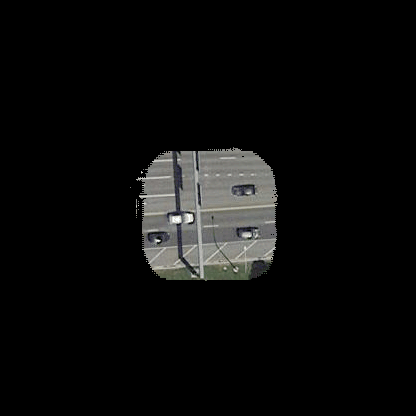

In [45]:
class_label = "road"
threshold = .20
classMap = new_road_factory.classMap
DrawingWithTensors.showInferenceOnImage(img, torch.sigmoid(outputs[0]), class_label, threshold, classMap)